In [2]:
# 1. Environment Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm # Progress bar
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from skimage.feature import hog
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.utils import class_weight
import numpy as np
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

In [3]:
# Dataset path and class names
dataset = 'data'
class_names = sorted([d for d in os.listdir(dataset) if os.path.isdir(os.path.join(dataset, d))])
print(f"Detected classes: {class_names}")
print(f"Total number of classes: {len(class_names)}")

Detected classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Total number of classes: 10


In [4]:
# Check the total number of images in the dataset
total_images = 0
for class_name in class_names:
    class_dir = os.path.join(dataset, class_name)
    num_images = len(os.listdir(class_dir))
    print(f"Class '{class_name}': {num_images} images")
    total_images += num_images
print(f"Total images in dataset: {total_images}")

Class 'Tomato___Bacterial_spot': 1702 images
Class 'Tomato___Early_blight': 800 images
Class 'Tomato___Late_blight': 1527 images
Class 'Tomato___Leaf_Mold': 761 images
Class 'Tomato___Septoria_leaf_spot': 1417 images
Class 'Tomato___Spider_mites Two-spotted_spider_mite': 1341 images
Class 'Tomato___Target_Spot': 1123 images
Class 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 4286 images
Class 'Tomato___Tomato_mosaic_virus': 299 images
Class 'Tomato___healthy': 1273 images
Total images in dataset: 14529


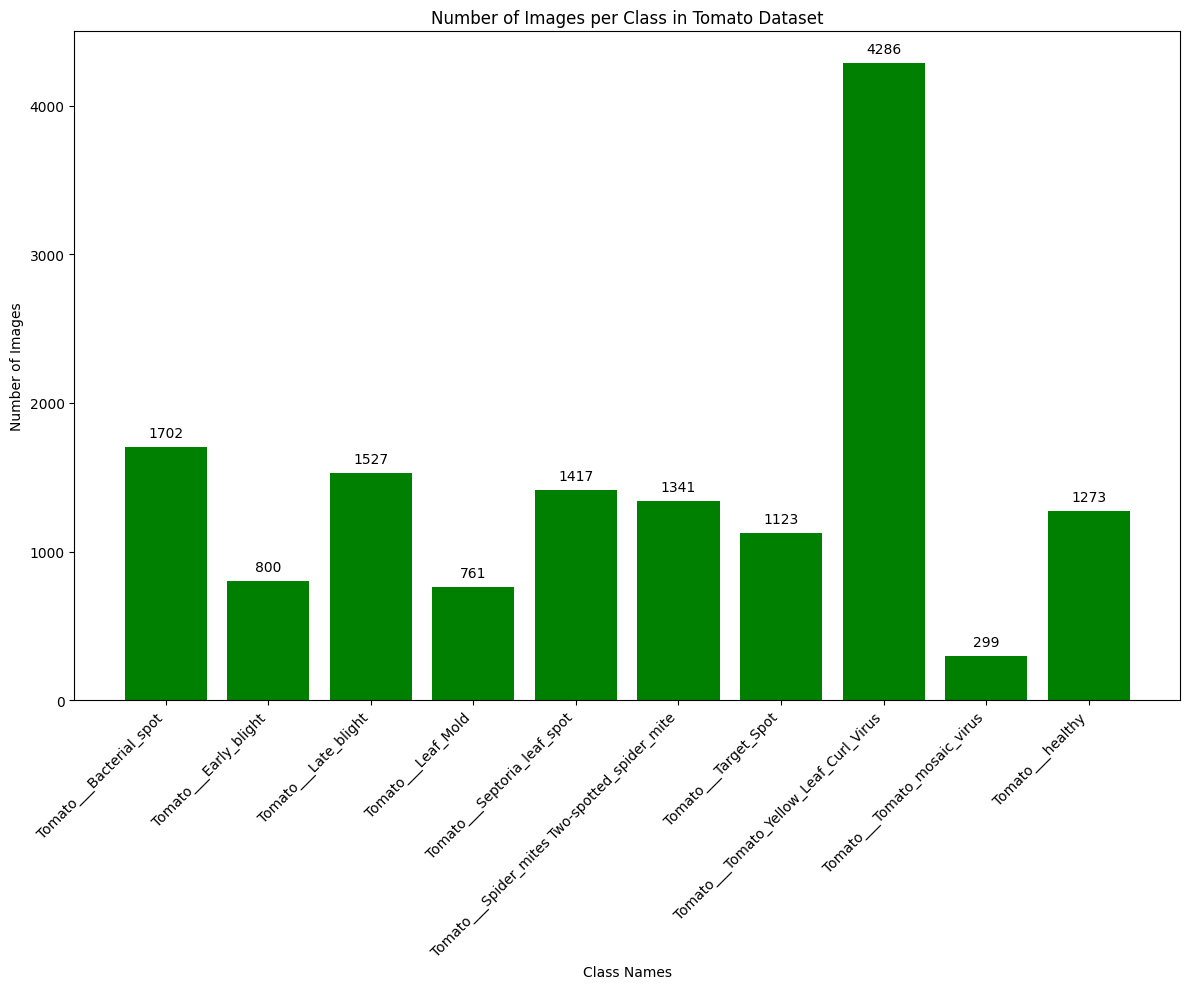

In [5]:
# Initialize lists and counters to store image counts per class and total images
class_image_counts = []
total_images = 0

# Count the number of images in each class directory
for class_name in class_names:
    class_dir = dataset + '/' + class_name
    num_images = len(os.listdir(class_dir))
    class_image_counts.append(num_images)
    total_images += num_images

# Plot a bar chart showing the number of images per class
fig, ax = plt.subplots(figsize=(12, 10))
bars = ax.bar(class_names, class_image_counts, color='green')
ax.bar_label(bars, padding=5)

# Customize x-axis labels
ax.set_xticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha="right")

# Set axis labels and chart title
ax.set_xlabel('Class Names')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class in Tomato Dataset')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [7]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from tqdm import tqdm

# === Configuration ===
dataset_dir = 'data'  # Root folder with class subfolders
img_size = 128        # Resize images to this size

X = []
y = []

# === Get class names ===
class_names = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])

# === Feature extraction: RGB histogram only ===
for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    for img_name in tqdm(os.listdir(class_dir), desc=f"Processing {class_name}"):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            # RGB histograms for each channel
            hist_r = cv2.calcHist([img], [0], None, [256], [0, 256])
            hist_g = cv2.calcHist([img], [1], None, [256], [0, 256])
            hist_b = cv2.calcHist([img], [2], None, [256], [0, 256])
            hist_r = cv2.normalize(hist_r, hist_r).flatten()
            hist_g = cv2.normalize(hist_g, hist_g).flatten()
            hist_b = cv2.normalize(hist_b, hist_b).flatten()
            features = np.concatenate([hist_r, hist_g, hist_b])
            X.append(features)
            y.append(class_name)

# === Convert to numpy arrays ===
X = np.array(X)
y = np.array(y)

# === Encode labels ===
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# === Dimensionality reduction (PCA) ===
pca = PCA(n_components=100, random_state=42)
X_pca = pca.fit_transform(X)

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# === KNN with GridSearchCV ===
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan', 'cosine']
}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

# === Best model and predictions ===
best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)

# === Evaluation ===
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

print("Best KNN parameters:", grid.best_params_)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Processing Tomato___Septoria_leaf_spot: 100%|████████████████████████████████████| 1417/1417 [00:00<00:00, 2056.73it/s]
Processing Tomato___Spider_mites Two-spotted_spider_mite: 100%|██████████████████| 1341/1341 [00:00<00:00, 1898.38it/s]
Processing Tomato___Target_Spot: 100%|███████████████████████████████████████████| 1123/1123 [00:00<00:00, 1902.94it/s]
Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus: 100%|█████████████████████████| 4286/4286 [00:01<00:00, 2215.83it/s]
Processing Tomato___healthy: 100%|███████████████████████████████████████████████| 1273/1273 [00:00<00:00, 1921.92it/s]
C:\Users\Obidur Rahman\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you wa

Best KNN parameters: {'metric': 'manhattan', 'n_neighbors': 3}
Accuracy: 0.8616655196145905
Classification Report:
                                                precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.86      0.83      0.85       341
                        Tomato___Early_blight       0.70      0.67      0.69       160
                         Tomato___Late_blight       0.85      0.75      0.80       305
                           Tomato___Leaf_Mold       0.87      0.82      0.84       152
                  Tomato___Septoria_leaf_spot       0.92      0.84      0.88       283
Tomato___Spider_mites Two-spotted_spider_mite       0.84      0.83      0.83       268
                         Tomato___Target_Spot       0.83      0.85      0.84       225
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.89      0.94      0.91       857
                 Tomato___Tomato_mosaic_virus       0.79      0.92      0.85        60
             

In [8]:
import numpy as np
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import os
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm

# ===== Configuration =====
DATASET_DIR = 'data'  # Root folder with class subfolders
IMG_SIZE = 128        # Resize images to this size
HOG_PARAMS = {
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'orientations': 9,
    'block_norm': 'L2-Hys'
}

# ===== Data Loading & Feature Extraction =====
def load_and_extract_features():
    X, y = [], []
    class_names = sorted([d for d in os.listdir(DATASET_DIR) 
                        if os.path.isdir(os.path.join(DATASET_DIR, d))])
    
    for class_name in class_names:
        class_dir = os.path.join(DATASET_DIR, class_name)
        for img_name in tqdm(os.listdir(class_dir), desc=f"Processing {class_name}"):
            img_path = os.path.join(class_dir, img_name)
            img = imread(img_path)
            if img is not None:
                # Preprocessing
                img_resized = resize(img, (IMG_SIZE, IMG_SIZE), anti_aliasing=True)
                gray_img = rgb2gray(img_resized)
                
                # HOG Feature Extraction
                hog_features = hog(gray_img, **HOG_PARAMS)
                X.append(hog_features)
                y.append(class_name)
    
    return np.array(X), np.array(y)

# ===== Main Pipeline =====
# Load data and extract features
X, y = load_and_extract_features()

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Dimensionality reduction
pca = PCA(n_components=100, random_state=42)
X_pca = pca.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Initialize and train SVM
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train, y_train)

# Evaluate
y_pred = svm.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Processing Tomato___Septoria_leaf_spot: 100%|██████████████████████████████████████| 1417/1417 [00:15<00:00, 92.84it/s]
Processing Tomato___Spider_mites Two-spotted_spider_mite: 100%|████████████████████| 1341/1341 [00:14<00:00, 91.98it/s]
Processing Tomato___Target_Spot: 100%|█████████████████████████████████████████████| 1123/1123 [00:12<00:00, 90.43it/s]
Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus: 100%|███████████████████████████| 4286/4286 [00:49<00:00, 87.28it/s]
Processing Tomato___healthy: 100%|█████████████████████████████████████████████████| 1273/1273 [00:15<00:00, 84.25it/s]


Accuracy: 0.75
Classification Report:
                                                precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.75      0.81      0.78       341
                        Tomato___Early_blight       0.43      0.27      0.33       160
                         Tomato___Late_blight       0.74      0.73      0.73       305
                           Tomato___Leaf_Mold       0.71      0.61      0.66       152
                  Tomato___Septoria_leaf_spot       0.61      0.65      0.63       283
Tomato___Spider_mites Two-spotted_spider_mite       0.74      0.80      0.77       268
                         Tomato___Target_Spot       0.61      0.58      0.59       225
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.85      0.92      0.88       857
                 Tomato___Tomato_mosaic_virus       0.80      0.40      0.53        60
                             Tomato___healthy       0.86      0.83      0.85       255

  

In [13]:
# Install required package first
!pip install --upgrade xgboost scikit-image
import numpy as np
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import os
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm
from xgboost import XGBClassifier

# ===== Configuration =====
DATASET_DIR = 'data'  # Root folder with class subfolders
IMG_SIZE = 128        # Resize images to this size
HOG_PARAMS = {
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'orientations': 9,
    'block_norm': 'L2-Hys'
}

# ===== Data Loading & Feature Extraction =====
def load_and_extract_features():
    # Verify dataset directory exists
    if not os.path.exists(DATASET_DIR):
        raise FileNotFoundError(f"Dataset directory '{DATASET_DIR}' not found")
    
    X, y = [], []
    class_names = sorted([d for d in os.listdir(DATASET_DIR) 
                        if os.path.isdir(os.path.join(DATASET_DIR, d))])
    
    for class_name in class_names:
        class_dir = os.path.join(DATASET_DIR, class_name)
        for img_name in tqdm(os.listdir(class_dir), desc=f"Processing {class_name}"):
            img_path = os.path.join(class_dir, img_name)
            img = imread(img_path)
            if img is not None:
                # Preprocessing
                img_resized = resize(img, (IMG_SIZE, IMG_SIZE), anti_aliasing=True)
                gray_img = rgb2gray(img_resized)
                
                # HOG Feature Extraction
                hog_features = hog(gray_img, **HOG_PARAMS)
                X.append(hog_features)
                y.append(class_name)
    
    return np.array(X), np.array(y)

# ===== Main Pipeline =====
if __name__ == "__main__":
    # Load data and extract features
    X, y = load_and_extract_features()
    
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Dimensionality reduction
    pca = PCA(n_components=100, random_state=42)
    X_pca = pca.fit_transform(X)
        # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    # Initialize classifier WITH early_stopping_rounds in constructor
    xgb = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        early_stopping_rounds=10,  # Critical parameter placement
        random_state=42
    )
    
    # Fit without early_stopping_rounds in .fit()
    xgb.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=True
    )
    
    # Evaluate
    y_pred = xgb.predict(X_test)
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

[0]	validation_0-mlogloss:1.89350


C:\Users\Obidur Rahman\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:49:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[1]	validation_0-mlogloss:1.71709
[2]	validation_0-mlogloss:1.60490
[3]	validation_0-mlogloss:1.51784
[4]	validation_0-mlogloss:1.45466
[5]	validation_0-mlogloss:1.39890
[6]	validation_0-mlogloss:1.35722
[7]	validation_0-mlogloss:1.31770
[8]	validation_0-mlogloss:1.28808
[9]	validation_0-mlogloss:1.26482
[10]	validation_0-mlogloss:1.24150
[11]	validation_0-mlogloss:1.22237
[12]	validation_0-mlogloss:1.20431
[13]	validation_0-mlogloss:1.18881
[14]	validation_0-mlogloss:1.17441
[15]	validation_0-mlogloss:1.16203
[16]	validation_0-mlogloss:1.15213
[17]	validation_0-mlogloss:1.14097
[18]	validation_0-mlogloss:1.13247
[19]	validation_0-mlogloss:1.12400
[20]	validation_0-mlogloss:1.11789
[21]	validation_0-mlogloss:1.11027
[22]	validation_0-mlogloss:1.10345
[23]	validation_0-mlogloss:1.09713
[24]	validation_0-mlogloss:1.09027
[25]	validation_0-mlogloss:1.08405
[26]	validation_0-mlogloss:1.07880
[27]	validation_0-mlogloss:1.07464
[28]	validation_0-mlogloss:1.07130
[29]	validation_0-mlogloss:1.

Deep Learning-Based Features (Pre-trained CNNs)

    Description: Use a pre-trained convolutional neural network (CNN) like VGG16, ResNet50, EfficientNet, or Vision Transformer (ViT) to extract features from images. These models, trained on large datasets like ImageNet, capture rich, hierarchical features (edges, textures, objects) that are often more discriminative than hand-crafted features like HOG.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np

# Load pre-trained ResNet50 (without top classification layer)
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def load_and_extract_features():
    X, y = [], []
    class_names = sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))])
    
    for class_name in class_names:
        class_dir = os.path.join(DATASET_DIR, class_name)
        for img_name in tqdm(os.listdir(class_dir), desc=f"Processing {class_name}"):
            img_path = os.path.join(class_dir, img_name)
            img = imread(img_path)
            if img is not None:
                # Resize and preprocess for ResNet50
                img_resized = resize(img, (224, 224), anti_aliasing=True)  # ResNet50 expects 224x224
                img_array = img_to_array(img_resized)
                img_array = np.expand_dims(img_array, axis=0)
                img_array = preprocess_input(img_array)
                # Extract features
                features = model.predict(img_array).flatten()
                X.append(features)
                y.append(class_name)
    
    return np.array(X), np.array(y)


# ===== Main Pipeline =====
if __name__ == "__main__":
    # Load data and extract features
    X, y = load_and_extract_features()
    
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Dimensionality reduction
    pca = PCA(n_components=100, random_state=42)
    X_pca = pca.fit_transform(X)
        # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    # Initialize classifier WITH early_stopping_rounds in constructor
    xgb = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        early_stopping_rounds=10,  # Critical parameter placement
        random_state=42
    )
    
    # Fit without early_stopping_rounds in .fit()
    xgb.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=True
    )
    
    # Evaluate
    y_pred = xgb.predict(X_test)
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Processing Tomato___Bacterial_spot:   0%|                                                     | 0/1702 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Processing Tomato___Bacterial_spot:   0%|                                           | 1/1702 [00:05<2:35:44,  5.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   0%|                                           | 2/1702 [00:05<1:09:30,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   0%|                                             | 3/1702 [00:05<39:21,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   0%|                                             | 4/1702 [00:06<25:13,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:   0%|▏                                            | 5/1702 [00:06<17:23,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:   0%|▏                                            | 6/1702 [00:06<12:39,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:   0%|▏                                            | 7/1702 [00:06<09:39,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:   0%|▏                                            | 8/1702 [00:06<07:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:   1%|▏                                            | 9/1702 [00:06<06:22,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:   1%|▎                                           | 10/1702 [00:06<05:31,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:   1%|▎                                           | 11/1702 [00:06<04:56,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   1%|▎                                           | 12/1702 [00:07<04:31,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Tomato___Bacterial_spot:   1%|▎                                           | 13/1702 [00:07<04:20,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Tomato___Bacterial_spot:   1%|▎                                           | 14/1702 [00:07<04:12,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Tomato___Bacterial_spot:   1%|▍                                           | 15/1702 [00:07<04:06,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Tomato___Bacterial_spot:   1%|▍                                           | 16/1702 [00:07<04:01,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Bacterial_spot:   1%|▍                                           | 17/1702 [00:07<03:55,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Tomato___Bacterial_spot:   1%|▍                                           | 18/1702 [00:07<03:52,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Tomato___Bacterial_spot:   1%|▍                                           | 19/1702 [00:08<03:50,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Tomato___Bacterial_spot:   1%|▌                                           | 20/1702 [00:08<03:51,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Tomato___Bacterial_spot:   1%|▌                                           | 21/1702 [00:08<03:51,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Tomato___Bacterial_spot:   1%|▌                                           | 22/1702 [00:08<03:54,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Tomato___Bacterial_spot:   1%|▌                                           | 23/1702 [00:08<03:53,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Tomato___Bacterial_spot:   1%|▌                                           | 24/1702 [00:08<03:52,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:   1%|▋                                           | 25/1702 [00:08<03:46,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:   2%|▋                                           | 26/1702 [00:08<03:42,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:   2%|▋                                           | 27/1702 [00:09<03:36,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:   2%|▋                                           | 28/1702 [00:09<03:33,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:   2%|▋                                           | 29/1702 [00:09<03:29,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:   2%|▊                                           | 30/1702 [00:09<03:28,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:   2%|▊                                           | 31/1702 [00:09<03:24,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:   2%|▊                                           | 32/1702 [00:09<03:22,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:   2%|▊                                           | 33/1702 [00:09<03:25,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Tomato___Bacterial_spot:   2%|▉                                           | 34/1702 [00:09<03:31,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Tomato___Bacterial_spot:   2%|▉                                           | 35/1702 [00:10<03:36,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:   2%|▉                                           | 36/1702 [00:10<03:33,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:   2%|▉                                           | 37/1702 [00:10<03:29,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:   2%|▉                                           | 38/1702 [00:10<03:27,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:   2%|█                                           | 39/1702 [00:10<03:24,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:   2%|█                                           | 40/1702 [00:10<03:21,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:   2%|█                                           | 41/1702 [00:10<03:20,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:   2%|█                                           | 42/1702 [00:10<03:19,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:   3%|█                                           | 43/1702 [00:11<03:18,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:   3%|█▏                                          | 44/1702 [00:11<03:17,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:   3%|█▏                                          | 45/1702 [00:11<03:18,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:   3%|█▏                                          | 46/1702 [00:11<03:18,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:   3%|█▏                                          | 47/1702 [00:11<03:18,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:   3%|█▏                                          | 48/1702 [00:11<03:16,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:   3%|█▎                                          | 49/1702 [00:11<03:16,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:   3%|█▎                                          | 50/1702 [00:11<03:16,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:   3%|█▎                                          | 51/1702 [00:12<03:15,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:   3%|█▎                                          | 52/1702 [00:12<03:15,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:   3%|█▎                                          | 53/1702 [00:12<03:14,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:   3%|█▍                                          | 54/1702 [00:12<03:15,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:   3%|█▍                                          | 55/1702 [00:12<03:17,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Bacterial_spot:   3%|█▍                                          | 56/1702 [00:12<03:28,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:   3%|█▍                                          | 57/1702 [00:12<03:31,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   3%|█▍                                          | 58/1702 [00:12<03:30,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:   3%|█▌                                          | 59/1702 [00:13<03:30,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:   4%|█▌                                          | 60/1702 [00:13<03:28,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:   4%|█▌                                          | 61/1702 [00:13<03:25,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:   4%|█▌                                          | 62/1702 [00:13<03:25,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   4%|█▋                                          | 63/1702 [00:13<03:25,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:   4%|█▋                                          | 64/1702 [00:13<03:24,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:   4%|█▋                                          | 65/1702 [00:13<03:23,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:   4%|█▋                                          | 66/1702 [00:13<03:21,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:   4%|█▋                                          | 67/1702 [00:14<03:20,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:   4%|█▊                                          | 68/1702 [00:14<03:19,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Bacterial_spot:   4%|█▊                                          | 69/1702 [00:14<03:24,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Bacterial_spot:   4%|█▊                                          | 70/1702 [00:14<03:27,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   4%|█▊                                          | 71/1702 [00:14<03:26,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:   4%|█▊                                          | 72/1702 [00:14<03:24,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:   4%|█▉                                          | 73/1702 [00:14<03:22,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:   4%|█▉                                          | 74/1702 [00:14<03:21,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:   4%|█▉                                          | 75/1702 [00:15<03:18,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   4%|█▉                                          | 76/1702 [00:15<03:19,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Bacterial_spot:   5%|█▉                                          | 77/1702 [00:15<03:24,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:   5%|██                                          | 78/1702 [00:15<03:27,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:   5%|██                                          | 79/1702 [00:15<03:27,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:   5%|██                                          | 80/1702 [00:15<03:27,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Bacterial_spot:   5%|██                                          | 81/1702 [00:15<03:28,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:   5%|██                                          | 82/1702 [00:15<03:26,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:   5%|██▏                                         | 83/1702 [00:16<03:25,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:   5%|██▏                                         | 84/1702 [00:16<03:27,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:   5%|██▏                                         | 85/1702 [00:16<03:28,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:   5%|██▏                                         | 86/1702 [00:16<03:28,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:   5%|██▏                                         | 87/1702 [00:16<03:28,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:   5%|██▎                                         | 88/1702 [00:16<03:25,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:   5%|██▎                                         | 89/1702 [00:16<03:21,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:   5%|██▎                                         | 90/1702 [00:16<03:20,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:   5%|██▎                                         | 91/1702 [00:17<03:17,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:   5%|██▍                                         | 92/1702 [00:17<03:15,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:   5%|██▍                                         | 93/1702 [00:17<03:14,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:   6%|██▍                                         | 94/1702 [00:17<03:12,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:   6%|██▍                                         | 95/1702 [00:17<03:12,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:   6%|██▍                                         | 96/1702 [00:17<03:13,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:   6%|██▌                                         | 97/1702 [00:17<03:13,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:   6%|██▌                                         | 98/1702 [00:17<03:14,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:   6%|██▌                                         | 99/1702 [00:17<03:13,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:   6%|██▌                                        | 100/1702 [00:18<03:14,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:   6%|██▌                                        | 101/1702 [00:18<03:14,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:   6%|██▌                                        | 102/1702 [00:18<03:15,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   6%|██▌                                        | 103/1702 [00:18<03:16,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:   6%|██▋                                        | 104/1702 [00:18<03:16,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:   6%|██▋                                        | 105/1702 [00:18<03:15,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   6%|██▋                                        | 106/1702 [00:18<03:14,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:   6%|██▋                                        | 107/1702 [00:18<03:14,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:   6%|██▋                                        | 108/1702 [00:19<03:17,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Bacterial_spot:   6%|██▊                                        | 109/1702 [00:19<03:21,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:   6%|██▊                                        | 110/1702 [00:19<03:24,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Bacterial_spot:   7%|██▊                                        | 111/1702 [00:19<03:24,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:   7%|██▊                                        | 112/1702 [00:19<03:27,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   7%|██▊                                        | 113/1702 [00:19<03:26,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   7%|██▉                                        | 114/1702 [00:19<03:23,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:   7%|██▉                                        | 115/1702 [00:20<03:21,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:   7%|██▉                                        | 116/1702 [00:20<03:17,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:   7%|██▉                                        | 117/1702 [00:20<03:14,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:   7%|██▉                                        | 118/1702 [00:20<03:14,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:   7%|███                                        | 119/1702 [00:20<03:12,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:   7%|███                                        | 120/1702 [00:20<03:12,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:   7%|███                                        | 121/1702 [00:20<03:11,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:   7%|███                                        | 122/1702 [00:20<03:13,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:   7%|███                                        | 123/1702 [00:20<03:12,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   7%|███▏                                       | 124/1702 [00:21<03:14,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:   7%|███▏                                       | 125/1702 [00:21<03:15,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   7%|███▏                                       | 126/1702 [00:21<03:16,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:   7%|███▏                                       | 127/1702 [00:21<03:17,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   8%|███▏                                       | 128/1702 [00:21<03:17,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   8%|███▎                                       | 129/1702 [00:21<03:17,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   8%|███▎                                       | 130/1702 [00:21<03:18,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:   8%|███▎                                       | 131/1702 [00:21<03:17,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:   8%|███▎                                       | 132/1702 [00:22<03:16,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:   8%|███▎                                       | 133/1702 [00:22<03:18,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:   8%|███▍                                       | 134/1702 [00:22<03:22,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:   8%|███▍                                       | 135/1702 [00:22<03:21,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   8%|███▍                                       | 136/1702 [00:22<03:20,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:   8%|███▍                                       | 137/1702 [00:22<03:18,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:   8%|███▍                                       | 138/1702 [00:22<03:17,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:   8%|███▌                                       | 139/1702 [00:23<03:16,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:   8%|███▌                                       | 140/1702 [00:23<03:13,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:   8%|███▌                                       | 141/1702 [00:23<03:14,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:   8%|███▌                                       | 142/1702 [00:23<03:15,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   8%|███▌                                       | 143/1702 [00:23<03:16,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   8%|███▋                                       | 144/1702 [00:23<03:17,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   9%|███▋                                       | 145/1702 [00:23<03:17,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:   9%|███▋                                       | 146/1702 [00:23<03:18,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   9%|███▋                                       | 147/1702 [00:24<03:18,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:   9%|███▋                                       | 148/1702 [00:24<03:18,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:   9%|███▊                                       | 149/1702 [00:24<03:17,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   9%|███▊                                       | 150/1702 [00:24<03:17,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:   9%|███▊                                       | 151/1702 [00:24<03:17,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   9%|███▊                                       | 152/1702 [00:24<03:19,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:   9%|███▊                                       | 153/1702 [00:24<03:18,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:   9%|███▉                                       | 154/1702 [00:24<03:19,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   9%|███▉                                       | 155/1702 [00:25<03:18,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:   9%|███▉                                       | 156/1702 [00:25<03:20,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:   9%|███▉                                       | 157/1702 [00:25<03:18,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   9%|███▉                                       | 158/1702 [00:25<03:18,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:   9%|████                                       | 159/1702 [00:25<03:17,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:   9%|████                                       | 160/1702 [00:25<03:16,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:   9%|████                                       | 161/1702 [00:25<03:15,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  10%|████                                       | 162/1702 [00:25<03:15,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  10%|████                                       | 163/1702 [00:26<03:16,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  10%|████▏                                      | 164/1702 [00:26<03:14,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  10%|████▏                                      | 165/1702 [00:26<03:14,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  10%|████▏                                      | 166/1702 [00:26<03:14,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  10%|████▏                                      | 167/1702 [00:26<03:15,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  10%|████▏                                      | 168/1702 [00:26<03:14,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  10%|████▎                                      | 169/1702 [00:26<03:13,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  10%|████▎                                      | 170/1702 [00:26<03:12,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  10%|████▎                                      | 171/1702 [00:27<03:10,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  10%|████▎                                      | 172/1702 [00:27<03:11,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  10%|████▎                                      | 173/1702 [00:27<03:13,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  10%|████▍                                      | 174/1702 [00:27<03:13,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  10%|████▍                                      | 175/1702 [00:27<03:12,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  10%|████▍                                      | 176/1702 [00:27<03:13,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  10%|████▍                                      | 177/1702 [00:27<03:12,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  10%|████▍                                      | 178/1702 [00:27<03:11,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:  11%|████▌                                      | 179/1702 [00:28<03:13,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  11%|████▌                                      | 180/1702 [00:28<03:13,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  11%|████▌                                      | 181/1702 [00:28<03:11,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  11%|████▌                                      | 182/1702 [00:28<03:13,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:  11%|████▌                                      | 183/1702 [00:28<03:14,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Tomato___Bacterial_spot:  11%|████▋                                      | 184/1702 [00:28<03:17,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  11%|████▋                                      | 185/1702 [00:28<03:16,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  11%|████▋                                      | 186/1702 [00:28<03:15,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Bacterial_spot:  11%|████▋                                      | 187/1702 [00:29<03:15,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  11%|████▋                                      | 188/1702 [00:29<03:16,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  11%|████▊                                      | 189/1702 [00:29<03:16,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  11%|████▊                                      | 190/1702 [00:29<03:13,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  11%|████▊                                      | 191/1702 [00:29<03:10,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  11%|████▊                                      | 192/1702 [00:29<03:07,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  11%|████▉                                      | 193/1702 [00:29<03:04,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  11%|████▉                                      | 194/1702 [00:29<03:03,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  11%|████▉                                      | 195/1702 [00:30<03:01,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  12%|████▉                                      | 196/1702 [00:30<03:00,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  12%|████▉                                      | 197/1702 [00:30<03:01,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  12%|█████                                      | 198/1702 [00:30<03:00,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  12%|█████                                      | 199/1702 [00:30<02:59,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  12%|█████                                      | 200/1702 [00:30<03:00,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  12%|█████                                      | 201/1702 [00:30<03:01,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  12%|█████                                      | 202/1702 [00:30<03:03,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  12%|█████▏                                     | 203/1702 [00:31<03:04,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  12%|█████▏                                     | 204/1702 [00:31<03:05,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  12%|█████▏                                     | 205/1702 [00:31<03:06,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  12%|█████▏                                     | 206/1702 [00:31<03:07,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  12%|█████▏                                     | 207/1702 [00:31<03:06,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  12%|█████▎                                     | 208/1702 [00:31<03:05,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  12%|█████▎                                     | 209/1702 [00:31<03:05,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  12%|█████▎                                     | 210/1702 [00:31<03:05,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  12%|█████▎                                     | 211/1702 [00:32<03:04,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  12%|█████▎                                     | 212/1702 [00:32<03:05,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  13%|█████▍                                     | 213/1702 [00:32<03:05,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  13%|█████▍                                     | 214/1702 [00:32<03:04,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  13%|█████▍                                     | 215/1702 [00:32<03:04,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:  13%|█████▍                                     | 216/1702 [00:32<03:06,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  13%|█████▍                                     | 217/1702 [00:32<03:06,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  13%|█████▌                                     | 218/1702 [00:32<03:07,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  13%|█████▌                                     | 219/1702 [00:33<03:07,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  13%|█████▌                                     | 220/1702 [00:33<03:05,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  13%|█████▌                                     | 221/1702 [00:33<03:05,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  13%|█████▌                                     | 222/1702 [00:33<03:06,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  13%|█████▋                                     | 223/1702 [00:33<03:06,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:  13%|█████▋                                     | 224/1702 [00:33<03:09,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  13%|█████▋                                     | 225/1702 [00:33<03:08,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  13%|█████▋                                     | 226/1702 [00:33<03:06,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  13%|█████▋                                     | 227/1702 [00:34<03:06,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  13%|█████▊                                     | 228/1702 [00:34<03:09,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  13%|█████▊                                     | 229/1702 [00:34<03:07,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  14%|█████▊                                     | 230/1702 [00:34<03:06,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Bacterial_spot:  14%|█████▊                                     | 231/1702 [00:34<03:08,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  14%|█████▊                                     | 232/1702 [00:34<03:09,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  14%|█████▉                                     | 233/1702 [00:34<03:08,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  14%|█████▉                                     | 234/1702 [00:34<03:03,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  14%|█████▉                                     | 235/1702 [00:35<03:01,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  14%|█████▉                                     | 236/1702 [00:35<02:59,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  14%|█████▉                                     | 237/1702 [00:35<02:58,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  14%|██████                                     | 238/1702 [00:35<02:59,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  14%|██████                                     | 239/1702 [00:35<03:03,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Bacterial_spot:  14%|██████                                     | 240/1702 [00:35<03:07,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Bacterial_spot:  14%|██████                                     | 241/1702 [00:35<03:10,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  14%|██████                                     | 242/1702 [00:35<03:09,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  14%|██████▏                                    | 243/1702 [00:36<03:07,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  14%|██████▏                                    | 244/1702 [00:36<03:05,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  14%|██████▏                                    | 245/1702 [00:36<03:03,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  14%|██████▏                                    | 246/1702 [00:36<02:59,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  15%|██████▏                                    | 247/1702 [00:36<03:00,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  15%|██████▎                                    | 248/1702 [00:36<02:58,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  15%|██████▎                                    | 249/1702 [00:36<02:56,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  15%|██████▎                                    | 250/1702 [00:36<02:55,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  15%|██████▎                                    | 251/1702 [00:37<02:54,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  15%|██████▎                                    | 252/1702 [00:37<02:54,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  15%|██████▍                                    | 253/1702 [00:37<02:55,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  15%|██████▍                                    | 254/1702 [00:37<02:54,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  15%|██████▍                                    | 255/1702 [00:37<02:53,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  15%|██████▍                                    | 256/1702 [00:37<02:52,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  15%|██████▍                                    | 257/1702 [00:37<02:54,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Bacterial_spot:  15%|██████▌                                    | 258/1702 [00:37<03:02,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  15%|██████▌                                    | 259/1702 [00:38<03:04,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:  15%|██████▌                                    | 260/1702 [00:38<03:06,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Bacterial_spot:  15%|██████▌                                    | 261/1702 [00:38<03:07,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Tomato___Bacterial_spot:  15%|██████▌                                    | 262/1702 [00:38<03:11,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Tomato___Bacterial_spot:  15%|██████▋                                    | 263/1702 [00:38<03:13,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  16%|██████▋                                    | 264/1702 [00:38<03:09,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  16%|██████▋                                    | 265/1702 [00:38<03:04,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  16%|██████▋                                    | 266/1702 [00:38<03:02,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  16%|██████▋                                    | 267/1702 [00:39<03:00,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  16%|██████▊                                    | 268/1702 [00:39<02:55,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  16%|██████▊                                    | 269/1702 [00:39<02:53,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  16%|██████▊                                    | 270/1702 [00:39<02:53,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  16%|██████▊                                    | 271/1702 [00:39<02:51,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  16%|██████▊                                    | 272/1702 [00:39<02:50,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  16%|██████▉                                    | 273/1702 [00:39<02:50,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  16%|██████▉                                    | 274/1702 [00:39<02:50,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  16%|██████▉                                    | 275/1702 [00:40<02:50,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  16%|██████▉                                    | 276/1702 [00:40<02:49,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  16%|██████▉                                    | 277/1702 [00:40<02:48,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  16%|███████                                    | 278/1702 [00:40<02:49,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  16%|███████                                    | 279/1702 [00:40<02:49,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  16%|███████                                    | 280/1702 [00:40<02:48,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  17%|███████                                    | 281/1702 [00:40<02:48,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  17%|███████                                    | 282/1702 [00:40<02:48,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  17%|███████▏                                   | 283/1702 [00:41<02:49,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  17%|███████▏                                   | 284/1702 [00:41<02:54,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  17%|███████▏                                   | 285/1702 [00:41<02:55,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  17%|███████▏                                   | 286/1702 [00:41<02:57,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  17%|███████▎                                   | 287/1702 [00:41<02:57,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  17%|███████▎                                   | 288/1702 [00:41<02:55,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  17%|███████▎                                   | 289/1702 [00:41<02:54,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  17%|███████▎                                   | 290/1702 [00:41<02:53,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  17%|███████▎                                   | 291/1702 [00:42<02:50,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  17%|███████▍                                   | 292/1702 [00:42<02:50,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  17%|███████▍                                   | 293/1702 [00:42<02:48,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  17%|███████▍                                   | 294/1702 [00:42<02:47,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  17%|███████▍                                   | 295/1702 [00:42<02:47,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  17%|███████▍                                   | 296/1702 [00:42<02:46,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  17%|███████▌                                   | 297/1702 [00:42<02:45,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  18%|███████▌                                   | 298/1702 [00:42<02:45,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  18%|███████▌                                   | 299/1702 [00:42<02:47,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  18%|███████▌                                   | 300/1702 [00:43<02:50,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  18%|███████▌                                   | 301/1702 [00:43<02:49,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  18%|███████▋                                   | 302/1702 [00:43<02:50,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  18%|███████▋                                   | 303/1702 [00:43<02:50,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  18%|███████▋                                   | 304/1702 [00:43<02:49,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  18%|███████▋                                   | 305/1702 [00:43<02:49,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  18%|███████▋                                   | 306/1702 [00:43<02:47,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  18%|███████▊                                   | 307/1702 [00:43<02:47,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  18%|███████▊                                   | 308/1702 [00:44<02:47,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  18%|███████▊                                   | 309/1702 [00:44<02:47,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  18%|███████▊                                   | 310/1702 [00:44<02:46,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  18%|███████▊                                   | 311/1702 [00:44<02:45,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  18%|███████▉                                   | 312/1702 [00:44<02:45,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  18%|███████▉                                   | 313/1702 [00:44<02:46,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  18%|███████▉                                   | 314/1702 [00:44<02:47,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  19%|███████▉                                   | 315/1702 [00:44<02:48,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  19%|███████▉                                   | 316/1702 [00:45<02:48,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  19%|████████                                   | 317/1702 [00:45<02:46,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  19%|████████                                   | 318/1702 [00:45<02:45,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  19%|████████                                   | 319/1702 [00:45<02:45,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  19%|████████                                   | 320/1702 [00:45<02:44,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  19%|████████                                   | 321/1702 [00:45<02:44,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  19%|████████▏                                  | 322/1702 [00:45<02:43,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  19%|████████▏                                  | 323/1702 [00:45<02:44,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  19%|████████▏                                  | 324/1702 [00:45<02:44,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  19%|████████▏                                  | 325/1702 [00:46<02:44,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  19%|████████▏                                  | 326/1702 [00:46<02:43,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  19%|████████▎                                  | 327/1702 [00:46<02:43,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  19%|████████▎                                  | 328/1702 [00:46<02:43,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  19%|████████▎                                  | 329/1702 [00:46<02:43,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  19%|████████▎                                  | 330/1702 [00:46<02:43,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  19%|████████▎                                  | 331/1702 [00:46<02:43,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  20%|████████▍                                  | 332/1702 [00:46<02:43,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  20%|████████▍                                  | 333/1702 [00:47<02:44,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  20%|████████▍                                  | 334/1702 [00:47<02:43,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  20%|████████▍                                  | 335/1702 [00:47<02:43,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  20%|████████▍                                  | 336/1702 [00:47<02:42,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  20%|████████▌                                  | 337/1702 [00:47<02:42,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  20%|████████▌                                  | 338/1702 [00:47<02:43,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  20%|████████▌                                  | 339/1702 [00:47<02:42,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  20%|████████▌                                  | 340/1702 [00:47<02:42,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  20%|████████▌                                  | 341/1702 [00:47<02:41,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  20%|████████▋                                  | 342/1702 [00:48<02:41,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  20%|████████▋                                  | 343/1702 [00:48<02:40,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  20%|████████▋                                  | 344/1702 [00:48<02:40,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  20%|████████▋                                  | 345/1702 [00:48<02:40,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  20%|████████▋                                  | 346/1702 [00:48<02:40,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  20%|████████▊                                  | 347/1702 [00:48<02:39,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  20%|████████▊                                  | 348/1702 [00:48<02:40,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  21%|████████▊                                  | 349/1702 [00:48<02:40,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  21%|████████▊                                  | 350/1702 [00:49<02:41,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  21%|████████▊                                  | 351/1702 [00:49<02:41,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  21%|████████▉                                  | 352/1702 [00:49<02:40,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  21%|████████▉                                  | 353/1702 [00:49<02:39,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  21%|████████▉                                  | 354/1702 [00:49<02:39,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  21%|████████▉                                  | 355/1702 [00:49<02:40,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  21%|████████▉                                  | 356/1702 [00:49<02:40,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  21%|█████████                                  | 357/1702 [00:49<02:39,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  21%|█████████                                  | 358/1702 [00:49<02:40,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  21%|█████████                                  | 359/1702 [00:50<02:40,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  21%|█████████                                  | 360/1702 [00:50<02:40,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  21%|█████████                                  | 361/1702 [00:50<02:39,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  21%|█████████▏                                 | 362/1702 [00:50<02:39,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  21%|█████████▏                                 | 363/1702 [00:50<02:38,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  21%|█████████▏                                 | 364/1702 [00:50<02:37,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  21%|█████████▏                                 | 365/1702 [00:50<02:37,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  22%|█████████▏                                 | 366/1702 [00:50<02:39,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  22%|█████████▎                                 | 367/1702 [00:51<02:38,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  22%|█████████▎                                 | 368/1702 [00:51<02:37,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  22%|█████████▎                                 | 369/1702 [00:51<02:35,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  22%|█████████▎                                 | 370/1702 [00:51<02:34,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  22%|█████████▎                                 | 371/1702 [00:51<02:32,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  22%|█████████▍                                 | 372/1702 [00:51<02:32,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  22%|█████████▍                                 | 373/1702 [00:51<02:32,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  22%|█████████▍                                 | 374/1702 [00:51<02:32,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  22%|█████████▍                                 | 375/1702 [00:51<02:32,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  22%|█████████▍                                 | 376/1702 [00:52<02:33,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  22%|█████████▌                                 | 377/1702 [00:52<02:33,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  22%|█████████▌                                 | 378/1702 [00:52<02:33,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  22%|█████████▌                                 | 379/1702 [00:52<02:32,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  22%|█████████▌                                 | 380/1702 [00:52<02:31,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  22%|█████████▋                                 | 381/1702 [00:52<02:31,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  22%|█████████▋                                 | 382/1702 [00:52<02:31,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  23%|█████████▋                                 | 383/1702 [00:52<02:31,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  23%|█████████▋                                 | 384/1702 [00:53<02:33,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  23%|█████████▋                                 | 385/1702 [00:53<02:32,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  23%|█████████▊                                 | 386/1702 [00:53<02:35,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  23%|█████████▊                                 | 387/1702 [00:53<02:34,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  23%|█████████▊                                 | 388/1702 [00:53<02:34,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  23%|█████████▊                                 | 389/1702 [00:53<02:33,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  23%|█████████▊                                 | 390/1702 [00:53<02:33,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  23%|█████████▉                                 | 391/1702 [00:53<02:32,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  23%|█████████▉                                 | 392/1702 [00:53<02:34,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  23%|█████████▉                                 | 393/1702 [00:54<02:33,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  23%|█████████▉                                 | 394/1702 [00:54<02:32,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  23%|█████████▉                                 | 395/1702 [00:54<02:32,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  23%|██████████                                 | 396/1702 [00:54<02:32,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  23%|██████████                                 | 397/1702 [00:54<02:31,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  23%|██████████                                 | 398/1702 [00:54<02:31,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  23%|██████████                                 | 399/1702 [00:54<02:31,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  24%|██████████                                 | 400/1702 [00:54<02:31,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  24%|██████████▏                                | 401/1702 [00:55<02:31,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  24%|██████████▏                                | 402/1702 [00:55<02:33,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  24%|██████████▏                                | 403/1702 [00:55<02:33,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  24%|██████████▏                                | 404/1702 [00:55<02:37,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  24%|██████████▏                                | 405/1702 [00:55<02:34,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  24%|██████████▎                                | 406/1702 [00:55<02:33,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  24%|██████████▎                                | 407/1702 [00:55<02:32,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  24%|██████████▎                                | 408/1702 [00:55<02:30,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  24%|██████████▎                                | 409/1702 [00:55<02:30,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  24%|██████████▎                                | 410/1702 [00:56<02:30,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  24%|██████████▍                                | 411/1702 [00:56<02:29,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  24%|██████████▍                                | 412/1702 [00:56<02:31,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  24%|██████████▍                                | 413/1702 [00:56<02:35,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  24%|██████████▍                                | 414/1702 [00:56<02:36,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  24%|██████████▍                                | 415/1702 [00:56<02:36,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  24%|██████████▌                                | 416/1702 [00:56<02:34,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  25%|██████████▌                                | 417/1702 [00:56<02:32,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  25%|██████████▌                                | 418/1702 [00:57<02:30,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  25%|██████████▌                                | 419/1702 [00:57<02:29,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  25%|██████████▌                                | 420/1702 [00:57<02:29,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  25%|██████████▋                                | 421/1702 [00:57<02:28,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  25%|██████████▋                                | 422/1702 [00:57<02:28,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  25%|██████████▋                                | 423/1702 [00:57<02:27,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  25%|██████████▋                                | 424/1702 [00:57<02:30,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  25%|██████████▋                                | 425/1702 [00:57<02:33,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  25%|██████████▊                                | 426/1702 [00:57<02:35,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  25%|██████████▊                                | 427/1702 [00:58<02:36,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  25%|██████████▊                                | 428/1702 [00:58<02:37,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  25%|██████████▊                                | 429/1702 [00:58<02:38,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  25%|██████████▊                                | 430/1702 [00:58<02:38,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  25%|██████████▉                                | 431/1702 [00:58<02:37,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  25%|██████████▉                                | 432/1702 [00:58<02:35,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  25%|██████████▉                                | 433/1702 [00:58<02:33,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Tomato___Bacterial_spot:  25%|██████████▉                                | 434/1702 [00:58<02:43,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Tomato___Bacterial_spot:  26%|██████████▉                                | 435/1702 [00:59<02:53,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Tomato___Bacterial_spot:  26%|███████████                                | 436/1702 [00:59<02:55,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Tomato___Bacterial_spot:  26%|███████████                                | 437/1702 [00:59<02:59,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  26%|███████████                                | 438/1702 [00:59<02:54,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Tomato___Bacterial_spot:  26%|███████████                                | 439/1702 [00:59<02:52,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Tomato___Bacterial_spot:  26%|███████████                                | 440/1702 [00:59<02:53,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:  26%|███████████▏                               | 441/1702 [00:59<02:51,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  26%|███████████▏                               | 442/1702 [01:00<02:48,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  26%|███████████▏                               | 443/1702 [01:00<02:46,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  26%|███████████▏                               | 444/1702 [01:00<02:44,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  26%|███████████▏                               | 445/1702 [01:00<02:41,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  26%|███████████▎                               | 446/1702 [01:00<02:41,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  26%|███████████▎                               | 447/1702 [01:00<02:43,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  26%|███████████▎                               | 448/1702 [01:00<02:41,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  26%|███████████▎                               | 449/1702 [01:00<02:37,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  26%|███████████▎                               | 450/1702 [01:01<02:35,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  26%|███████████▍                               | 451/1702 [01:01<02:34,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:  27%|███████████▍                               | 452/1702 [01:01<02:37,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Bacterial_spot:  27%|███████████▍                               | 453/1702 [01:01<02:39,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Bacterial_spot:  27%|███████████▍                               | 454/1702 [01:01<02:40,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  27%|███████████▍                               | 455/1702 [01:01<02:38,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  27%|███████████▌                               | 456/1702 [01:01<02:34,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  27%|███████████▌                               | 457/1702 [01:01<02:36,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  27%|███████████▌                               | 458/1702 [01:02<02:40,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Bacterial_spot:  27%|███████████▌                               | 459/1702 [01:02<02:40,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  27%|███████████▌                               | 460/1702 [01:02<02:38,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Tomato___Bacterial_spot:  27%|███████████▋                               | 461/1702 [01:02<02:42,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Tomato___Bacterial_spot:  27%|███████████▋                               | 462/1702 [01:02<02:45,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Bacterial_spot:  27%|███████████▋                               | 463/1702 [01:02<02:48,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  27%|███████████▋                               | 464/1702 [01:02<02:43,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Bacterial_spot:  27%|███████████▋                               | 465/1702 [01:03<02:42,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  27%|███████████▊                               | 466/1702 [01:03<02:43,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  27%|███████████▊                               | 467/1702 [01:03<02:38,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  27%|███████████▊                               | 468/1702 [01:03<02:36,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  28%|███████████▊                               | 469/1702 [01:03<02:34,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Bacterial_spot:  28%|███████████▊                               | 470/1702 [01:03<02:35,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  28%|███████████▉                               | 471/1702 [01:03<02:34,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  28%|███████████▉                               | 472/1702 [01:03<02:30,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  28%|███████████▉                               | 473/1702 [01:04<02:29,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Tomato___Bacterial_spot:  28%|███████████▉                               | 474/1702 [01:04<02:32,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  28%|████████████                               | 475/1702 [01:04<02:35,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Tomato___Bacterial_spot:  28%|████████████                               | 476/1702 [01:04<02:38,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Tomato___Bacterial_spot:  28%|████████████                               | 477/1702 [01:04<02:46,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Bacterial_spot:  28%|████████████                               | 478/1702 [01:04<02:44,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  28%|████████████                               | 479/1702 [01:04<02:39,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  28%|████████████▏                              | 480/1702 [01:04<02:35,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  28%|████████████▏                              | 481/1702 [01:05<02:33,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  28%|████████████▏                              | 482/1702 [01:05<02:35,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  28%|████████████▏                              | 483/1702 [01:05<02:35,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  28%|████████████▏                              | 484/1702 [01:05<02:34,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  28%|████████████▎                              | 485/1702 [01:05<02:32,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  29%|████████████▎                              | 486/1702 [01:05<02:30,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  29%|████████████▎                              | 487/1702 [01:05<02:27,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  29%|████████████▎                              | 488/1702 [01:05<02:25,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  29%|████████████▎                              | 489/1702 [01:06<02:24,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  29%|████████████▍                              | 490/1702 [01:06<02:23,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  29%|████████████▍                              | 491/1702 [01:06<02:22,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  29%|████████████▍                              | 492/1702 [01:06<02:22,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  29%|████████████▍                              | 493/1702 [01:06<02:22,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  29%|████████████▍                              | 494/1702 [01:06<02:24,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  29%|████████████▌                              | 495/1702 [01:06<02:24,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  29%|████████████▌                              | 496/1702 [01:06<02:23,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  29%|████████████▌                              | 497/1702 [01:07<02:22,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  29%|████████████▌                              | 498/1702 [01:07<02:22,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  29%|████████████▌                              | 499/1702 [01:07<02:26,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  29%|████████████▋                              | 500/1702 [01:07<02:28,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  29%|████████████▋                              | 501/1702 [01:07<02:30,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  29%|████████████▋                              | 502/1702 [01:07<02:30,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  30%|████████████▋                              | 503/1702 [01:07<02:31,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  30%|████████████▋                              | 504/1702 [01:07<02:29,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  30%|████████████▊                              | 505/1702 [01:08<02:27,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  30%|████████████▊                              | 506/1702 [01:08<02:25,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  30%|████████████▊                              | 507/1702 [01:08<02:22,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  30%|████████████▊                              | 508/1702 [01:08<02:21,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  30%|████████████▊                              | 509/1702 [01:08<02:20,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  30%|████████████▉                              | 510/1702 [01:08<02:19,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  30%|████████████▉                              | 511/1702 [01:08<02:19,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  30%|████████████▉                              | 512/1702 [01:08<02:18,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  30%|████████████▉                              | 513/1702 [01:08<02:19,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  30%|████████████▉                              | 514/1702 [01:09<02:18,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  30%|█████████████                              | 515/1702 [01:09<02:19,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  30%|█████████████                              | 516/1702 [01:09<02:21,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Tomato___Bacterial_spot:  30%|█████████████                              | 517/1702 [01:09<02:27,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  30%|█████████████                              | 518/1702 [01:09<02:28,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  30%|█████████████                              | 519/1702 [01:09<02:25,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  31%|█████████████▏                             | 520/1702 [01:09<02:23,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  31%|█████████████▏                             | 521/1702 [01:09<02:21,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  31%|█████████████▏                             | 522/1702 [01:10<02:19,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  31%|█████████████▏                             | 523/1702 [01:10<02:18,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  31%|█████████████▏                             | 524/1702 [01:10<02:18,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  31%|█████████████▎                             | 525/1702 [01:10<02:17,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Tomato___Bacterial_spot:  31%|█████████████▎                             | 526/1702 [01:10<02:21,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  31%|█████████████▎                             | 527/1702 [01:10<02:22,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  31%|█████████████▎                             | 528/1702 [01:10<02:22,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  31%|█████████████▎                             | 529/1702 [01:10<02:21,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  31%|█████████████▍                             | 530/1702 [01:10<02:20,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  31%|█████████████▍                             | 531/1702 [01:11<02:20,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  31%|█████████████▍                             | 532/1702 [01:11<02:20,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Bacterial_spot:  31%|█████████████▍                             | 533/1702 [01:11<02:25,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Tomato___Bacterial_spot:  31%|█████████████▍                             | 534/1702 [01:11<02:32,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  31%|█████████████▌                             | 535/1702 [01:11<02:30,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  31%|█████████████▌                             | 536/1702 [01:11<02:27,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  32%|█████████████▌                             | 537/1702 [01:11<02:25,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  32%|█████████████▌                             | 538/1702 [01:11<02:22,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  32%|█████████████▌                             | 539/1702 [01:12<02:20,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  32%|█████████████▋                             | 540/1702 [01:12<02:19,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  32%|█████████████▋                             | 541/1702 [01:12<02:20,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  32%|█████████████▋                             | 542/1702 [01:12<02:22,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  32%|█████████████▋                             | 543/1702 [01:12<02:19,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  32%|█████████████▋                             | 544/1702 [01:12<02:20,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  32%|█████████████▊                             | 545/1702 [01:12<02:19,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  32%|█████████████▊                             | 546/1702 [01:12<02:18,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  32%|█████████████▊                             | 547/1702 [01:13<02:15,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  32%|█████████████▊                             | 548/1702 [01:13<02:15,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  32%|█████████████▊                             | 549/1702 [01:13<02:14,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  32%|█████████████▉                             | 550/1702 [01:13<02:15,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  32%|█████████████▉                             | 551/1702 [01:13<02:15,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  32%|█████████████▉                             | 552/1702 [01:13<02:15,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  32%|█████████████▉                             | 553/1702 [01:13<02:16,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  33%|█████████████▉                             | 554/1702 [01:13<02:16,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  33%|██████████████                             | 555/1702 [01:14<02:17,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  33%|██████████████                             | 556/1702 [01:14<02:16,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  33%|██████████████                             | 557/1702 [01:14<02:18,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  33%|██████████████                             | 558/1702 [01:14<02:18,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  33%|██████████████                             | 559/1702 [01:14<02:21,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  33%|██████████████▏                            | 560/1702 [01:14<02:20,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  33%|██████████████▏                            | 561/1702 [01:14<02:19,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  33%|██████████████▏                            | 562/1702 [01:14<02:16,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  33%|██████████████▏                            | 563/1702 [01:14<02:15,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  33%|██████████████▏                            | 564/1702 [01:15<02:14,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  33%|██████████████▎                            | 565/1702 [01:15<02:17,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  33%|██████████████▎                            | 566/1702 [01:15<02:17,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  33%|██████████████▎                            | 567/1702 [01:15<02:17,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  33%|██████████████▎                            | 568/1702 [01:15<02:15,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  33%|██████████████▍                            | 569/1702 [01:15<02:14,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  33%|██████████████▍                            | 570/1702 [01:15<02:15,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  34%|██████████████▍                            | 571/1702 [01:15<02:15,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  34%|██████████████▍                            | 572/1702 [01:16<02:14,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  34%|██████████████▍                            | 573/1702 [01:16<02:13,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  34%|██████████████▌                            | 574/1702 [01:16<02:13,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  34%|██████████████▌                            | 575/1702 [01:16<02:15,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  34%|██████████████▌                            | 576/1702 [01:16<02:16,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  34%|██████████████▌                            | 577/1702 [01:16<02:16,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  34%|██████████████▌                            | 578/1702 [01:16<02:18,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  34%|██████████████▋                            | 579/1702 [01:16<02:17,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  34%|██████████████▋                            | 580/1702 [01:17<02:15,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Tomato___Bacterial_spot:  34%|██████████████▋                            | 581/1702 [01:17<02:18,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  34%|██████████████▋                            | 582/1702 [01:17<02:17,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  34%|██████████████▋                            | 583/1702 [01:17<02:14,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  34%|██████████████▊                            | 584/1702 [01:17<02:13,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  34%|██████████████▊                            | 585/1702 [01:17<02:13,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  34%|██████████████▊                            | 586/1702 [01:17<02:13,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  34%|██████████████▊                            | 587/1702 [01:17<02:12,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  35%|██████████████▊                            | 588/1702 [01:17<02:12,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  35%|██████████████▉                            | 589/1702 [01:18<02:12,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  35%|██████████████▉                            | 590/1702 [01:18<02:13,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  35%|██████████████▉                            | 591/1702 [01:18<02:12,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  35%|██████████████▉                            | 592/1702 [01:18<02:10,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  35%|██████████████▉                            | 593/1702 [01:18<02:11,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  35%|███████████████                            | 594/1702 [01:18<02:10,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  35%|███████████████                            | 595/1702 [01:18<02:10,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  35%|███████████████                            | 596/1702 [01:18<02:09,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  35%|███████████████                            | 597/1702 [01:19<02:11,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  35%|███████████████                            | 598/1702 [01:19<02:10,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  35%|███████████████▏                           | 599/1702 [01:19<02:11,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  35%|███████████████▏                           | 600/1702 [01:19<02:11,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  35%|███████████████▏                           | 601/1702 [01:19<02:11,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  35%|███████████████▏                           | 602/1702 [01:19<02:13,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  35%|███████████████▏                           | 603/1702 [01:19<02:15,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Tomato___Bacterial_spot:  35%|███████████████▎                           | 604/1702 [01:19<02:22,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  36%|███████████████▎                           | 605/1702 [01:20<02:20,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  36%|███████████████▎                           | 606/1702 [01:20<02:19,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  36%|███████████████▎                           | 607/1702 [01:20<02:19,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  36%|███████████████▎                           | 608/1702 [01:20<02:19,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:  36%|███████████████▍                           | 609/1702 [01:20<02:21,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  36%|███████████████▍                           | 610/1702 [01:20<02:20,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  36%|███████████████▍                           | 611/1702 [01:20<02:20,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  36%|███████████████▍                           | 612/1702 [01:20<02:19,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  36%|███████████████▍                           | 613/1702 [01:21<02:15,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  36%|███████████████▌                           | 614/1702 [01:21<02:13,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:  36%|███████████████▌                           | 615/1702 [01:21<02:15,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  36%|███████████████▌                           | 616/1702 [01:21<02:16,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  36%|███████████████▌                           | 617/1702 [01:21<02:17,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  36%|███████████████▌                           | 618/1702 [01:21<02:16,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  36%|███████████████▋                           | 619/1702 [01:21<02:16,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  36%|███████████████▋                           | 620/1702 [01:21<02:13,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  36%|███████████████▋                           | 621/1702 [01:22<02:10,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  37%|███████████████▋                           | 622/1702 [01:22<02:10,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  37%|███████████████▋                           | 623/1702 [01:22<02:09,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  37%|███████████████▊                           | 624/1702 [01:22<02:08,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  37%|███████████████▊                           | 625/1702 [01:22<02:06,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  37%|███████████████▊                           | 626/1702 [01:22<02:06,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  37%|███████████████▊                           | 627/1702 [01:22<02:06,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  37%|███████████████▊                           | 628/1702 [01:22<02:05,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  37%|███████████████▉                           | 629/1702 [01:22<02:04,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  37%|███████████████▉                           | 630/1702 [01:23<02:05,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  37%|███████████████▉                           | 631/1702 [01:23<02:06,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  37%|███████████████▉                           | 632/1702 [01:23<02:05,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  37%|███████████████▉                           | 633/1702 [01:23<02:04,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  37%|████████████████                           | 634/1702 [01:23<02:05,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  37%|████████████████                           | 635/1702 [01:23<02:05,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  37%|████████████████                           | 636/1702 [01:23<02:05,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  37%|████████████████                           | 637/1702 [01:23<02:03,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  37%|████████████████                           | 638/1702 [01:24<02:05,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  38%|████████████████▏                          | 639/1702 [01:24<02:04,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  38%|████████████████▏                          | 640/1702 [01:24<02:03,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  38%|████████████████▏                          | 641/1702 [01:24<02:01,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  38%|████████████████▏                          | 642/1702 [01:24<02:02,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  38%|████████████████▏                          | 643/1702 [01:24<02:03,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Bacterial_spot:  38%|████████████████▎                          | 644/1702 [01:24<02:07,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  38%|████████████████▎                          | 645/1702 [01:24<02:10,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:  38%|████████████████▎                          | 646/1702 [01:25<02:12,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  38%|████████████████▎                          | 647/1702 [01:25<02:13,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Tomato___Bacterial_spot:  38%|████████████████▎                          | 648/1702 [01:25<02:17,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Tomato___Bacterial_spot:  38%|████████████████▍                          | 649/1702 [01:25<02:18,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Tomato___Bacterial_spot:  38%|████████████████▍                          | 650/1702 [01:25<02:23,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  38%|████████████████▍                          | 651/1702 [01:25<02:23,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  38%|████████████████▍                          | 652/1702 [01:25<02:21,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  38%|████████████████▍                          | 653/1702 [01:25<02:17,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  38%|████████████████▌                          | 654/1702 [01:26<02:15,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  38%|████████████████▌                          | 655/1702 [01:26<02:12,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  39%|████████████████▌                          | 656/1702 [01:26<02:11,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  39%|████████████████▌                          | 657/1702 [01:26<02:08,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  39%|████████████████▌                          | 658/1702 [01:26<02:07,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  39%|████████████████▋                          | 659/1702 [01:26<02:07,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  39%|████████████████▋                          | 660/1702 [01:26<02:09,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  39%|████████████████▋                          | 661/1702 [01:26<02:07,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  39%|████████████████▋                          | 662/1702 [01:27<02:08,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  39%|████████████████▊                          | 663/1702 [01:27<02:09,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  39%|████████████████▊                          | 664/1702 [01:27<02:10,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  39%|████████████████▊                          | 665/1702 [01:27<02:09,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  39%|████████████████▊                          | 666/1702 [01:27<02:10,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  39%|████████████████▊                          | 667/1702 [01:27<02:10,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Bacterial_spot:  39%|████████████████▉                          | 668/1702 [01:27<02:12,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:  39%|████████████████▉                          | 669/1702 [01:27<02:16,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:  39%|████████████████▉                          | 670/1702 [01:28<02:15,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Bacterial_spot:  39%|████████████████▉                          | 671/1702 [01:28<02:15,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:  39%|████████████████▉                          | 672/1702 [01:28<02:15,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Bacterial_spot:  40%|█████████████████                          | 673/1702 [01:28<02:15,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  40%|█████████████████                          | 674/1702 [01:28<02:15,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  40%|█████████████████                          | 675/1702 [01:28<02:13,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  40%|█████████████████                          | 676/1702 [01:28<02:12,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  40%|█████████████████                          | 677/1702 [01:28<02:13,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  40%|█████████████████▏                         | 678/1702 [01:29<02:12,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  40%|█████████████████▏                         | 679/1702 [01:29<02:12,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  40%|█████████████████▏                         | 680/1702 [01:29<02:12,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  40%|█████████████████▏                         | 681/1702 [01:29<02:10,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Bacterial_spot:  40%|█████████████████▏                         | 682/1702 [01:29<02:12,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  40%|█████████████████▎                         | 683/1702 [01:29<02:11,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  40%|█████████████████▎                         | 684/1702 [01:29<02:09,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  40%|█████████████████▎                         | 685/1702 [01:30<02:07,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  40%|█████████████████▎                         | 686/1702 [01:30<02:06,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  40%|█████████████████▎                         | 687/1702 [01:30<02:04,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  40%|█████████████████▍                         | 688/1702 [01:30<02:03,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  40%|█████████████████▍                         | 689/1702 [01:30<02:02,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  41%|█████████████████▍                         | 690/1702 [01:30<02:02,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  41%|█████████████████▍                         | 691/1702 [01:30<02:02,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  41%|█████████████████▍                         | 692/1702 [01:30<02:00,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  41%|█████████████████▌                         | 693/1702 [01:30<01:59,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  41%|█████████████████▌                         | 694/1702 [01:31<01:59,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  41%|█████████████████▌                         | 695/1702 [01:31<02:00,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Tomato___Bacterial_spot:  41%|█████████████████▌                         | 696/1702 [01:31<02:05,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Bacterial_spot:  41%|█████████████████▌                         | 697/1702 [01:31<02:07,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Bacterial_spot:  41%|█████████████████▋                         | 698/1702 [01:31<02:09,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  41%|█████████████████▋                         | 699/1702 [01:31<02:08,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  41%|█████████████████▋                         | 700/1702 [01:31<02:05,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  41%|█████████████████▋                         | 701/1702 [01:31<02:03,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  41%|█████████████████▋                         | 702/1702 [01:32<02:01,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  41%|█████████████████▊                         | 703/1702 [01:32<02:02,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  41%|█████████████████▊                         | 704/1702 [01:32<02:01,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  41%|█████████████████▊                         | 705/1702 [01:32<01:59,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  41%|█████████████████▊                         | 706/1702 [01:32<01:59,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  42%|█████████████████▊                         | 707/1702 [01:32<01:59,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  42%|█████████████████▉                         | 708/1702 [01:32<02:01,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  42%|█████████████████▉                         | 709/1702 [01:32<02:01,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  42%|█████████████████▉                         | 710/1702 [01:33<02:00,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  42%|█████████████████▉                         | 711/1702 [01:33<01:59,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  42%|█████████████████▉                         | 712/1702 [01:33<01:59,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  42%|██████████████████                         | 713/1702 [01:33<01:59,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  42%|██████████████████                         | 714/1702 [01:33<02:01,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  42%|██████████████████                         | 715/1702 [01:33<02:01,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  42%|██████████████████                         | 716/1702 [01:33<02:01,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  42%|██████████████████                         | 717/1702 [01:33<02:02,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  42%|██████████████████▏                        | 718/1702 [01:34<02:02,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  42%|██████████████████▏                        | 719/1702 [01:34<02:02,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  42%|██████████████████▏                        | 720/1702 [01:34<02:02,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  42%|██████████████████▏                        | 721/1702 [01:34<02:03,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  42%|██████████████████▏                        | 722/1702 [01:34<02:04,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  42%|██████████████████▎                        | 723/1702 [01:34<02:03,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  43%|██████████████████▎                        | 724/1702 [01:34<02:03,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  43%|██████████████████▎                        | 725/1702 [01:34<02:03,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  43%|██████████████████▎                        | 726/1702 [01:35<02:01,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  43%|██████████████████▎                        | 727/1702 [01:35<02:01,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  43%|██████████████████▍                        | 728/1702 [01:35<02:01,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  43%|██████████████████▍                        | 729/1702 [01:35<02:01,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  43%|██████████████████▍                        | 730/1702 [01:35<02:02,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  43%|██████████████████▍                        | 731/1702 [01:35<02:02,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Bacterial_spot:  43%|██████████████████▍                        | 732/1702 [01:35<02:03,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Bacterial_spot:  43%|██████████████████▌                        | 733/1702 [01:35<02:06,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Bacterial_spot:  43%|██████████████████▌                        | 734/1702 [01:36<02:07,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Bacterial_spot:  43%|██████████████████▌                        | 735/1702 [01:36<02:05,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  43%|██████████████████▌                        | 736/1702 [01:36<02:02,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  43%|██████████████████▌                        | 737/1702 [01:36<02:00,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  43%|██████████████████▋                        | 738/1702 [01:36<01:57,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  43%|██████████████████▋                        | 739/1702 [01:36<01:56,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  43%|██████████████████▋                        | 740/1702 [01:36<01:56,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  44%|██████████████████▋                        | 741/1702 [01:36<01:55,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  44%|██████████████████▋                        | 742/1702 [01:37<01:54,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  44%|██████████████████▊                        | 743/1702 [01:37<01:53,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  44%|██████████████████▊                        | 744/1702 [01:37<01:53,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  44%|██████████████████▊                        | 745/1702 [01:37<01:54,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  44%|██████████████████▊                        | 746/1702 [01:37<01:53,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  44%|██████████████████▊                        | 747/1702 [01:37<01:53,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  44%|██████████████████▉                        | 748/1702 [01:37<01:52,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  44%|██████████████████▉                        | 749/1702 [01:37<01:53,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  44%|██████████████████▉                        | 750/1702 [01:37<01:53,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  44%|██████████████████▉                        | 751/1702 [01:38<01:52,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  44%|██████████████████▉                        | 752/1702 [01:38<01:51,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  44%|███████████████████                        | 753/1702 [01:38<01:52,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  44%|███████████████████                        | 754/1702 [01:38<01:52,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  44%|███████████████████                        | 755/1702 [01:38<01:51,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  44%|███████████████████                        | 756/1702 [01:38<01:51,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  44%|███████████████████▏                       | 757/1702 [01:38<01:51,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  45%|███████████████████▏                       | 758/1702 [01:38<01:53,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  45%|███████████████████▏                       | 759/1702 [01:39<01:53,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  45%|███████████████████▏                       | 760/1702 [01:39<01:54,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  45%|███████████████████▏                       | 761/1702 [01:39<01:55,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  45%|███████████████████▎                       | 762/1702 [01:39<01:54,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  45%|███████████████████▎                       | 763/1702 [01:39<01:53,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  45%|███████████████████▎                       | 764/1702 [01:39<01:53,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  45%|███████████████████▎                       | 765/1702 [01:39<01:52,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  45%|███████████████████▎                       | 766/1702 [01:39<01:51,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  45%|███████████████████▍                       | 767/1702 [01:40<01:52,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  45%|███████████████████▍                       | 768/1702 [01:40<01:51,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  45%|███████████████████▍                       | 769/1702 [01:40<01:51,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  45%|███████████████████▍                       | 770/1702 [01:40<01:50,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  45%|███████████████████▍                       | 771/1702 [01:40<01:50,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  45%|███████████████████▌                       | 772/1702 [01:40<01:50,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  45%|███████████████████▌                       | 773/1702 [01:40<01:50,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  45%|███████████████████▌                       | 774/1702 [01:40<01:49,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  46%|███████████████████▌                       | 775/1702 [01:40<01:49,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  46%|███████████████████▌                       | 776/1702 [01:41<01:49,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  46%|███████████████████▋                       | 777/1702 [01:41<01:50,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  46%|███████████████████▋                       | 778/1702 [01:41<01:49,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  46%|███████████████████▋                       | 779/1702 [01:41<01:48,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  46%|███████████████████▋                       | 780/1702 [01:41<01:48,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  46%|███████████████████▋                       | 781/1702 [01:41<01:48,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  46%|███████████████████▊                       | 782/1702 [01:41<01:49,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  46%|███████████████████▊                       | 783/1702 [01:41<01:49,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  46%|███████████████████▊                       | 784/1702 [01:42<01:49,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  46%|███████████████████▊                       | 785/1702 [01:42<01:48,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  46%|███████████████████▊                       | 786/1702 [01:42<01:48,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  46%|███████████████████▉                       | 787/1702 [01:42<01:48,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  46%|███████████████████▉                       | 788/1702 [01:42<01:47,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  46%|███████████████████▉                       | 789/1702 [01:42<01:47,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  46%|███████████████████▉                       | 790/1702 [01:42<01:47,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  46%|███████████████████▉                       | 791/1702 [01:42<01:47,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  47%|████████████████████                       | 792/1702 [01:42<01:46,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  47%|████████████████████                       | 793/1702 [01:43<01:46,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  47%|████████████████████                       | 794/1702 [01:43<01:47,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  47%|████████████████████                       | 795/1702 [01:43<01:47,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  47%|████████████████████                       | 796/1702 [01:43<01:46,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  47%|████████████████████▏                      | 797/1702 [01:43<01:46,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  47%|████████████████████▏                      | 798/1702 [01:43<01:46,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  47%|████████████████████▏                      | 799/1702 [01:43<01:47,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  47%|████████████████████▏                      | 800/1702 [01:43<01:47,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  47%|████████████████████▏                      | 801/1702 [01:44<01:48,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  47%|████████████████████▎                      | 802/1702 [01:44<01:47,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  47%|████████████████████▎                      | 803/1702 [01:44<01:46,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  47%|████████████████████▎                      | 804/1702 [01:44<01:46,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  47%|████████████████████▎                      | 805/1702 [01:44<01:47,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  47%|████████████████████▎                      | 806/1702 [01:44<01:46,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  47%|████████████████████▍                      | 807/1702 [01:44<01:45,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  47%|████████████████████▍                      | 808/1702 [01:44<01:45,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  48%|████████████████████▍                      | 809/1702 [01:45<01:45,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  48%|████████████████████▍                      | 810/1702 [01:45<01:44,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  48%|████████████████████▍                      | 811/1702 [01:45<01:44,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  48%|████████████████████▌                      | 812/1702 [01:45<01:43,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  48%|████████████████████▌                      | 813/1702 [01:45<01:43,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  48%|████████████████████▌                      | 814/1702 [01:45<01:43,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  48%|████████████████████▌                      | 815/1702 [01:45<01:43,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  48%|████████████████████▌                      | 816/1702 [01:45<01:43,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  48%|████████████████████▋                      | 817/1702 [01:45<01:45,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  48%|████████████████████▋                      | 818/1702 [01:46<01:46,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  48%|████████████████████▋                      | 819/1702 [01:46<01:45,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  48%|████████████████████▋                      | 820/1702 [01:46<01:44,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  48%|████████████████████▋                      | 821/1702 [01:46<01:44,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  48%|████████████████████▊                      | 822/1702 [01:46<01:43,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  48%|████████████████████▊                      | 823/1702 [01:46<01:43,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  48%|████████████████████▊                      | 824/1702 [01:46<01:42,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  48%|████████████████████▊                      | 825/1702 [01:46<01:43,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  49%|████████████████████▊                      | 826/1702 [01:47<01:44,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  49%|████████████████████▉                      | 827/1702 [01:47<01:43,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  49%|████████████████████▉                      | 828/1702 [01:47<01:43,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  49%|████████████████████▉                      | 829/1702 [01:47<01:43,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  49%|████████████████████▉                      | 830/1702 [01:47<01:43,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  49%|████████████████████▉                      | 831/1702 [01:47<01:43,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  49%|█████████████████████                      | 832/1702 [01:47<01:42,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  49%|█████████████████████                      | 833/1702 [01:47<01:42,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  49%|█████████████████████                      | 834/1702 [01:47<01:42,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Bacterial_spot:  49%|█████████████████████                      | 835/1702 [01:48<01:44,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  49%|█████████████████████                      | 836/1702 [01:48<01:44,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  49%|█████████████████████▏                     | 837/1702 [01:48<01:42,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  49%|█████████████████████▏                     | 838/1702 [01:48<01:42,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  49%|█████████████████████▏                     | 839/1702 [01:48<01:43,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  49%|█████████████████████▏                     | 840/1702 [01:48<01:42,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  49%|█████████████████████▏                     | 841/1702 [01:48<01:41,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  49%|█████████████████████▎                     | 842/1702 [01:48<01:42,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  50%|█████████████████████▎                     | 843/1702 [01:49<01:41,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  50%|█████████████████████▎                     | 844/1702 [01:49<01:41,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  50%|█████████████████████▎                     | 845/1702 [01:49<01:42,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  50%|█████████████████████▎                     | 846/1702 [01:49<01:41,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  50%|█████████████████████▍                     | 847/1702 [01:49<01:42,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  50%|█████████████████████▍                     | 848/1702 [01:49<01:42,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  50%|█████████████████████▍                     | 849/1702 [01:49<01:42,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  50%|█████████████████████▍                     | 850/1702 [01:49<01:42,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  50%|█████████████████████▌                     | 851/1702 [01:49<01:40,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  50%|█████████████████████▌                     | 852/1702 [01:50<01:40,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  50%|█████████████████████▌                     | 853/1702 [01:50<01:40,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  50%|█████████████████████▌                     | 854/1702 [01:50<01:40,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  50%|█████████████████████▌                     | 855/1702 [01:50<01:40,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  50%|█████████████████████▋                     | 856/1702 [01:50<01:40,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  50%|█████████████████████▋                     | 857/1702 [01:50<01:39,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  50%|█████████████████████▋                     | 858/1702 [01:50<01:40,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  50%|█████████████████████▋                     | 859/1702 [01:50<01:40,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  51%|█████████████████████▋                     | 860/1702 [01:51<01:39,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  51%|█████████████████████▊                     | 861/1702 [01:51<01:39,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  51%|█████████████████████▊                     | 862/1702 [01:51<01:40,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  51%|█████████████████████▊                     | 863/1702 [01:51<01:39,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  51%|█████████████████████▊                     | 864/1702 [01:51<01:38,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  51%|█████████████████████▊                     | 865/1702 [01:51<01:38,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  51%|█████████████████████▉                     | 866/1702 [01:51<01:39,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  51%|█████████████████████▉                     | 867/1702 [01:51<01:40,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  51%|█████████████████████▉                     | 868/1702 [01:51<01:39,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  51%|█████████████████████▉                     | 869/1702 [01:52<01:38,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  51%|█████████████████████▉                     | 870/1702 [01:52<01:38,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  51%|██████████████████████                     | 871/1702 [01:52<01:38,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  51%|██████████████████████                     | 872/1702 [01:52<01:38,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  51%|██████████████████████                     | 873/1702 [01:52<01:37,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  51%|██████████████████████                     | 874/1702 [01:52<01:37,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  51%|██████████████████████                     | 875/1702 [01:52<01:37,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  51%|██████████████████████▏                    | 876/1702 [01:52<01:37,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  52%|██████████████████████▏                    | 877/1702 [01:53<01:36,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  52%|██████████████████████▏                    | 878/1702 [01:53<01:37,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  52%|██████████████████████▏                    | 879/1702 [01:53<01:37,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  52%|██████████████████████▏                    | 880/1702 [01:53<01:37,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  52%|██████████████████████▎                    | 881/1702 [01:53<01:37,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  52%|██████████████████████▎                    | 882/1702 [01:53<01:37,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  52%|██████████████████████▎                    | 883/1702 [01:53<01:38,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  52%|██████████████████████▎                    | 884/1702 [01:53<01:38,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  52%|██████████████████████▎                    | 885/1702 [01:54<01:37,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  52%|██████████████████████▍                    | 886/1702 [01:54<01:37,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  52%|██████████████████████▍                    | 887/1702 [01:54<01:37,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  52%|██████████████████████▍                    | 888/1702 [01:54<01:36,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  52%|██████████████████████▍                    | 889/1702 [01:54<01:36,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  52%|██████████████████████▍                    | 890/1702 [01:54<01:37,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  52%|██████████████████████▌                    | 891/1702 [01:54<01:37,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  52%|██████████████████████▌                    | 892/1702 [01:54<01:36,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  52%|██████████████████████▌                    | 893/1702 [01:54<01:35,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  53%|██████████████████████▌                    | 894/1702 [01:55<01:37,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  53%|██████████████████████▌                    | 895/1702 [01:55<01:36,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  53%|██████████████████████▋                    | 896/1702 [01:55<01:36,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  53%|██████████████████████▋                    | 897/1702 [01:55<01:36,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  53%|██████████████████████▋                    | 898/1702 [01:55<01:36,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  53%|██████████████████████▋                    | 899/1702 [01:55<01:36,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  53%|██████████████████████▋                    | 900/1702 [01:55<01:36,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  53%|██████████████████████▊                    | 901/1702 [01:55<01:36,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  53%|██████████████████████▊                    | 902/1702 [01:56<01:36,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  53%|██████████████████████▊                    | 903/1702 [01:56<01:36,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  53%|██████████████████████▊                    | 904/1702 [01:56<01:35,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  53%|██████████████████████▊                    | 905/1702 [01:56<01:35,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  53%|██████████████████████▉                    | 906/1702 [01:56<01:34,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  53%|██████████████████████▉                    | 907/1702 [01:56<01:34,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  53%|██████████████████████▉                    | 908/1702 [01:56<01:34,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  53%|██████████████████████▉                    | 909/1702 [01:56<01:34,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  53%|██████████████████████▉                    | 910/1702 [01:56<01:33,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  54%|███████████████████████                    | 911/1702 [01:57<01:33,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  54%|███████████████████████                    | 912/1702 [01:57<01:33,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  54%|███████████████████████                    | 913/1702 [01:57<01:32,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  54%|███████████████████████                    | 914/1702 [01:57<01:33,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  54%|███████████████████████                    | 915/1702 [01:57<01:32,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  54%|███████████████████████▏                   | 916/1702 [01:57<01:32,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  54%|███████████████████████▏                   | 917/1702 [01:57<01:32,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  54%|███████████████████████▏                   | 918/1702 [01:57<01:32,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  54%|███████████████████████▏                   | 919/1702 [01:58<01:33,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  54%|███████████████████████▏                   | 920/1702 [01:58<01:32,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  54%|███████████████████████▎                   | 921/1702 [01:58<01:32,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  54%|███████████████████████▎                   | 922/1702 [01:58<01:32,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  54%|███████████████████████▎                   | 923/1702 [01:58<01:33,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  54%|███████████████████████▎                   | 924/1702 [01:58<01:33,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  54%|███████████████████████▎                   | 925/1702 [01:58<01:32,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  54%|███████████████████████▍                   | 926/1702 [01:58<01:32,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  54%|███████████████████████▍                   | 927/1702 [01:59<01:32,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  55%|███████████████████████▍                   | 928/1702 [01:59<01:31,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  55%|███████████████████████▍                   | 929/1702 [01:59<01:30,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  55%|███████████████████████▍                   | 930/1702 [01:59<01:30,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  55%|███████████████████████▌                   | 931/1702 [01:59<01:30,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  55%|███████████████████████▌                   | 932/1702 [01:59<01:31,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  55%|███████████████████████▌                   | 933/1702 [01:59<01:31,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  55%|███████████████████████▌                   | 934/1702 [01:59<01:30,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  55%|███████████████████████▌                   | 935/1702 [01:59<01:30,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  55%|███████████████████████▋                   | 936/1702 [02:00<01:31,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  55%|███████████████████████▋                   | 937/1702 [02:00<01:31,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  55%|███████████████████████▋                   | 938/1702 [02:00<01:31,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  55%|███████████████████████▋                   | 939/1702 [02:00<01:31,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  55%|███████████████████████▋                   | 940/1702 [02:00<01:30,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  55%|███████████████████████▊                   | 941/1702 [02:00<01:30,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  55%|███████████████████████▊                   | 942/1702 [02:00<01:30,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  55%|███████████████████████▊                   | 943/1702 [02:00<01:29,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  55%|███████████████████████▊                   | 944/1702 [02:01<01:29,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  56%|███████████████████████▊                   | 945/1702 [02:01<01:28,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  56%|███████████████████████▉                   | 946/1702 [02:01<01:28,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  56%|███████████████████████▉                   | 947/1702 [02:01<01:28,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  56%|███████████████████████▉                   | 948/1702 [02:01<01:28,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  56%|███████████████████████▉                   | 949/1702 [02:01<01:28,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  56%|████████████████████████                   | 950/1702 [02:01<01:28,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  56%|████████████████████████                   | 951/1702 [02:01<01:28,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  56%|████████████████████████                   | 952/1702 [02:01<01:27,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  56%|████████████████████████                   | 953/1702 [02:02<01:28,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  56%|████████████████████████                   | 954/1702 [02:02<01:28,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  56%|████████████████████████▏                  | 955/1702 [02:02<01:27,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  56%|████████████████████████▏                  | 956/1702 [02:02<01:27,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  56%|████████████████████████▏                  | 957/1702 [02:02<01:28,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  56%|████████████████████████▏                  | 958/1702 [02:02<01:28,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  56%|████████████████████████▏                  | 959/1702 [02:02<01:27,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  56%|████████████████████████▎                  | 960/1702 [02:02<01:27,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  56%|████████████████████████▎                  | 961/1702 [02:03<01:27,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  57%|████████████████████████▎                  | 962/1702 [02:03<01:27,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  57%|████████████████████████▎                  | 963/1702 [02:03<01:27,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  57%|████████████████████████▎                  | 964/1702 [02:03<01:26,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  57%|████████████████████████▍                  | 965/1702 [02:03<01:26,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  57%|████████████████████████▍                  | 966/1702 [02:03<01:26,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  57%|████████████████████████▍                  | 967/1702 [02:03<01:27,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  57%|████████████████████████▍                  | 968/1702 [02:03<01:27,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  57%|████████████████████████▍                  | 969/1702 [02:03<01:26,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  57%|████████████████████████▌                  | 970/1702 [02:04<01:26,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  57%|████████████████████████▌                  | 971/1702 [02:04<01:26,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  57%|████████████████████████▌                  | 972/1702 [02:04<01:25,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  57%|████████████████████████▌                  | 973/1702 [02:04<01:25,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  57%|████████████████████████▌                  | 974/1702 [02:04<01:25,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  57%|████████████████████████▋                  | 975/1702 [02:04<01:26,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  57%|████████████████████████▋                  | 976/1702 [02:04<01:26,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  57%|████████████████████████▋                  | 977/1702 [02:04<01:25,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  57%|████████████████████████▋                  | 978/1702 [02:05<01:25,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  58%|████████████████████████▋                  | 979/1702 [02:05<01:25,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  58%|████████████████████████▊                  | 980/1702 [02:05<01:25,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  58%|████████████████████████▊                  | 981/1702 [02:05<01:24,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  58%|████████████████████████▊                  | 982/1702 [02:05<01:24,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  58%|████████████████████████▊                  | 983/1702 [02:05<01:24,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  58%|████████████████████████▊                  | 984/1702 [02:05<01:24,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  58%|████████████████████████▉                  | 985/1702 [02:05<01:24,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  58%|████████████████████████▉                  | 986/1702 [02:05<01:24,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  58%|████████████████████████▉                  | 987/1702 [02:06<01:24,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  58%|████████████████████████▉                  | 988/1702 [02:06<01:24,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  58%|████████████████████████▉                  | 989/1702 [02:06<01:24,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  58%|█████████████████████████                  | 990/1702 [02:06<01:24,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  58%|█████████████████████████                  | 991/1702 [02:06<01:24,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  58%|█████████████████████████                  | 992/1702 [02:06<01:24,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  58%|█████████████████████████                  | 993/1702 [02:06<01:26,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  58%|█████████████████████████                  | 994/1702 [02:06<01:26,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  58%|█████████████████████████▏                 | 995/1702 [02:07<01:25,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  59%|█████████████████████████▏                 | 996/1702 [02:07<01:24,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  59%|█████████████████████████▏                 | 997/1702 [02:07<01:23,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  59%|█████████████████████████▏                 | 998/1702 [02:07<01:24,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  59%|█████████████████████████▏                 | 999/1702 [02:07<01:23,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  59%|████████████████████████▋                 | 1000/1702 [02:07<01:22,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  59%|████████████████████████▋                 | 1001/1702 [02:07<01:22,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  59%|████████████████████████▋                 | 1002/1702 [02:07<01:22,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  59%|████████████████████████▊                 | 1003/1702 [02:07<01:22,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  59%|████████████████████████▊                 | 1004/1702 [02:08<01:21,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  59%|████████████████████████▊                 | 1005/1702 [02:08<01:21,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  59%|████████████████████████▊                 | 1006/1702 [02:08<01:21,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  59%|████████████████████████▊                 | 1007/1702 [02:08<01:21,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  59%|████████████████████████▊                 | 1008/1702 [02:08<01:21,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  59%|████████████████████████▉                 | 1009/1702 [02:08<01:21,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  59%|████████████████████████▉                 | 1010/1702 [02:08<01:21,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  59%|████████████████████████▉                 | 1011/1702 [02:08<01:21,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  59%|████████████████████████▉                 | 1012/1702 [02:09<01:20,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  60%|████████████████████████▉                 | 1013/1702 [02:09<01:20,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  60%|█████████████████████████                 | 1014/1702 [02:09<01:20,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  60%|█████████████████████████                 | 1015/1702 [02:09<01:20,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  60%|█████████████████████████                 | 1016/1702 [02:09<01:20,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  60%|█████████████████████████                 | 1017/1702 [02:09<01:19,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  60%|█████████████████████████                 | 1018/1702 [02:09<01:21,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  60%|█████████████████████████▏                | 1019/1702 [02:09<01:21,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  60%|█████████████████████████▏                | 1020/1702 [02:09<01:20,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  60%|█████████████████████████▏                | 1021/1702 [02:10<01:20,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  60%|█████████████████████████▏                | 1022/1702 [02:10<01:20,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  60%|█████████████████████████▏                | 1023/1702 [02:10<01:20,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  60%|█████████████████████████▎                | 1024/1702 [02:10<01:20,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  60%|█████████████████████████▎                | 1025/1702 [02:10<01:19,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  60%|█████████████████████████▎                | 1026/1702 [02:10<01:20,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  60%|█████████████████████████▎                | 1027/1702 [02:10<01:20,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  60%|█████████████████████████▎                | 1028/1702 [02:10<01:20,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  60%|█████████████████████████▍                | 1029/1702 [02:11<01:20,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  61%|█████████████████████████▍                | 1030/1702 [02:11<01:19,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  61%|█████████████████████████▍                | 1031/1702 [02:11<01:19,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  61%|█████████████████████████▍                | 1032/1702 [02:11<01:19,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  61%|█████████████████████████▍                | 1033/1702 [02:11<01:18,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  61%|█████████████████████████▌                | 1034/1702 [02:11<01:18,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  61%|█████████████████████████▌                | 1035/1702 [02:11<01:18,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  61%|█████████████████████████▌                | 1036/1702 [02:11<01:18,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  61%|█████████████████████████▌                | 1037/1702 [02:12<01:17,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  61%|█████████████████████████▌                | 1038/1702 [02:12<01:17,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  61%|█████████████████████████▋                | 1039/1702 [02:12<01:17,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  61%|█████████████████████████▋                | 1040/1702 [02:12<01:17,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  61%|█████████████████████████▋                | 1041/1702 [02:12<01:17,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  61%|█████████████████████████▋                | 1042/1702 [02:12<01:17,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  61%|█████████████████████████▋                | 1043/1702 [02:12<01:17,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  61%|█████████████████████████▊                | 1044/1702 [02:12<01:17,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  61%|█████████████████████████▊                | 1045/1702 [02:12<01:17,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  61%|█████████████████████████▊                | 1046/1702 [02:13<01:17,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  62%|█████████████████████████▊                | 1047/1702 [02:13<01:16,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  62%|█████████████████████████▊                | 1048/1702 [02:13<01:16,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  62%|█████████████████████████▉                | 1049/1702 [02:13<01:17,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  62%|█████████████████████████▉                | 1050/1702 [02:13<01:16,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  62%|█████████████████████████▉                | 1051/1702 [02:13<01:16,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  62%|█████████████████████████▉                | 1052/1702 [02:13<01:16,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  62%|█████████████████████████▉                | 1053/1702 [02:13<01:16,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  62%|██████████████████████████                | 1054/1702 [02:13<01:15,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  62%|██████████████████████████                | 1055/1702 [02:14<01:15,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  62%|██████████████████████████                | 1056/1702 [02:14<01:15,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  62%|██████████████████████████                | 1057/1702 [02:14<01:15,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  62%|██████████████████████████                | 1058/1702 [02:14<01:16,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  62%|██████████████████████████▏               | 1059/1702 [02:14<01:15,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  62%|██████████████████████████▏               | 1060/1702 [02:14<01:15,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  62%|██████████████████████████▏               | 1061/1702 [02:14<01:16,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  62%|██████████████████████████▏               | 1062/1702 [02:14<01:16,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  62%|██████████████████████████▏               | 1063/1702 [02:15<01:16,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  63%|██████████████████████████▎               | 1064/1702 [02:15<01:15,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  63%|██████████████████████████▎               | 1065/1702 [02:15<01:14,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  63%|██████████████████████████▎               | 1066/1702 [02:15<01:15,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  63%|██████████████████████████▎               | 1067/1702 [02:15<01:15,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  63%|██████████████████████████▎               | 1068/1702 [02:15<01:14,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  63%|██████████████████████████▍               | 1069/1702 [02:15<01:14,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  63%|██████████████████████████▍               | 1070/1702 [02:15<01:15,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  63%|██████████████████████████▍               | 1071/1702 [02:16<01:14,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  63%|██████████████████████████▍               | 1072/1702 [02:16<01:14,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  63%|██████████████████████████▍               | 1073/1702 [02:16<01:14,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  63%|██████████████████████████▌               | 1074/1702 [02:16<01:14,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  63%|██████████████████████████▌               | 1075/1702 [02:16<01:14,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  63%|██████████████████████████▌               | 1076/1702 [02:16<01:14,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  63%|██████████████████████████▌               | 1077/1702 [02:16<01:13,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  63%|██████████████████████████▌               | 1078/1702 [02:16<01:13,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  63%|██████████████████████████▋               | 1079/1702 [02:16<01:13,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  63%|██████████████████████████▋               | 1080/1702 [02:17<01:14,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  64%|██████████████████████████▋               | 1081/1702 [02:17<01:13,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  64%|██████████████████████████▋               | 1082/1702 [02:17<01:13,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  64%|██████████████████████████▋               | 1083/1702 [02:17<01:13,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  64%|██████████████████████████▋               | 1084/1702 [02:17<01:14,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  64%|██████████████████████████▊               | 1085/1702 [02:17<01:13,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  64%|██████████████████████████▊               | 1086/1702 [02:17<01:12,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  64%|██████████████████████████▊               | 1087/1702 [02:17<01:12,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  64%|██████████████████████████▊               | 1088/1702 [02:18<01:12,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  64%|██████████████████████████▊               | 1089/1702 [02:18<01:12,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  64%|██████████████████████████▉               | 1090/1702 [02:18<01:12,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  64%|██████████████████████████▉               | 1091/1702 [02:18<01:11,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  64%|██████████████████████████▉               | 1092/1702 [02:18<01:11,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  64%|██████████████████████████▉               | 1093/1702 [02:18<01:12,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  64%|██████████████████████████▉               | 1094/1702 [02:18<01:12,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  64%|███████████████████████████               | 1095/1702 [02:18<01:11,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  64%|███████████████████████████               | 1096/1702 [02:18<01:11,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  64%|███████████████████████████               | 1097/1702 [02:19<01:11,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  65%|███████████████████████████               | 1098/1702 [02:19<01:11,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  65%|███████████████████████████               | 1099/1702 [02:19<01:10,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  65%|███████████████████████████▏              | 1100/1702 [02:19<01:10,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  65%|███████████████████████████▏              | 1101/1702 [02:19<01:10,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  65%|███████████████████████████▏              | 1102/1702 [02:19<01:10,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  65%|███████████████████████████▏              | 1103/1702 [02:19<01:09,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  65%|███████████████████████████▏              | 1104/1702 [02:19<01:10,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  65%|███████████████████████████▎              | 1105/1702 [02:20<01:10,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  65%|███████████████████████████▎              | 1106/1702 [02:20<01:10,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  65%|███████████████████████████▎              | 1107/1702 [02:20<01:10,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  65%|███████████████████████████▎              | 1108/1702 [02:20<01:09,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  65%|███████████████████████████▎              | 1109/1702 [02:20<01:09,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  65%|███████████████████████████▍              | 1110/1702 [02:20<01:09,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  65%|███████████████████████████▍              | 1111/1702 [02:20<01:09,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  65%|███████████████████████████▍              | 1112/1702 [02:20<01:09,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  65%|███████████████████████████▍              | 1113/1702 [02:20<01:10,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  65%|███████████████████████████▍              | 1114/1702 [02:21<01:09,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  66%|███████████████████████████▌              | 1115/1702 [02:21<01:09,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  66%|███████████████████████████▌              | 1116/1702 [02:21<01:08,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  66%|███████████████████████████▌              | 1117/1702 [02:21<01:08,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  66%|███████████████████████████▌              | 1118/1702 [02:21<01:08,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  66%|███████████████████████████▌              | 1119/1702 [02:21<01:09,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  66%|███████████████████████████▋              | 1120/1702 [02:21<01:09,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  66%|███████████████████████████▋              | 1121/1702 [02:21<01:08,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  66%|███████████████████████████▋              | 1122/1702 [02:22<01:08,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  66%|███████████████████████████▋              | 1123/1702 [02:22<01:08,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  66%|███████████████████████████▋              | 1124/1702 [02:22<01:08,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  66%|███████████████████████████▊              | 1125/1702 [02:22<01:07,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  66%|███████████████████████████▊              | 1126/1702 [02:22<01:07,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  66%|███████████████████████████▊              | 1127/1702 [02:22<01:07,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  66%|███████████████████████████▊              | 1128/1702 [02:22<01:07,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  66%|███████████████████████████▊              | 1129/1702 [02:22<01:07,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  66%|███████████████████████████▉              | 1130/1702 [02:22<01:07,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  66%|███████████████████████████▉              | 1131/1702 [02:23<01:07,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  67%|███████████████████████████▉              | 1132/1702 [02:23<01:07,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  67%|███████████████████████████▉              | 1133/1702 [02:23<01:06,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  67%|███████████████████████████▉              | 1134/1702 [02:23<01:06,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  67%|████████████████████████████              | 1135/1702 [02:23<01:06,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  67%|████████████████████████████              | 1136/1702 [02:23<01:06,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  67%|████████████████████████████              | 1137/1702 [02:23<01:05,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  67%|████████████████████████████              | 1138/1702 [02:23<01:06,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  67%|████████████████████████████              | 1139/1702 [02:24<01:06,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  67%|████████████████████████████▏             | 1140/1702 [02:24<01:06,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  67%|████████████████████████████▏             | 1141/1702 [02:24<01:06,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  67%|████████████████████████████▏             | 1142/1702 [02:24<01:06,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  67%|████████████████████████████▏             | 1143/1702 [02:24<01:05,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  67%|████████████████████████████▏             | 1144/1702 [02:24<01:05,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  67%|████████████████████████████▎             | 1145/1702 [02:24<01:05,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  67%|████████████████████████████▎             | 1146/1702 [02:24<01:05,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  67%|████████████████████████████▎             | 1147/1702 [02:24<01:05,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  67%|████████████████████████████▎             | 1148/1702 [02:25<01:05,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  68%|████████████████████████████▎             | 1149/1702 [02:25<01:05,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  68%|████████████████████████████▍             | 1150/1702 [02:25<01:05,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  68%|████████████████████████████▍             | 1151/1702 [02:25<01:04,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  68%|████████████████████████████▍             | 1152/1702 [02:25<01:04,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  68%|████████████████████████████▍             | 1153/1702 [02:25<01:04,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  68%|████████████████████████████▍             | 1154/1702 [02:25<01:04,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  68%|████████████████████████████▌             | 1155/1702 [02:25<01:04,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  68%|████████████████████████████▌             | 1156/1702 [02:26<01:05,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  68%|████████████████████████████▌             | 1157/1702 [02:26<01:04,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  68%|████████████████████████████▌             | 1158/1702 [02:26<01:04,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  68%|████████████████████████████▌             | 1159/1702 [02:26<01:03,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  68%|████████████████████████████▋             | 1160/1702 [02:26<01:03,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  68%|████████████████████████████▋             | 1161/1702 [02:26<01:03,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  68%|████████████████████████████▋             | 1162/1702 [02:26<01:03,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  68%|████████████████████████████▋             | 1163/1702 [02:26<01:02,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  68%|████████████████████████████▋             | 1164/1702 [02:26<01:03,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  68%|████████████████████████████▋             | 1165/1702 [02:27<01:02,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  69%|████████████████████████████▊             | 1166/1702 [02:27<01:03,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  69%|████████████████████████████▊             | 1167/1702 [02:27<01:03,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  69%|████████████████████████████▊             | 1168/1702 [02:27<01:02,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  69%|████████████████████████████▊             | 1169/1702 [02:27<01:02,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  69%|████████████████████████████▊             | 1170/1702 [02:27<01:02,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  69%|████████████████████████████▉             | 1171/1702 [02:27<01:02,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  69%|████████████████████████████▉             | 1172/1702 [02:27<01:01,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  69%|████████████████████████████▉             | 1173/1702 [02:28<01:02,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  69%|████████████████████████████▉             | 1174/1702 [02:28<01:02,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  69%|████████████████████████████▉             | 1175/1702 [02:28<01:02,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  69%|█████████████████████████████             | 1176/1702 [02:28<01:01,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  69%|█████████████████████████████             | 1177/1702 [02:28<01:01,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  69%|█████████████████████████████             | 1178/1702 [02:28<01:01,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  69%|█████████████████████████████             | 1179/1702 [02:28<01:01,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  69%|█████████████████████████████             | 1180/1702 [02:28<01:01,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  69%|█████████████████████████████▏            | 1181/1702 [02:28<01:00,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  69%|█████████████████████████████▏            | 1182/1702 [02:29<01:00,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  70%|█████████████████████████████▏            | 1183/1702 [02:29<01:00,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  70%|█████████████████████████████▏            | 1184/1702 [02:29<01:00,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  70%|█████████████████████████████▏            | 1185/1702 [02:29<01:00,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  70%|█████████████████████████████▎            | 1186/1702 [02:29<01:00,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  70%|█████████████████████████████▎            | 1187/1702 [02:29<01:00,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  70%|█████████████████████████████▎            | 1188/1702 [02:29<01:00,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  70%|█████████████████████████████▎            | 1189/1702 [02:29<01:00,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  70%|█████████████████████████████▎            | 1190/1702 [02:30<01:01,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  70%|█████████████████████████████▍            | 1191/1702 [02:30<01:00,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  70%|█████████████████████████████▍            | 1192/1702 [02:30<01:00,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  70%|█████████████████████████████▍            | 1193/1702 [02:30<01:00,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  70%|█████████████████████████████▍            | 1194/1702 [02:30<01:00,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  70%|█████████████████████████████▍            | 1195/1702 [02:30<00:59,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  70%|█████████████████████████████▌            | 1196/1702 [02:30<00:59,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  70%|█████████████████████████████▌            | 1197/1702 [02:30<00:59,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  70%|█████████████████████████████▌            | 1198/1702 [02:30<00:59,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  70%|█████████████████████████████▌            | 1199/1702 [02:31<00:59,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  71%|█████████████████████████████▌            | 1200/1702 [02:31<00:59,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  71%|█████████████████████████████▋            | 1201/1702 [02:31<00:59,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  71%|█████████████████████████████▋            | 1202/1702 [02:31<00:59,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  71%|█████████████████████████████▋            | 1203/1702 [02:31<00:58,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  71%|█████████████████████████████▋            | 1204/1702 [02:31<00:59,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  71%|█████████████████████████████▋            | 1205/1702 [02:31<00:58,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  71%|█████████████████████████████▊            | 1206/1702 [02:31<00:58,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  71%|█████████████████████████████▊            | 1207/1702 [02:32<00:58,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  71%|█████████████████████████████▊            | 1208/1702 [02:32<00:57,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  71%|█████████████████████████████▊            | 1209/1702 [02:32<00:57,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  71%|█████████████████████████████▊            | 1210/1702 [02:32<00:57,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  71%|█████████████████████████████▉            | 1211/1702 [02:32<00:57,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  71%|█████████████████████████████▉            | 1212/1702 [02:32<00:56,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  71%|█████████████████████████████▉            | 1213/1702 [02:32<00:56,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  71%|█████████████████████████████▉            | 1214/1702 [02:32<00:56,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  71%|█████████████████████████████▉            | 1215/1702 [02:32<00:56,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  71%|██████████████████████████████            | 1216/1702 [02:33<00:56,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  72%|██████████████████████████████            | 1217/1702 [02:33<00:56,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  72%|██████████████████████████████            | 1218/1702 [02:33<00:56,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  72%|██████████████████████████████            | 1219/1702 [02:33<00:56,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  72%|██████████████████████████████            | 1220/1702 [02:33<00:56,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  72%|██████████████████████████████▏           | 1221/1702 [02:33<00:56,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  72%|██████████████████████████████▏           | 1222/1702 [02:33<00:55,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  72%|██████████████████████████████▏           | 1223/1702 [02:33<00:55,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  72%|██████████████████████████████▏           | 1224/1702 [02:34<00:55,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  72%|██████████████████████████████▏           | 1225/1702 [02:34<00:55,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  72%|██████████████████████████████▎           | 1226/1702 [02:34<00:55,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  72%|██████████████████████████████▎           | 1227/1702 [02:34<00:55,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  72%|██████████████████████████████▎           | 1228/1702 [02:34<00:55,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  72%|██████████████████████████████▎           | 1229/1702 [02:34<00:55,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  72%|██████████████████████████████▎           | 1230/1702 [02:34<00:54,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  72%|██████████████████████████████▍           | 1231/1702 [02:34<00:54,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  72%|██████████████████████████████▍           | 1232/1702 [02:34<00:55,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  72%|██████████████████████████████▍           | 1233/1702 [02:35<00:55,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  73%|██████████████████████████████▍           | 1234/1702 [02:35<00:54,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  73%|██████████████████████████████▍           | 1235/1702 [02:35<00:54,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  73%|██████████████████████████████▌           | 1236/1702 [02:35<00:54,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  73%|██████████████████████████████▌           | 1237/1702 [02:35<00:54,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  73%|██████████████████████████████▌           | 1238/1702 [02:35<00:53,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  73%|██████████████████████████████▌           | 1239/1702 [02:35<00:53,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  73%|██████████████████████████████▌           | 1240/1702 [02:35<00:53,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  73%|██████████████████████████████▌           | 1241/1702 [02:35<00:53,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  73%|██████████████████████████████▋           | 1242/1702 [02:36<00:53,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Bacterial_spot:  73%|██████████████████████████████▋           | 1243/1702 [02:36<00:53,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  73%|██████████████████████████████▋           | 1244/1702 [02:36<00:53,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  73%|██████████████████████████████▋           | 1245/1702 [02:36<00:53,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  73%|██████████████████████████████▋           | 1246/1702 [02:36<00:52,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  73%|██████████████████████████████▊           | 1247/1702 [02:36<00:52,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  73%|██████████████████████████████▊           | 1248/1702 [02:36<00:52,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  73%|██████████████████████████████▊           | 1249/1702 [02:36<00:52,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  73%|██████████████████████████████▊           | 1250/1702 [02:37<00:52,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  74%|██████████████████████████████▊           | 1251/1702 [02:37<00:52,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  74%|██████████████████████████████▉           | 1252/1702 [02:37<00:52,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  74%|██████████████████████████████▉           | 1253/1702 [02:37<00:51,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  74%|██████████████████████████████▉           | 1254/1702 [02:37<00:51,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  74%|██████████████████████████████▉           | 1255/1702 [02:37<00:51,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  74%|██████████████████████████████▉           | 1256/1702 [02:37<00:51,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  74%|███████████████████████████████           | 1257/1702 [02:37<00:51,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  74%|███████████████████████████████           | 1258/1702 [02:37<00:51,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  74%|███████████████████████████████           | 1259/1702 [02:38<00:51,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  74%|███████████████████████████████           | 1260/1702 [02:38<00:51,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  74%|███████████████████████████████           | 1261/1702 [02:38<00:50,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  74%|███████████████████████████████▏          | 1262/1702 [02:38<00:51,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  74%|███████████████████████████████▏          | 1263/1702 [02:38<00:51,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  74%|███████████████████████████████▏          | 1264/1702 [02:38<00:51,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  74%|███████████████████████████████▏          | 1265/1702 [02:38<00:50,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  74%|███████████████████████████████▏          | 1266/1702 [02:38<00:50,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  74%|███████████████████████████████▎          | 1267/1702 [02:39<00:50,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  75%|███████████████████████████████▎          | 1268/1702 [02:39<00:51,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Bacterial_spot:  75%|███████████████████████████████▎          | 1269/1702 [02:39<00:50,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  75%|███████████████████████████████▎          | 1270/1702 [02:39<00:50,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  75%|███████████████████████████████▎          | 1271/1702 [02:39<00:50,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  75%|███████████████████████████████▍          | 1272/1702 [02:39<00:50,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  75%|███████████████████████████████▍          | 1273/1702 [02:39<00:49,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  75%|███████████████████████████████▍          | 1274/1702 [02:39<00:50,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  75%|███████████████████████████████▍          | 1275/1702 [02:39<00:50,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  75%|███████████████████████████████▍          | 1276/1702 [02:40<00:50,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  75%|███████████████████████████████▌          | 1277/1702 [02:40<00:49,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  75%|███████████████████████████████▌          | 1278/1702 [02:40<00:49,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  75%|███████████████████████████████▌          | 1279/1702 [02:40<00:49,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  75%|███████████████████████████████▌          | 1280/1702 [02:40<00:50,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  75%|███████████████████████████████▌          | 1281/1702 [02:40<00:50,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  75%|███████████████████████████████▋          | 1282/1702 [02:40<00:49,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  75%|███████████████████████████████▋          | 1283/1702 [02:40<00:49,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  75%|███████████████████████████████▋          | 1284/1702 [02:41<00:48,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  75%|███████████████████████████████▋          | 1285/1702 [02:41<00:48,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  76%|███████████████████████████████▋          | 1286/1702 [02:41<00:48,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  76%|███████████████████████████████▊          | 1287/1702 [02:41<00:48,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  76%|███████████████████████████████▊          | 1288/1702 [02:41<00:48,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  76%|███████████████████████████████▊          | 1289/1702 [02:41<00:48,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  76%|███████████████████████████████▊          | 1290/1702 [02:41<00:47,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  76%|███████████████████████████████▊          | 1291/1702 [02:41<00:47,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  76%|███████████████████████████████▉          | 1292/1702 [02:41<00:47,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Bacterial_spot:  76%|███████████████████████████████▉          | 1293/1702 [02:42<00:46,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  76%|███████████████████████████████▉          | 1294/1702 [02:42<00:46,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  76%|███████████████████████████████▉          | 1295/1702 [02:42<00:47,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  76%|███████████████████████████████▉          | 1296/1702 [02:42<00:47,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  76%|████████████████████████████████          | 1297/1702 [02:42<00:46,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  76%|████████████████████████████████          | 1298/1702 [02:42<00:47,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  76%|████████████████████████████████          | 1299/1702 [02:42<00:47,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  76%|████████████████████████████████          | 1300/1702 [02:42<00:46,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  76%|████████████████████████████████          | 1301/1702 [02:42<00:46,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  76%|████████████████████████████████▏         | 1302/1702 [02:43<00:46,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  77%|████████████████████████████████▏         | 1303/1702 [02:43<00:46,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  77%|████████████████████████████████▏         | 1304/1702 [02:43<00:46,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  77%|████████████████████████████████▏         | 1305/1702 [02:43<00:46,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  77%|████████████████████████████████▏         | 1306/1702 [02:43<00:45,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  77%|████████████████████████████████▎         | 1307/1702 [02:43<00:46,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  77%|████████████████████████████████▎         | 1308/1702 [02:43<00:45,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  77%|████████████████████████████████▎         | 1309/1702 [02:43<00:45,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  77%|████████████████████████████████▎         | 1310/1702 [02:44<00:45,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  77%|████████████████████████████████▎         | 1311/1702 [02:44<00:45,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  77%|████████████████████████████████▍         | 1312/1702 [02:44<00:45,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  77%|████████████████████████████████▍         | 1313/1702 [02:44<00:45,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  77%|████████████████████████████████▍         | 1314/1702 [02:44<00:45,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  77%|████████████████████████████████▍         | 1315/1702 [02:44<00:45,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  77%|████████████████████████████████▍         | 1316/1702 [02:44<00:45,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  77%|████████████████████████████████▍         | 1317/1702 [02:44<00:44,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  77%|████████████████████████████████▌         | 1318/1702 [02:44<00:44,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  77%|████████████████████████████████▌         | 1319/1702 [02:45<00:44,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  78%|████████████████████████████████▌         | 1320/1702 [02:45<00:44,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  78%|████████████████████████████████▌         | 1321/1702 [02:45<00:44,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  78%|████████████████████████████████▌         | 1322/1702 [02:45<00:44,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  78%|████████████████████████████████▋         | 1323/1702 [02:45<00:44,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  78%|████████████████████████████████▋         | 1324/1702 [02:45<00:44,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  78%|████████████████████████████████▋         | 1325/1702 [02:45<00:43,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  78%|████████████████████████████████▋         | 1326/1702 [02:45<00:43,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  78%|████████████████████████████████▋         | 1327/1702 [02:46<00:43,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  78%|████████████████████████████████▊         | 1328/1702 [02:46<00:43,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  78%|████████████████████████████████▊         | 1329/1702 [02:46<00:43,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Bacterial_spot:  78%|████████████████████████████████▊         | 1330/1702 [02:46<00:43,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  78%|████████████████████████████████▊         | 1331/1702 [02:46<00:43,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  78%|████████████████████████████████▊         | 1332/1702 [02:46<00:43,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  78%|████████████████████████████████▉         | 1333/1702 [02:46<00:42,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  78%|████████████████████████████████▉         | 1334/1702 [02:46<00:43,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  78%|████████████████████████████████▉         | 1335/1702 [02:46<00:42,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  78%|████████████████████████████████▉         | 1336/1702 [02:47<00:42,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  79%|████████████████████████████████▉         | 1337/1702 [02:47<00:42,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Bacterial_spot:  79%|█████████████████████████████████         | 1338/1702 [02:47<00:42,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  79%|█████████████████████████████████         | 1339/1702 [02:47<00:42,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  79%|█████████████████████████████████         | 1340/1702 [02:47<00:42,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  79%|█████████████████████████████████         | 1341/1702 [02:47<00:41,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  79%|█████████████████████████████████         | 1342/1702 [02:47<00:41,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  79%|█████████████████████████████████▏        | 1343/1702 [02:47<00:41,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  79%|█████████████████████████████████▏        | 1344/1702 [02:47<00:41,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  79%|█████████████████████████████████▏        | 1345/1702 [02:48<00:41,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  79%|█████████████████████████████████▏        | 1346/1702 [02:48<00:41,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  79%|█████████████████████████████████▏        | 1347/1702 [02:48<00:41,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  79%|█████████████████████████████████▎        | 1348/1702 [02:48<00:40,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  79%|█████████████████████████████████▎        | 1349/1702 [02:48<00:40,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  79%|█████████████████████████████████▎        | 1350/1702 [02:48<00:40,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  79%|█████████████████████████████████▎        | 1351/1702 [02:48<00:40,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  79%|█████████████████████████████████▎        | 1352/1702 [02:48<00:40,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  79%|█████████████████████████████████▍        | 1353/1702 [02:49<00:40,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  80%|█████████████████████████████████▍        | 1354/1702 [02:49<00:40,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  80%|█████████████████████████████████▍        | 1355/1702 [02:49<00:40,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  80%|█████████████████████████████████▍        | 1356/1702 [02:49<00:39,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  80%|█████████████████████████████████▍        | 1357/1702 [02:49<00:39,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  80%|█████████████████████████████████▌        | 1358/1702 [02:49<00:40,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  80%|█████████████████████████████████▌        | 1359/1702 [02:49<00:40,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  80%|█████████████████████████████████▌        | 1360/1702 [02:49<00:39,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  80%|█████████████████████████████████▌        | 1361/1702 [02:49<00:40,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  80%|█████████████████████████████████▌        | 1362/1702 [02:50<00:39,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  80%|█████████████████████████████████▋        | 1363/1702 [02:50<00:39,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  80%|█████████████████████████████████▋        | 1364/1702 [02:50<00:39,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Bacterial_spot:  80%|█████████████████████████████████▋        | 1365/1702 [02:50<00:39,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  80%|█████████████████████████████████▋        | 1366/1702 [02:50<00:39,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  80%|█████████████████████████████████▋        | 1367/1702 [02:50<00:38,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  80%|█████████████████████████████████▊        | 1368/1702 [02:50<00:38,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  80%|█████████████████████████████████▊        | 1369/1702 [02:50<00:38,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  80%|█████████████████████████████████▊        | 1370/1702 [02:51<00:39,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  81%|█████████████████████████████████▊        | 1371/1702 [02:51<00:38,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  81%|█████████████████████████████████▊        | 1372/1702 [02:51<00:38,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  81%|█████████████████████████████████▉        | 1373/1702 [02:51<00:38,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  81%|█████████████████████████████████▉        | 1374/1702 [02:51<00:38,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  81%|█████████████████████████████████▉        | 1375/1702 [02:51<00:37,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  81%|█████████████████████████████████▉        | 1376/1702 [02:51<00:37,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  81%|█████████████████████████████████▉        | 1377/1702 [02:51<00:37,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  81%|██████████████████████████████████        | 1378/1702 [02:51<00:37,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  81%|██████████████████████████████████        | 1379/1702 [02:52<00:37,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  81%|██████████████████████████████████        | 1380/1702 [02:52<00:36,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  81%|██████████████████████████████████        | 1381/1702 [02:52<00:37,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  81%|██████████████████████████████████        | 1382/1702 [02:52<00:37,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  81%|██████████████████████████████████▏       | 1383/1702 [02:52<00:37,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  81%|██████████████████████████████████▏       | 1384/1702 [02:52<00:36,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  81%|██████████████████████████████████▏       | 1385/1702 [02:52<00:36,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  81%|██████████████████████████████████▏       | 1386/1702 [02:52<00:36,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  81%|██████████████████████████████████▏       | 1387/1702 [02:52<00:36,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  82%|██████████████████████████████████▎       | 1388/1702 [02:53<00:36,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  82%|██████████████████████████████████▎       | 1389/1702 [02:53<00:36,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  82%|██████████████████████████████████▎       | 1390/1702 [02:53<00:35,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  82%|██████████████████████████████████▎       | 1391/1702 [02:53<00:35,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  82%|██████████████████████████████████▎       | 1392/1702 [02:53<00:35,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  82%|██████████████████████████████████▎       | 1393/1702 [02:53<00:35,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  82%|██████████████████████████████████▍       | 1394/1702 [02:53<00:35,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  82%|██████████████████████████████████▍       | 1395/1702 [02:53<00:35,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  82%|██████████████████████████████████▍       | 1396/1702 [02:54<00:35,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  82%|██████████████████████████████████▍       | 1397/1702 [02:54<00:35,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  82%|██████████████████████████████████▍       | 1398/1702 [02:54<00:34,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  82%|██████████████████████████████████▌       | 1399/1702 [02:54<00:34,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  82%|██████████████████████████████████▌       | 1400/1702 [02:54<00:34,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  82%|██████████████████████████████████▌       | 1401/1702 [02:54<00:34,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  82%|██████████████████████████████████▌       | 1402/1702 [02:54<00:34,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  82%|██████████████████████████████████▌       | 1403/1702 [02:54<00:34,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  82%|██████████████████████████████████▋       | 1404/1702 [02:54<00:34,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  83%|██████████████████████████████████▋       | 1405/1702 [02:55<00:34,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  83%|██████████████████████████████████▋       | 1406/1702 [02:55<00:34,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  83%|██████████████████████████████████▋       | 1407/1702 [02:55<00:34,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  83%|██████████████████████████████████▋       | 1408/1702 [02:55<00:34,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  83%|██████████████████████████████████▊       | 1409/1702 [02:55<00:34,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Bacterial_spot:  83%|██████████████████████████████████▊       | 1410/1702 [02:55<00:34,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  83%|██████████████████████████████████▊       | 1411/1702 [02:55<00:33,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  83%|██████████████████████████████████▊       | 1412/1702 [02:55<00:33,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  83%|██████████████████████████████████▊       | 1413/1702 [02:55<00:33,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  83%|██████████████████████████████████▉       | 1414/1702 [02:56<00:33,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  83%|██████████████████████████████████▉       | 1415/1702 [02:56<00:33,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  83%|██████████████████████████████████▉       | 1416/1702 [02:56<00:33,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  83%|██████████████████████████████████▉       | 1417/1702 [02:56<00:33,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  83%|██████████████████████████████████▉       | 1418/1702 [02:56<00:33,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  83%|███████████████████████████████████       | 1419/1702 [02:56<00:32,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  83%|███████████████████████████████████       | 1420/1702 [02:56<00:32,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  83%|███████████████████████████████████       | 1421/1702 [02:56<00:32,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  84%|███████████████████████████████████       | 1422/1702 [02:57<00:32,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  84%|███████████████████████████████████       | 1423/1702 [02:57<00:32,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  84%|███████████████████████████████████▏      | 1424/1702 [02:57<00:32,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  84%|███████████████████████████████████▏      | 1425/1702 [02:57<00:32,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  84%|███████████████████████████████████▏      | 1426/1702 [02:57<00:32,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  84%|███████████████████████████████████▏      | 1427/1702 [02:57<00:32,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  84%|███████████████████████████████████▏      | 1428/1702 [02:57<00:32,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  84%|███████████████████████████████████▎      | 1429/1702 [02:57<00:31,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  84%|███████████████████████████████████▎      | 1430/1702 [02:57<00:31,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  84%|███████████████████████████████████▎      | 1431/1702 [02:58<00:31,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  84%|███████████████████████████████████▎      | 1432/1702 [02:58<00:31,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  84%|███████████████████████████████████▎      | 1433/1702 [02:58<00:31,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  84%|███████████████████████████████████▍      | 1434/1702 [02:58<00:31,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  84%|███████████████████████████████████▍      | 1435/1702 [02:58<00:31,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  84%|███████████████████████████████████▍      | 1436/1702 [02:58<00:31,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  84%|███████████████████████████████████▍      | 1437/1702 [02:58<00:30,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  84%|███████████████████████████████████▍      | 1438/1702 [02:58<00:30,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  85%|███████████████████████████████████▌      | 1439/1702 [02:59<00:30,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  85%|███████████████████████████████████▌      | 1440/1702 [02:59<00:30,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  85%|███████████████████████████████████▌      | 1441/1702 [02:59<00:30,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  85%|███████████████████████████████████▌      | 1442/1702 [02:59<00:30,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  85%|███████████████████████████████████▌      | 1443/1702 [02:59<00:30,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  85%|███████████████████████████████████▋      | 1444/1702 [02:59<00:30,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  85%|███████████████████████████████████▋      | 1445/1702 [02:59<00:29,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  85%|███████████████████████████████████▋      | 1446/1702 [02:59<00:29,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  85%|███████████████████████████████████▋      | 1447/1702 [02:59<00:29,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  85%|███████████████████████████████████▋      | 1448/1702 [03:00<00:29,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  85%|███████████████████████████████████▊      | 1449/1702 [03:00<00:29,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  85%|███████████████████████████████████▊      | 1450/1702 [03:00<00:29,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  85%|███████████████████████████████████▊      | 1451/1702 [03:00<00:29,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  85%|███████████████████████████████████▊      | 1452/1702 [03:00<00:29,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  85%|███████████████████████████████████▊      | 1453/1702 [03:00<00:28,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  85%|███████████████████████████████████▉      | 1454/1702 [03:00<00:28,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  85%|███████████████████████████████████▉      | 1455/1702 [03:00<00:28,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  86%|███████████████████████████████████▉      | 1456/1702 [03:01<00:28,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  86%|███████████████████████████████████▉      | 1457/1702 [03:01<00:28,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  86%|███████████████████████████████████▉      | 1458/1702 [03:01<00:28,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  86%|████████████████████████████████████      | 1459/1702 [03:01<00:28,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  86%|████████████████████████████████████      | 1460/1702 [03:01<00:28,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  86%|████████████████████████████████████      | 1461/1702 [03:01<00:28,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  86%|████████████████████████████████████      | 1462/1702 [03:01<00:28,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  86%|████████████████████████████████████      | 1463/1702 [03:01<00:27,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  86%|████████████████████████████████████▏     | 1464/1702 [03:01<00:27,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  86%|████████████████████████████████████▏     | 1465/1702 [03:02<00:27,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  86%|████████████████████████████████████▏     | 1466/1702 [03:02<00:27,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  86%|████████████████████████████████████▏     | 1467/1702 [03:02<00:27,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  86%|████████████████████████████████████▏     | 1468/1702 [03:02<00:27,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  86%|████████████████████████████████████▎     | 1469/1702 [03:02<00:27,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  86%|████████████████████████████████████▎     | 1470/1702 [03:02<00:26,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  86%|████████████████████████████████████▎     | 1471/1702 [03:02<00:26,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  86%|████████████████████████████████████▎     | 1472/1702 [03:02<00:26,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  87%|████████████████████████████████████▎     | 1473/1702 [03:02<00:26,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  87%|████████████████████████████████████▎     | 1474/1702 [03:03<00:26,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  87%|████████████████████████████████████▍     | 1475/1702 [03:03<00:26,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  87%|████████████████████████████████████▍     | 1476/1702 [03:03<00:26,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  87%|████████████████████████████████████▍     | 1477/1702 [03:03<00:26,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  87%|████████████████████████████████████▍     | 1478/1702 [03:03<00:26,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  87%|████████████████████████████████████▍     | 1479/1702 [03:03<00:25,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  87%|████████████████████████████████████▌     | 1480/1702 [03:03<00:25,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  87%|████████████████████████████████████▌     | 1481/1702 [03:03<00:25,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  87%|████████████████████████████████████▌     | 1482/1702 [03:04<00:25,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  87%|████████████████████████████████████▌     | 1483/1702 [03:04<00:25,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  87%|████████████████████████████████████▌     | 1484/1702 [03:04<00:25,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  87%|████████████████████████████████████▋     | 1485/1702 [03:04<00:25,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  87%|████████████████████████████████████▋     | 1486/1702 [03:04<00:25,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  87%|████████████████████████████████████▋     | 1487/1702 [03:04<00:25,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  87%|████████████████████████████████████▋     | 1488/1702 [03:04<00:25,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  87%|████████████████████████████████████▋     | 1489/1702 [03:04<00:25,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  88%|████████████████████████████████████▊     | 1490/1702 [03:04<00:25,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  88%|████████████████████████████████████▊     | 1491/1702 [03:05<00:24,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  88%|████████████████████████████████████▊     | 1492/1702 [03:05<00:24,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  88%|████████████████████████████████████▊     | 1493/1702 [03:05<00:24,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  88%|████████████████████████████████████▊     | 1494/1702 [03:05<00:24,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  88%|████████████████████████████████████▉     | 1495/1702 [03:05<00:24,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  88%|████████████████████████████████████▉     | 1496/1702 [03:05<00:23,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  88%|████████████████████████████████████▉     | 1497/1702 [03:05<00:23,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  88%|████████████████████████████████████▉     | 1498/1702 [03:05<00:23,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  88%|████████████████████████████████████▉     | 1499/1702 [03:06<00:23,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  88%|█████████████████████████████████████     | 1500/1702 [03:06<00:23,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  88%|█████████████████████████████████████     | 1501/1702 [03:06<00:23,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  88%|█████████████████████████████████████     | 1502/1702 [03:06<00:23,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  88%|█████████████████████████████████████     | 1503/1702 [03:06<00:23,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  88%|█████████████████████████████████████     | 1504/1702 [03:06<00:23,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  88%|█████████████████████████████████████▏    | 1505/1702 [03:06<00:23,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  88%|█████████████████████████████████████▏    | 1506/1702 [03:06<00:23,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  89%|█████████████████████████████████████▏    | 1507/1702 [03:06<00:23,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  89%|█████████████████████████████████████▏    | 1508/1702 [03:07<00:22,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  89%|█████████████████████████████████████▏    | 1509/1702 [03:07<00:22,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  89%|█████████████████████████████████████▎    | 1510/1702 [03:07<00:22,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  89%|█████████████████████████████████████▎    | 1511/1702 [03:07<00:22,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  89%|█████████████████████████████████████▎    | 1512/1702 [03:07<00:22,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  89%|█████████████████████████████████████▎    | 1513/1702 [03:07<00:22,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  89%|█████████████████████████████████████▎    | 1514/1702 [03:07<00:22,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  89%|█████████████████████████████████████▍    | 1515/1702 [03:07<00:21,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  89%|█████████████████████████████████████▍    | 1516/1702 [03:08<00:21,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  89%|█████████████████████████████████████▍    | 1517/1702 [03:08<00:21,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  89%|█████████████████████████████████████▍    | 1518/1702 [03:08<00:21,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  89%|█████████████████████████████████████▍    | 1519/1702 [03:08<00:21,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  89%|█████████████████████████████████████▌    | 1520/1702 [03:08<00:21,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  89%|█████████████████████████████████████▌    | 1521/1702 [03:08<00:21,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  89%|█████████████████████████████████████▌    | 1522/1702 [03:08<00:20,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  89%|█████████████████████████████████████▌    | 1523/1702 [03:08<00:20,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  90%|█████████████████████████████████████▌    | 1524/1702 [03:08<00:20,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  90%|█████████████████████████████████████▋    | 1525/1702 [03:09<00:20,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  90%|█████████████████████████████████████▋    | 1526/1702 [03:09<00:20,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  90%|█████████████████████████████████████▋    | 1527/1702 [03:09<00:20,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  90%|█████████████████████████████████████▋    | 1528/1702 [03:09<00:20,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  90%|█████████████████████████████████████▋    | 1529/1702 [03:09<00:20,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  90%|█████████████████████████████████████▊    | 1530/1702 [03:09<00:20,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  90%|█████████████████████████████████████▊    | 1531/1702 [03:09<00:19,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  90%|█████████████████████████████████████▊    | 1532/1702 [03:09<00:19,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  90%|█████████████████████████████████████▊    | 1533/1702 [03:10<00:19,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  90%|█████████████████████████████████████▊    | 1534/1702 [03:10<00:19,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  90%|█████████████████████████████████████▉    | 1535/1702 [03:10<00:19,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  90%|█████████████████████████████████████▉    | 1536/1702 [03:10<00:19,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  90%|█████████████████████████████████████▉    | 1537/1702 [03:10<00:19,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  90%|█████████████████████████████████████▉    | 1538/1702 [03:10<00:19,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  90%|█████████████████████████████████████▉    | 1539/1702 [03:10<00:19,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  90%|██████████████████████████████████████    | 1540/1702 [03:10<00:18,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  91%|██████████████████████████████████████    | 1541/1702 [03:10<00:19,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  91%|██████████████████████████████████████    | 1542/1702 [03:11<00:18,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  91%|██████████████████████████████████████    | 1543/1702 [03:11<00:18,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  91%|██████████████████████████████████████    | 1544/1702 [03:11<00:18,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  91%|██████████████████████████████████████▏   | 1545/1702 [03:11<00:18,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  91%|██████████████████████████████████████▏   | 1546/1702 [03:11<00:18,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  91%|██████████████████████████████████████▏   | 1547/1702 [03:11<00:18,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  91%|██████████████████████████████████████▏   | 1548/1702 [03:11<00:17,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  91%|██████████████████████████████████████▏   | 1549/1702 [03:11<00:17,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  91%|██████████████████████████████████████▏   | 1550/1702 [03:12<00:17,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  91%|██████████████████████████████████████▎   | 1551/1702 [03:12<00:17,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  91%|██████████████████████████████████████▎   | 1552/1702 [03:12<00:17,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  91%|██████████████████████████████████████▎   | 1553/1702 [03:12<00:17,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  91%|██████████████████████████████████████▎   | 1554/1702 [03:12<00:17,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  91%|██████████████████████████████████████▎   | 1555/1702 [03:12<00:17,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  91%|██████████████████████████████████████▍   | 1556/1702 [03:12<00:16,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  91%|██████████████████████████████████████▍   | 1557/1702 [03:12<00:16,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  92%|██████████████████████████████████████▍   | 1558/1702 [03:12<00:16,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  92%|██████████████████████████████████████▍   | 1559/1702 [03:13<00:16,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  92%|██████████████████████████████████████▍   | 1560/1702 [03:13<00:16,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  92%|██████████████████████████████████████▌   | 1561/1702 [03:13<00:16,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  92%|██████████████████████████████████████▌   | 1562/1702 [03:13<00:16,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  92%|██████████████████████████████████████▌   | 1563/1702 [03:13<00:16,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  92%|██████████████████████████████████████▌   | 1564/1702 [03:13<00:16,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  92%|██████████████████████████████████████▌   | 1565/1702 [03:13<00:15,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  92%|██████████████████████████████████████▋   | 1566/1702 [03:13<00:15,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  92%|██████████████████████████████████████▋   | 1567/1702 [03:14<00:15,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  92%|██████████████████████████████████████▋   | 1568/1702 [03:14<00:15,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  92%|██████████████████████████████████████▋   | 1569/1702 [03:14<00:15,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  92%|██████████████████████████████████████▋   | 1570/1702 [03:14<00:15,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  92%|██████████████████████████████████████▊   | 1571/1702 [03:14<00:15,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  92%|██████████████████████████████████████▊   | 1572/1702 [03:14<00:15,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  92%|██████████████████████████████████████▊   | 1573/1702 [03:14<00:15,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  92%|██████████████████████████████████████▊   | 1574/1702 [03:14<00:15,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  93%|██████████████████████████████████████▊   | 1575/1702 [03:14<00:14,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  93%|██████████████████████████████████████▉   | 1576/1702 [03:15<00:14,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  93%|██████████████████████████████████████▉   | 1577/1702 [03:15<00:14,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  93%|██████████████████████████████████████▉   | 1578/1702 [03:15<00:14,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  93%|██████████████████████████████████████▉   | 1579/1702 [03:15<00:14,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  93%|██████████████████████████████████████▉   | 1580/1702 [03:15<00:14,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  93%|███████████████████████████████████████   | 1581/1702 [03:15<00:13,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  93%|███████████████████████████████████████   | 1582/1702 [03:15<00:13,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  93%|███████████████████████████████████████   | 1583/1702 [03:15<00:13,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  93%|███████████████████████████████████████   | 1584/1702 [03:15<00:13,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  93%|███████████████████████████████████████   | 1585/1702 [03:16<00:13,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  93%|███████████████████████████████████████▏  | 1586/1702 [03:16<00:13,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  93%|███████████████████████████████████████▏  | 1587/1702 [03:16<00:13,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  93%|███████████████████████████████████████▏  | 1588/1702 [03:16<00:13,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  93%|███████████████████████████████████████▏  | 1589/1702 [03:16<00:13,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  93%|███████████████████████████████████████▏  | 1590/1702 [03:16<00:13,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  93%|███████████████████████████████████████▎  | 1591/1702 [03:16<00:12,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  94%|███████████████████████████████████████▎  | 1592/1702 [03:16<00:12,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  94%|███████████████████████████████████████▎  | 1593/1702 [03:17<00:12,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  94%|███████████████████████████████████████▎  | 1594/1702 [03:17<00:12,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  94%|███████████████████████████████████████▎  | 1595/1702 [03:17<00:12,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  94%|███████████████████████████████████████▍  | 1596/1702 [03:17<00:12,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  94%|███████████████████████████████████████▍  | 1597/1702 [03:17<00:12,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  94%|███████████████████████████████████████▍  | 1598/1702 [03:17<00:12,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  94%|███████████████████████████████████████▍  | 1599/1702 [03:17<00:12,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  94%|███████████████████████████████████████▍  | 1600/1702 [03:17<00:11,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  94%|███████████████████████████████████████▌  | 1601/1702 [03:17<00:11,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  94%|███████████████████████████████████████▌  | 1602/1702 [03:18<00:11,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  94%|███████████████████████████████████████▌  | 1603/1702 [03:18<00:11,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  94%|███████████████████████████████████████▌  | 1604/1702 [03:18<00:11,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  94%|███████████████████████████████████████▌  | 1605/1702 [03:18<00:11,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  94%|███████████████████████████████████████▋  | 1606/1702 [03:18<00:11,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  94%|███████████████████████████████████████▋  | 1607/1702 [03:18<00:11,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  94%|███████████████████████████████████████▋  | 1608/1702 [03:18<00:10,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  95%|███████████████████████████████████████▋  | 1609/1702 [03:18<00:10,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  95%|███████████████████████████████████████▋  | 1610/1702 [03:19<00:10,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  95%|███████████████████████████████████████▊  | 1611/1702 [03:19<00:10,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  95%|███████████████████████████████████████▊  | 1612/1702 [03:19<00:10,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  95%|███████████████████████████████████████▊  | 1613/1702 [03:19<00:10,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  95%|███████████████████████████████████████▊  | 1614/1702 [03:19<00:10,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  95%|███████████████████████████████████████▊  | 1615/1702 [03:19<00:10,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  95%|███████████████████████████████████████▉  | 1616/1702 [03:19<00:09,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  95%|███████████████████████████████████████▉  | 1617/1702 [03:19<00:09,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Bacterial_spot:  95%|███████████████████████████████████████▉  | 1618/1702 [03:19<00:09,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot:  95%|███████████████████████████████████████▉  | 1619/1702 [03:20<00:09,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  95%|███████████████████████████████████████▉  | 1620/1702 [03:20<00:09,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  95%|████████████████████████████████████████  | 1621/1702 [03:20<00:09,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  95%|████████████████████████████████████████  | 1622/1702 [03:20<00:09,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Bacterial_spot:  95%|████████████████████████████████████████  | 1623/1702 [03:20<00:09,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  95%|████████████████████████████████████████  | 1624/1702 [03:20<00:09,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  95%|████████████████████████████████████████  | 1625/1702 [03:20<00:09,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  96%|████████████████████████████████████████  | 1626/1702 [03:20<00:09,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  96%|████████████████████████████████████████▏ | 1627/1702 [03:21<00:08,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  96%|████████████████████████████████████████▏ | 1628/1702 [03:21<00:08,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  96%|████████████████████████████████████████▏ | 1629/1702 [03:21<00:08,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  96%|████████████████████████████████████████▏ | 1630/1702 [03:21<00:08,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  96%|████████████████████████████████████████▏ | 1631/1702 [03:21<00:08,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  96%|████████████████████████████████████████▎ | 1632/1702 [03:21<00:08,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  96%|████████████████████████████████████████▎ | 1633/1702 [03:21<00:07,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  96%|████████████████████████████████████████▎ | 1634/1702 [03:21<00:07,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  96%|████████████████████████████████████████▎ | 1635/1702 [03:21<00:07,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  96%|████████████████████████████████████████▎ | 1636/1702 [03:22<00:07,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  96%|████████████████████████████████████████▍ | 1637/1702 [03:22<00:07,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  96%|████████████████████████████████████████▍ | 1638/1702 [03:22<00:07,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  96%|████████████████████████████████████████▍ | 1639/1702 [03:22<00:07,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  96%|████████████████████████████████████████▍ | 1640/1702 [03:22<00:07,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  96%|████████████████████████████████████████▍ | 1641/1702 [03:22<00:07,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  96%|████████████████████████████████████████▌ | 1642/1702 [03:22<00:06,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  97%|████████████████████████████████████████▌ | 1643/1702 [03:22<00:06,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  97%|████████████████████████████████████████▌ | 1644/1702 [03:23<00:06,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  97%|████████████████████████████████████████▌ | 1645/1702 [03:23<00:06,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  97%|████████████████████████████████████████▌ | 1646/1702 [03:23<00:06,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  97%|████████████████████████████████████████▋ | 1647/1702 [03:23<00:06,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  97%|████████████████████████████████████████▋ | 1648/1702 [03:23<00:06,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  97%|████████████████████████████████████████▋ | 1649/1702 [03:23<00:06,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  97%|████████████████████████████████████████▋ | 1650/1702 [03:23<00:06,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  97%|████████████████████████████████████████▋ | 1651/1702 [03:23<00:05,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  97%|████████████████████████████████████████▊ | 1652/1702 [03:23<00:05,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  97%|████████████████████████████████████████▊ | 1653/1702 [03:24<00:05,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  97%|████████████████████████████████████████▊ | 1654/1702 [03:24<00:05,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  97%|████████████████████████████████████████▊ | 1655/1702 [03:24<00:05,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  97%|████████████████████████████████████████▊ | 1656/1702 [03:24<00:05,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  97%|████████████████████████████████████████▉ | 1657/1702 [03:24<00:05,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  97%|████████████████████████████████████████▉ | 1658/1702 [03:24<00:05,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  97%|████████████████████████████████████████▉ | 1659/1702 [03:24<00:05,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  98%|████████████████████████████████████████▉ | 1660/1702 [03:24<00:04,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  98%|████████████████████████████████████████▉ | 1661/1702 [03:24<00:04,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  98%|█████████████████████████████████████████ | 1662/1702 [03:25<00:04,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  98%|█████████████████████████████████████████ | 1663/1702 [03:25<00:04,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Bacterial_spot:  98%|█████████████████████████████████████████ | 1664/1702 [03:25<00:04,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  98%|█████████████████████████████████████████ | 1665/1702 [03:25<00:04,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  98%|█████████████████████████████████████████ | 1666/1702 [03:25<00:04,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Bacterial_spot:  98%|█████████████████████████████████████████▏| 1667/1702 [03:25<00:04,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  98%|█████████████████████████████████████████▏| 1668/1702 [03:25<00:03,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  98%|█████████████████████████████████████████▏| 1669/1702 [03:25<00:03,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  98%|█████████████████████████████████████████▏| 1670/1702 [03:26<00:03,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  98%|█████████████████████████████████████████▏| 1671/1702 [03:26<00:03,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  98%|█████████████████████████████████████████▎| 1672/1702 [03:26<00:03,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  98%|█████████████████████████████████████████▎| 1673/1702 [03:26<00:03,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot:  98%|█████████████████████████████████████████▎| 1674/1702 [03:26<00:03,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  98%|█████████████████████████████████████████▎| 1675/1702 [03:26<00:03,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  98%|█████████████████████████████████████████▎| 1676/1702 [03:26<00:03,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  99%|█████████████████████████████████████████▍| 1677/1702 [03:26<00:02,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  99%|█████████████████████████████████████████▍| 1678/1702 [03:26<00:02,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  99%|█████████████████████████████████████████▍| 1679/1702 [03:27<00:02,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  99%|█████████████████████████████████████████▍| 1680/1702 [03:27<00:02,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  99%|█████████████████████████████████████████▍| 1681/1702 [03:27<00:02,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot:  99%|█████████████████████████████████████████▌| 1682/1702 [03:27<00:02,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  99%|█████████████████████████████████████████▌| 1683/1702 [03:27<00:02,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  99%|█████████████████████████████████████████▌| 1684/1702 [03:27<00:02,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  99%|█████████████████████████████████████████▌| 1685/1702 [03:27<00:01,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Bacterial_spot:  99%|█████████████████████████████████████████▌| 1686/1702 [03:27<00:01,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  99%|█████████████████████████████████████████▋| 1687/1702 [03:28<00:01,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  99%|█████████████████████████████████████████▋| 1688/1702 [03:28<00:01,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  99%|█████████████████████████████████████████▋| 1689/1702 [03:28<00:01,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Bacterial_spot:  99%|█████████████████████████████████████████▋| 1690/1702 [03:28<00:01,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot:  99%|█████████████████████████████████████████▋| 1691/1702 [03:28<00:01,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  99%|█████████████████████████████████████████▊| 1692/1702 [03:28<00:01,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot:  99%|█████████████████████████████████████████▊| 1693/1702 [03:28<00:01,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot: 100%|█████████████████████████████████████████▊| 1694/1702 [03:28<00:00,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot: 100%|█████████████████████████████████████████▊| 1695/1702 [03:28<00:00,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Bacterial_spot: 100%|█████████████████████████████████████████▊| 1696/1702 [03:29<00:00,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Bacterial_spot: 100%|█████████████████████████████████████████▉| 1697/1702 [03:29<00:00,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot: 100%|█████████████████████████████████████████▉| 1698/1702 [03:29<00:00,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Bacterial_spot: 100%|█████████████████████████████████████████▉| 1699/1702 [03:29<00:00,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Bacterial_spot: 100%|█████████████████████████████████████████▉| 1700/1702 [03:29<00:00,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Bacterial_spot: 100%|█████████████████████████████████████████▉| 1701/1702 [03:29<00:00,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:   0%|                                                        | 0/800 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:   0%|                                                | 1/800 [00:00<01:32,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:   0%|                                                | 2/800 [00:00<01:33,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:   0%|▏                                               | 3/800 [00:00<01:32,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:   0%|▏                                               | 4/800 [00:00<01:33,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:   1%|▎                                               | 5/800 [00:00<01:32,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:   1%|▎                                               | 6/800 [00:00<01:34,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:   1%|▍                                               | 7/800 [00:00<01:34,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:   1%|▍                                               | 8/800 [00:00<01:33,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:   1%|▌                                               | 9/800 [00:01<01:33,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:   1%|▌                                              | 10/800 [00:01<01:33,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:   1%|▋                                              | 11/800 [00:01<01:33,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:   2%|▋                                              | 12/800 [00:01<01:32,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:   2%|▊                                              | 13/800 [00:01<01:32,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:   2%|▊                                              | 14/800 [00:01<01:31,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:   2%|▉                                              | 15/800 [00:01<01:31,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:   2%|▉                                              | 16/800 [00:01<01:32,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:   2%|▉                                              | 17/800 [00:01<01:31,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:   2%|█                                              | 18/800 [00:02<01:31,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:   2%|█                                              | 19/800 [00:02<01:31,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:   2%|█▏                                             | 20/800 [00:02<01:30,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:   3%|█▏                                             | 21/800 [00:02<01:30,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:   3%|█▎                                             | 22/800 [00:02<01:31,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:   3%|█▎                                             | 23/800 [00:02<01:30,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:   3%|█▍                                             | 24/800 [00:02<01:30,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:   3%|█▍                                             | 25/800 [00:02<01:30,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:   3%|█▌                                             | 26/800 [00:03<01:30,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:   3%|█▌                                             | 27/800 [00:03<01:30,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:   4%|█▋                                             | 28/800 [00:03<01:30,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:   4%|█▋                                             | 29/800 [00:03<01:29,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:   4%|█▊                                             | 30/800 [00:03<01:30,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:   4%|█▊                                             | 31/800 [00:03<01:29,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:   4%|█▉                                             | 32/800 [00:03<01:29,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:   4%|█▉                                             | 33/800 [00:03<01:28,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:   4%|█▉                                             | 34/800 [00:03<01:29,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:   4%|██                                             | 35/800 [00:04<01:30,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:   4%|██                                             | 36/800 [00:04<01:31,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:   5%|██▏                                            | 37/800 [00:04<01:30,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:   5%|██▏                                            | 38/800 [00:04<01:29,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:   5%|██▎                                            | 39/800 [00:04<01:28,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:   5%|██▎                                            | 40/800 [00:04<01:28,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:   5%|██▍                                            | 41/800 [00:04<01:28,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:   5%|██▍                                            | 42/800 [00:04<01:27,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:   5%|██▌                                            | 43/800 [00:05<01:28,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:   6%|██▌                                            | 44/800 [00:05<01:27,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:   6%|██▋                                            | 45/800 [00:05<01:27,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:   6%|██▋                                            | 46/800 [00:05<01:27,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:   6%|██▊                                            | 47/800 [00:05<01:27,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:   6%|██▊                                            | 48/800 [00:05<01:26,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:   6%|██▉                                            | 49/800 [00:05<01:26,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:   6%|██▉                                            | 50/800 [00:05<01:28,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:   6%|██▉                                            | 51/800 [00:05<01:27,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:   6%|███                                            | 52/800 [00:06<01:27,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:   7%|███                                            | 53/800 [00:06<01:27,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:   7%|███▏                                           | 54/800 [00:06<01:27,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:   7%|███▏                                           | 55/800 [00:06<01:27,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:   7%|███▎                                           | 56/800 [00:06<01:26,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:   7%|███▎                                           | 57/800 [00:06<01:26,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:   7%|███▍                                           | 58/800 [00:06<01:26,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:   7%|███▍                                           | 59/800 [00:06<01:26,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:   8%|███▌                                           | 60/800 [00:07<01:25,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:   8%|███▌                                           | 61/800 [00:07<01:25,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:   8%|███▋                                           | 62/800 [00:07<01:26,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:   8%|███▋                                           | 63/800 [00:07<01:25,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:   8%|███▊                                           | 64/800 [00:07<01:25,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:   8%|███▊                                           | 65/800 [00:07<01:24,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:   8%|███▉                                           | 66/800 [00:07<01:25,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:   8%|███▉                                           | 67/800 [00:07<01:25,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:   8%|███▉                                           | 68/800 [00:07<01:24,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:   9%|████                                           | 69/800 [00:08<01:24,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:   9%|████                                           | 70/800 [00:08<01:25,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:   9%|████▏                                          | 71/800 [00:08<01:25,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:   9%|████▏                                          | 72/800 [00:08<01:24,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:   9%|████▎                                          | 73/800 [00:08<01:24,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:   9%|████▎                                          | 74/800 [00:08<01:24,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:   9%|████▍                                          | 75/800 [00:08<01:24,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  10%|████▍                                          | 76/800 [00:08<01:24,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  10%|████▌                                          | 77/800 [00:08<01:24,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  10%|████▌                                          | 78/800 [00:09<01:24,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  10%|████▋                                          | 79/800 [00:09<01:23,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  10%|████▋                                          | 80/800 [00:09<01:23,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  10%|████▊                                          | 81/800 [00:09<01:23,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  10%|████▊                                          | 82/800 [00:09<01:23,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  10%|████▉                                          | 83/800 [00:09<01:22,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  10%|████▉                                          | 84/800 [00:09<01:23,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  11%|████▉                                          | 85/800 [00:09<01:23,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  11%|█████                                          | 86/800 [00:10<01:23,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  11%|█████                                          | 87/800 [00:10<01:22,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  11%|█████▏                                         | 88/800 [00:10<01:23,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  11%|█████▏                                         | 89/800 [00:10<01:22,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  11%|█████▎                                         | 90/800 [00:10<01:22,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  11%|█████▎                                         | 91/800 [00:10<01:21,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  12%|█████▍                                         | 92/800 [00:10<01:22,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  12%|█████▍                                         | 93/800 [00:10<01:22,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  12%|█████▌                                         | 94/800 [00:10<01:21,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  12%|█████▌                                         | 95/800 [00:11<01:21,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  12%|█████▋                                         | 96/800 [00:11<01:21,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  12%|█████▋                                         | 97/800 [00:11<01:22,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  12%|█████▊                                         | 98/800 [00:11<01:22,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  12%|█████▊                                         | 99/800 [00:11<01:21,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  12%|█████▊                                        | 100/800 [00:11<01:21,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  13%|█████▊                                        | 101/800 [00:11<01:21,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  13%|█████▊                                        | 102/800 [00:11<01:21,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  13%|█████▉                                        | 103/800 [00:12<01:20,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  13%|█████▉                                        | 104/800 [00:12<01:20,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  13%|██████                                        | 105/800 [00:12<01:21,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  13%|██████                                        | 106/800 [00:12<01:21,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  13%|██████▏                                       | 107/800 [00:12<01:20,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  14%|██████▏                                       | 108/800 [00:12<01:20,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  14%|██████▎                                       | 109/800 [00:12<01:20,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  14%|██████▎                                       | 110/800 [00:12<01:20,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  14%|██████▍                                       | 111/800 [00:12<01:19,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  14%|██████▍                                       | 112/800 [00:13<01:20,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:  14%|██████▍                                       | 113/800 [00:13<01:21,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  14%|██████▌                                       | 114/800 [00:13<01:21,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  14%|██████▌                                       | 115/800 [00:13<01:20,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  14%|██████▋                                       | 116/800 [00:13<01:19,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  15%|██████▋                                       | 117/800 [00:13<01:19,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  15%|██████▊                                       | 118/800 [00:13<01:19,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  15%|██████▊                                       | 119/800 [00:13<01:19,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Early_blight:  15%|██████▉                                       | 120/800 [00:14<01:19,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  15%|██████▉                                       | 121/800 [00:14<01:19,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:  15%|███████                                       | 122/800 [00:14<01:19,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  15%|███████                                       | 123/800 [00:14<01:18,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Tomato___Early_blight:  16%|███████▏                                      | 124/800 [00:14<01:18,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  16%|███████▏                                      | 125/800 [00:14<01:18,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  16%|███████▏                                      | 126/800 [00:14<01:18,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  16%|███████▎                                      | 127/800 [00:14<01:18,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  16%|███████▎                                      | 128/800 [00:14<01:18,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  16%|███████▍                                      | 129/800 [00:15<01:18,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  16%|███████▍                                      | 130/800 [00:15<01:18,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  16%|███████▌                                      | 131/800 [00:15<01:17,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  16%|███████▌                                      | 132/800 [00:15<01:18,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  17%|███████▋                                      | 133/800 [00:15<01:18,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  17%|███████▋                                      | 134/800 [00:15<01:17,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  17%|███████▊                                      | 135/800 [00:15<01:18,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  17%|███████▊                                      | 136/800 [00:15<01:17,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  17%|███████▉                                      | 137/800 [00:15<01:17,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  17%|███████▉                                      | 138/800 [00:16<01:16,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  17%|███████▉                                      | 139/800 [00:16<01:16,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  18%|████████                                      | 140/800 [00:16<01:15,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  18%|████████                                      | 141/800 [00:16<01:17,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  18%|████████▏                                     | 142/800 [00:16<01:16,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  18%|████████▏                                     | 143/800 [00:16<01:16,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  18%|████████▎                                     | 144/800 [00:16<01:16,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  18%|████████▎                                     | 145/800 [00:16<01:16,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  18%|████████▍                                     | 146/800 [00:17<01:16,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  18%|████████▍                                     | 147/800 [00:17<01:15,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  18%|████████▌                                     | 148/800 [00:17<01:16,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  19%|████████▌                                     | 149/800 [00:17<01:16,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  19%|████████▋                                     | 150/800 [00:17<01:16,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  19%|████████▋                                     | 151/800 [00:17<01:15,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  19%|████████▋                                     | 152/800 [00:17<01:15,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  19%|████████▊                                     | 153/800 [00:17<01:15,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  19%|████████▊                                     | 154/800 [00:17<01:14,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  19%|████████▉                                     | 155/800 [00:18<01:14,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  20%|████████▉                                     | 156/800 [00:18<01:14,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  20%|█████████                                     | 157/800 [00:18<01:15,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  20%|█████████                                     | 158/800 [00:18<01:14,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  20%|█████████▏                                    | 159/800 [00:18<01:14,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  20%|█████████▏                                    | 160/800 [00:18<01:14,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  20%|█████████▎                                    | 161/800 [00:18<01:14,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  20%|█████████▎                                    | 162/800 [00:18<01:14,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  20%|█████████▎                                    | 163/800 [00:19<01:14,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  20%|█████████▍                                    | 164/800 [00:19<01:14,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  21%|█████████▍                                    | 165/800 [00:19<01:14,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  21%|█████████▌                                    | 166/800 [00:19<01:14,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  21%|█████████▌                                    | 167/800 [00:19<01:13,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  21%|█████████▋                                    | 168/800 [00:19<01:13,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  21%|█████████▋                                    | 169/800 [00:19<01:13,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:  21%|█████████▊                                    | 170/800 [00:19<01:13,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  21%|█████████▊                                    | 171/800 [00:19<01:13,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  22%|█████████▉                                    | 172/800 [00:20<01:13,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  22%|█████████▉                                    | 173/800 [00:20<01:13,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  22%|██████████                                    | 174/800 [00:20<01:12,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  22%|██████████                                    | 175/800 [00:20<01:12,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  22%|██████████                                    | 176/800 [00:20<01:12,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  22%|██████████▏                                   | 177/800 [00:20<01:12,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  22%|██████████▏                                   | 178/800 [00:20<01:11,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  22%|██████████▎                                   | 179/800 [00:20<01:11,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  22%|██████████▎                                   | 180/800 [00:20<01:11,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Early_blight:  23%|██████████▍                                   | 181/800 [00:21<01:12,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  23%|██████████▍                                   | 182/800 [00:21<01:12,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  23%|██████████▌                                   | 183/800 [00:21<01:13,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  23%|██████████▌                                   | 184/800 [00:21<01:13,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Early_blight:  23%|██████████▋                                   | 185/800 [00:21<01:13,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  23%|██████████▋                                   | 186/800 [00:21<01:13,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  23%|██████████▊                                   | 187/800 [00:21<01:13,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  24%|██████████▊                                   | 188/800 [00:21<01:13,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  24%|██████████▊                                   | 189/800 [00:22<01:12,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  24%|██████████▉                                   | 190/800 [00:22<01:12,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  24%|██████████▉                                   | 191/800 [00:22<01:12,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  24%|███████████                                   | 192/800 [00:22<01:11,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  24%|███████████                                   | 193/800 [00:22<01:11,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  24%|███████████▏                                  | 194/800 [00:22<01:10,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  24%|███████████▏                                  | 195/800 [00:22<01:11,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  24%|███████████▎                                  | 196/800 [00:22<01:11,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:  25%|███████████▎                                  | 197/800 [00:23<01:11,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  25%|███████████▍                                  | 198/800 [00:23<01:10,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:  25%|███████████▍                                  | 199/800 [00:23<01:10,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  25%|███████████▌                                  | 200/800 [00:23<01:11,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  25%|███████████▌                                  | 201/800 [00:23<01:11,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  25%|███████████▌                                  | 202/800 [00:23<01:11,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  25%|███████████▋                                  | 203/800 [00:23<01:11,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  26%|███████████▋                                  | 204/800 [00:23<01:10,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  26%|███████████▊                                  | 205/800 [00:23<01:10,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  26%|███████████▊                                  | 206/800 [00:24<01:09,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  26%|███████████▉                                  | 207/800 [00:24<01:09,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Early_blight:  26%|███████████▉                                  | 208/800 [00:24<01:10,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  26%|████████████                                  | 209/800 [00:24<01:10,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  26%|████████████                                  | 210/800 [00:24<01:09,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  26%|████████████▏                                 | 211/800 [00:24<01:09,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:  26%|████████████▏                                 | 212/800 [00:24<01:10,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  27%|████████████▏                                 | 213/800 [00:24<01:09,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  27%|████████████▎                                 | 214/800 [00:25<01:09,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  27%|████████████▎                                 | 215/800 [00:25<01:08,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  27%|████████████▍                                 | 216/800 [00:25<01:09,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Early_blight:  27%|████████████▍                                 | 217/800 [00:25<01:09,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:  27%|████████████▌                                 | 218/800 [00:25<01:09,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  27%|████████████▌                                 | 219/800 [00:25<01:08,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  28%|████████████▋                                 | 220/800 [00:25<01:09,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  28%|████████████▋                                 | 221/800 [00:25<01:08,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:  28%|████████████▊                                 | 222/800 [00:25<01:08,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  28%|████████████▊                                 | 223/800 [00:26<01:07,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  28%|████████████▉                                 | 224/800 [00:26<01:07,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  28%|████████████▉                                 | 225/800 [00:26<01:07,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Early_blight:  28%|████████████▉                                 | 226/800 [00:26<01:07,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  28%|█████████████                                 | 227/800 [00:26<01:07,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  28%|█████████████                                 | 228/800 [00:26<01:07,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  29%|█████████████▏                                | 229/800 [00:26<01:07,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  29%|█████████████▏                                | 230/800 [00:26<01:07,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  29%|█████████████▎                                | 231/800 [00:27<01:07,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  29%|█████████████▎                                | 232/800 [00:27<01:07,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  29%|█████████████▍                                | 233/800 [00:27<01:06,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  29%|█████████████▍                                | 234/800 [00:27<01:07,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  29%|█████████████▌                                | 235/800 [00:27<01:06,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  30%|█████████████▌                                | 236/800 [00:27<01:06,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  30%|█████████████▋                                | 237/800 [00:27<01:06,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  30%|█████████████▋                                | 238/800 [00:27<01:06,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  30%|█████████████▋                                | 239/800 [00:27<01:06,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  30%|█████████████▊                                | 240/800 [00:28<01:06,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  30%|█████████████▊                                | 241/800 [00:28<01:06,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  30%|█████████████▉                                | 242/800 [00:28<01:06,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  30%|█████████████▉                                | 243/800 [00:28<01:06,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  30%|██████████████                                | 244/800 [00:28<01:07,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  31%|██████████████                                | 245/800 [00:28<01:06,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  31%|██████████████▏                               | 246/800 [00:28<01:06,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  31%|██████████████▏                               | 247/800 [00:28<01:05,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  31%|██████████████▎                               | 248/800 [00:29<01:05,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  31%|██████████████▎                               | 249/800 [00:29<01:05,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  31%|██████████████▍                               | 250/800 [00:29<01:04,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  31%|██████████████▍                               | 251/800 [00:29<01:04,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  32%|██████████████▍                               | 252/800 [00:29<01:04,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  32%|██████████████▌                               | 253/800 [00:29<01:04,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  32%|██████████████▌                               | 254/800 [00:29<01:04,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  32%|██████████████▋                               | 255/800 [00:29<01:04,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  32%|██████████████▋                               | 256/800 [00:29<01:04,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  32%|██████████████▊                               | 257/800 [00:30<01:04,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  32%|██████████████▊                               | 258/800 [00:30<01:04,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Early_blight:  32%|██████████████▉                               | 259/800 [00:30<01:04,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  32%|██████████████▉                               | 260/800 [00:30<01:04,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  33%|███████████████                               | 261/800 [00:30<01:04,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:  33%|███████████████                               | 262/800 [00:30<01:03,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  33%|███████████████                               | 263/800 [00:30<01:03,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  33%|███████████████▏                              | 264/800 [00:30<01:03,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  33%|███████████████▏                              | 265/800 [00:31<01:03,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:  33%|███████████████▎                              | 266/800 [00:31<01:03,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Early_blight:  33%|███████████████▎                              | 267/800 [00:31<01:03,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  34%|███████████████▍                              | 268/800 [00:31<01:03,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  34%|███████████████▍                              | 269/800 [00:31<01:03,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  34%|███████████████▌                              | 270/800 [00:31<01:02,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Early_blight:  34%|███████████████▌                              | 271/800 [00:31<01:03,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  34%|███████████████▋                              | 272/800 [00:31<01:02,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  34%|███████████████▋                              | 273/800 [00:32<01:02,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  34%|███████████████▊                              | 274/800 [00:32<01:02,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:  34%|███████████████▊                              | 275/800 [00:32<01:02,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  34%|███████████████▊                              | 276/800 [00:32<01:01,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  35%|███████████████▉                              | 277/800 [00:32<01:01,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  35%|███████████████▉                              | 278/800 [00:32<01:01,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:  35%|████████████████                              | 279/800 [00:32<01:01,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Early_blight:  35%|████████████████                              | 280/800 [00:32<01:02,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  35%|████████████████▏                             | 281/800 [00:32<01:02,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  35%|████████████████▏                             | 282/800 [00:33<01:01,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  35%|████████████████▎                             | 283/800 [00:33<01:01,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  36%|████████████████▎                             | 284/800 [00:33<01:01,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:  36%|████████████████▍                             | 285/800 [00:33<01:01,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  36%|████████████████▍                             | 286/800 [00:33<01:00,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  36%|████████████████▌                             | 287/800 [00:33<01:00,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  36%|████████████████▌                             | 288/800 [00:33<01:00,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:  36%|████████████████▌                             | 289/800 [00:33<01:00,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  36%|████████████████▋                             | 290/800 [00:34<01:00,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  36%|████████████████▋                             | 291/800 [00:34<00:59,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  36%|████████████████▊                             | 292/800 [00:34<00:59,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  37%|████████████████▊                             | 293/800 [00:34<00:59,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  37%|████████████████▉                             | 294/800 [00:34<00:58,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  37%|████████████████▉                             | 295/800 [00:34<00:58,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  37%|█████████████████                             | 296/800 [00:34<00:57,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  37%|█████████████████                             | 297/800 [00:34<00:57,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  37%|█████████████████▏                            | 298/800 [00:34<00:57,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  37%|█████████████████▏                            | 299/800 [00:35<00:57,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  38%|█████████████████▎                            | 300/800 [00:35<00:57,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  38%|█████████████████▎                            | 301/800 [00:35<00:57,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  38%|█████████████████▎                            | 302/800 [00:35<00:56,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  38%|█████████████████▍                            | 303/800 [00:35<00:57,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  38%|█████████████████▍                            | 304/800 [00:35<00:57,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  38%|█████████████████▌                            | 305/800 [00:35<00:57,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  38%|█████████████████▌                            | 306/800 [00:35<00:56,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  38%|█████████████████▋                            | 307/800 [00:35<00:57,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:  38%|█████████████████▋                            | 308/800 [00:36<00:57,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Tomato___Early_blight:  39%|█████████████████▊                            | 309/800 [00:36<00:56,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  39%|█████████████████▊                            | 310/800 [00:36<00:56,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  39%|█████████████████▉                            | 311/800 [00:36<00:56,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  39%|█████████████████▉                            | 312/800 [00:36<00:56,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  39%|█████████████████▉                            | 313/800 [00:36<00:55,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  39%|██████████████████                            | 314/800 [00:36<00:55,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  39%|██████████████████                            | 315/800 [00:36<00:55,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  40%|██████████████████▏                           | 316/800 [00:37<00:56,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  40%|██████████████████▏                           | 317/800 [00:37<00:55,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  40%|██████████████████▎                           | 318/800 [00:37<00:56,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  40%|██████████████████▎                           | 319/800 [00:37<00:55,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  40%|██████████████████▍                           | 320/800 [00:37<00:55,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  40%|██████████████████▍                           | 321/800 [00:37<00:54,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  40%|██████████████████▌                           | 322/800 [00:37<00:55,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  40%|██████████████████▌                           | 323/800 [00:37<00:54,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  40%|██████████████████▋                           | 324/800 [00:37<00:54,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  41%|██████████████████▋                           | 325/800 [00:38<00:55,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  41%|██████████████████▋                           | 326/800 [00:38<00:55,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  41%|██████████████████▊                           | 327/800 [00:38<00:55,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  41%|██████████████████▊                           | 328/800 [00:38<00:54,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Tomato___Early_blight:  41%|██████████████████▉                           | 329/800 [00:38<00:54,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  41%|██████████████████▉                           | 330/800 [00:38<00:54,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  41%|███████████████████                           | 331/800 [00:38<00:53,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  42%|███████████████████                           | 332/800 [00:38<00:53,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  42%|███████████████████▏                          | 333/800 [00:38<00:53,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  42%|███████████████████▏                          | 334/800 [00:39<00:53,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  42%|███████████████████▎                          | 335/800 [00:39<00:53,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  42%|███████████████████▎                          | 336/800 [00:39<00:53,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  42%|███████████████████▍                          | 337/800 [00:39<00:53,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  42%|███████████████████▍                          | 338/800 [00:39<00:52,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  42%|███████████████████▍                          | 339/800 [00:39<00:52,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  42%|███████████████████▌                          | 340/800 [00:39<00:53,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  43%|███████████████████▌                          | 341/800 [00:39<00:52,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  43%|███████████████████▋                          | 342/800 [00:40<00:52,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  43%|███████████████████▋                          | 343/800 [00:40<00:52,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  43%|███████████████████▊                          | 344/800 [00:40<00:52,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  43%|███████████████████▊                          | 345/800 [00:40<00:52,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  43%|███████████████████▉                          | 346/800 [00:40<00:52,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  43%|███████████████████▉                          | 347/800 [00:40<00:51,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  44%|████████████████████                          | 348/800 [00:40<00:51,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  44%|████████████████████                          | 349/800 [00:40<00:51,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  44%|████████████████████▏                         | 350/800 [00:40<00:51,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:  44%|████████████████████▏                         | 351/800 [00:41<00:51,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  44%|████████████████████▏                         | 352/800 [00:41<00:52,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  44%|████████████████████▎                         | 353/800 [00:41<00:51,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  44%|████████████████████▎                         | 354/800 [00:41<00:51,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  44%|████████████████████▍                         | 355/800 [00:41<00:51,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Early_blight:  44%|████████████████████▍                         | 356/800 [00:41<00:51,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  45%|████████████████████▌                         | 357/800 [00:41<00:50,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  45%|████████████████████▌                         | 358/800 [00:41<00:50,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  45%|████████████████████▋                         | 359/800 [00:41<00:51,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  45%|████████████████████▋                         | 360/800 [00:42<00:50,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  45%|████████████████████▊                         | 361/800 [00:42<00:50,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  45%|████████████████████▊                         | 362/800 [00:42<00:50,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  45%|████████████████████▊                         | 363/800 [00:42<00:50,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Tomato___Early_blight:  46%|████████████████████▉                         | 364/800 [00:42<00:50,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  46%|████████████████████▉                         | 365/800 [00:42<00:49,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  46%|█████████████████████                         | 366/800 [00:42<00:49,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  46%|█████████████████████                         | 367/800 [00:42<00:49,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  46%|█████████████████████▏                        | 368/800 [00:43<00:49,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  46%|█████████████████████▏                        | 369/800 [00:43<00:49,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  46%|█████████████████████▎                        | 370/800 [00:43<00:49,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  46%|█████████████████████▎                        | 371/800 [00:43<00:48,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  46%|█████████████████████▍                        | 372/800 [00:43<00:48,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  47%|█████████████████████▍                        | 373/800 [00:43<00:49,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  47%|█████████████████████▌                        | 374/800 [00:43<00:48,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  47%|█████████████████████▌                        | 375/800 [00:43<00:48,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  47%|█████████████████████▌                        | 376/800 [00:43<00:48,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  47%|█████████████████████▋                        | 377/800 [00:44<00:48,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  47%|█████████████████████▋                        | 378/800 [00:44<00:48,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  47%|█████████████████████▊                        | 379/800 [00:44<00:48,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  48%|█████████████████████▊                        | 380/800 [00:44<00:48,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  48%|█████████████████████▉                        | 381/800 [00:44<00:48,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  48%|█████████████████████▉                        | 382/800 [00:44<00:47,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  48%|██████████████████████                        | 383/800 [00:44<00:47,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  48%|██████████████████████                        | 384/800 [00:44<00:47,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  48%|██████████████████████▏                       | 385/800 [00:44<00:47,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  48%|██████████████████████▏                       | 386/800 [00:45<00:47,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  48%|██████████████████████▎                       | 387/800 [00:45<00:47,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  48%|██████████████████████▎                       | 388/800 [00:45<00:47,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  49%|██████████████████████▎                       | 389/800 [00:45<00:46,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  49%|██████████████████████▍                       | 390/800 [00:45<00:46,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  49%|██████████████████████▍                       | 391/800 [00:45<00:46,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  49%|██████████████████████▌                       | 392/800 [00:45<00:46,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  49%|██████████████████████▌                       | 393/800 [00:45<00:46,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  49%|██████████████████████▋                       | 394/800 [00:45<00:46,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  49%|██████████████████████▋                       | 395/800 [00:46<00:45,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  50%|██████████████████████▊                       | 396/800 [00:46<00:46,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  50%|██████████████████████▊                       | 397/800 [00:46<00:46,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  50%|██████████████████████▉                       | 398/800 [00:46<00:46,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  50%|██████████████████████▉                       | 399/800 [00:46<00:45,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  50%|███████████████████████                       | 400/800 [00:46<00:45,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  50%|███████████████████████                       | 401/800 [00:46<00:45,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  50%|███████████████████████                       | 402/800 [00:46<00:45,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  50%|███████████████████████▏                      | 403/800 [00:47<00:45,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  50%|███████████████████████▏                      | 404/800 [00:47<00:45,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  51%|███████████████████████▎                      | 405/800 [00:47<00:45,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  51%|███████████████████████▎                      | 406/800 [00:47<00:44,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  51%|███████████████████████▍                      | 407/800 [00:47<00:44,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  51%|███████████████████████▍                      | 408/800 [00:47<00:44,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  51%|███████████████████████▌                      | 409/800 [00:47<00:44,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  51%|███████████████████████▌                      | 410/800 [00:47<00:44,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  51%|███████████████████████▋                      | 411/800 [00:47<00:44,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  52%|███████████████████████▋                      | 412/800 [00:48<00:44,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  52%|███████████████████████▋                      | 413/800 [00:48<00:44,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  52%|███████████████████████▊                      | 414/800 [00:48<00:44,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  52%|███████████████████████▊                      | 415/800 [00:48<00:44,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  52%|███████████████████████▉                      | 416/800 [00:48<00:43,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  52%|███████████████████████▉                      | 417/800 [00:48<00:43,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  52%|████████████████████████                      | 418/800 [00:48<00:43,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  52%|████████████████████████                      | 419/800 [00:48<00:42,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  52%|████████████████████████▏                     | 420/800 [00:48<00:43,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  53%|████████████████████████▏                     | 421/800 [00:49<00:43,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  53%|████████████████████████▎                     | 422/800 [00:49<00:43,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  53%|████████████████████████▎                     | 423/800 [00:49<00:42,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  53%|████████████████████████▍                     | 424/800 [00:49<00:43,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  53%|████████████████████████▍                     | 425/800 [00:49<00:42,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Tomato___Early_blight:  53%|████████████████████████▍                     | 426/800 [00:49<00:42,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  53%|████████████████████████▌                     | 427/800 [00:49<00:42,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  54%|████████████████████████▌                     | 428/800 [00:49<00:42,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  54%|████████████████████████▋                     | 429/800 [00:49<00:42,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  54%|████████████████████████▋                     | 430/800 [00:50<00:42,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  54%|████████████████████████▊                     | 431/800 [00:50<00:41,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  54%|████████████████████████▊                     | 432/800 [00:50<00:42,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  54%|████████████████████████▉                     | 433/800 [00:50<00:41,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  54%|████████████████████████▉                     | 434/800 [00:50<00:41,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  54%|█████████████████████████                     | 435/800 [00:50<00:41,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  55%|█████████████████████████                     | 436/800 [00:50<00:41,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  55%|█████████████████████████▏                    | 437/800 [00:50<00:41,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  55%|█████████████████████████▏                    | 438/800 [00:50<00:41,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  55%|█████████████████████████▏                    | 439/800 [00:51<00:41,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  55%|█████████████████████████▎                    | 440/800 [00:51<00:40,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Tomato___Early_blight:  55%|█████████████████████████▎                    | 441/800 [00:51<00:40,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  55%|█████████████████████████▍                    | 442/800 [00:51<00:40,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  55%|█████████████████████████▍                    | 443/800 [00:51<00:40,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Tomato___Early_blight:  56%|█████████████████████████▌                    | 444/800 [00:51<00:40,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  56%|█████████████████████████▌                    | 445/800 [00:51<00:40,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Tomato___Early_blight:  56%|█████████████████████████▋                    | 446/800 [00:51<00:39,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  56%|█████████████████████████▋                    | 447/800 [00:52<00:39,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  56%|█████████████████████████▊                    | 448/800 [00:52<00:40,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:  56%|█████████████████████████▊                    | 449/800 [00:52<00:40,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Tomato___Early_blight:  56%|█████████████████████████▉                    | 450/800 [00:52<00:40,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  56%|█████████████████████████▉                    | 451/800 [00:52<00:39,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing Tomato___Early_blight:  56%|█████████████████████████▉                    | 452/800 [00:52<00:40,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Tomato___Early_blight:  57%|██████████████████████████                    | 453/800 [00:52<00:39,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  57%|██████████████████████████                    | 454/800 [00:52<00:39,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  57%|██████████████████████████▏                   | 455/800 [00:52<00:39,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Tomato___Early_blight:  57%|██████████████████████████▏                   | 456/800 [00:53<00:39,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  57%|██████████████████████████▎                   | 457/800 [00:53<00:38,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  57%|██████████████████████████▎                   | 458/800 [00:53<00:38,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Early_blight:  57%|██████████████████████████▍                   | 459/800 [00:53<00:38,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing Tomato___Early_blight:  57%|██████████████████████████▍                   | 460/800 [00:53<00:39,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Early_blight:  58%|██████████████████████████▌                   | 461/800 [00:53<01:04,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  58%|██████████████████████████▌                   | 462/800 [00:53<00:57,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  58%|██████████████████████████▌                   | 463/800 [00:54<00:52,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  58%|██████████████████████████▋                   | 464/800 [00:54<00:48,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  58%|██████████████████████████▋                   | 465/800 [00:54<00:46,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  58%|██████████████████████████▊                   | 466/800 [00:54<00:44,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  58%|██████████████████████████▊                   | 467/800 [00:54<00:43,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  58%|██████████████████████████▉                   | 468/800 [00:54<00:42,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  59%|██████████████████████████▉                   | 469/800 [00:54<00:42,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  59%|███████████████████████████                   | 470/800 [00:54<00:41,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  59%|███████████████████████████                   | 471/800 [00:55<00:40,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  59%|███████████████████████████▏                  | 472/800 [00:55<00:40,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  59%|███████████████████████████▏                  | 473/800 [00:55<00:41,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  59%|███████████████████████████▎                  | 474/800 [00:55<00:41,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  59%|███████████████████████████▎                  | 475/800 [00:55<00:41,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  60%|███████████████████████████▎                  | 476/800 [00:55<00:40,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  60%|███████████████████████████▍                  | 477/800 [00:55<00:40,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Early_blight:  60%|███████████████████████████▍                  | 478/800 [00:55<00:40,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  60%|███████████████████████████▌                  | 479/800 [00:56<00:40,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  60%|███████████████████████████▌                  | 480/800 [00:56<00:39,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  60%|███████████████████████████▋                  | 481/800 [00:56<00:40,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  60%|███████████████████████████▋                  | 482/800 [00:56<00:39,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  60%|███████████████████████████▊                  | 483/800 [00:56<00:39,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  60%|███████████████████████████▊                  | 484/800 [00:56<00:39,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  61%|███████████████████████████▉                  | 485/800 [00:56<00:39,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  61%|███████████████████████████▉                  | 486/800 [00:56<00:39,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  61%|████████████████████████████                  | 487/800 [00:57<00:39,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  61%|████████████████████████████                  | 488/800 [00:57<00:38,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  61%|████████████████████████████                  | 489/800 [00:57<00:38,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  61%|████████████████████████████▏                 | 490/800 [00:57<00:38,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  61%|████████████████████████████▏                 | 491/800 [00:57<00:38,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  62%|████████████████████████████▎                 | 492/800 [00:57<00:38,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  62%|████████████████████████████▎                 | 493/800 [00:57<00:38,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  62%|████████████████████████████▍                 | 494/800 [00:57<00:37,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  62%|████████████████████████████▍                 | 495/800 [00:58<00:37,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  62%|████████████████████████████▌                 | 496/800 [00:58<00:37,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  62%|████████████████████████████▌                 | 497/800 [00:58<00:37,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  62%|████████████████████████████▋                 | 498/800 [00:58<00:37,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  62%|████████████████████████████▋                 | 499/800 [00:58<00:37,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  62%|████████████████████████████▊                 | 500/800 [00:58<00:37,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  63%|████████████████████████████▊                 | 501/800 [00:58<00:37,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Early_blight:  63%|████████████████████████████▊                 | 502/800 [00:58<00:36,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  63%|████████████████████████████▉                 | 503/800 [00:59<00:37,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  63%|████████████████████████████▉                 | 504/800 [00:59<00:36,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  63%|█████████████████████████████                 | 505/800 [00:59<00:36,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  63%|█████████████████████████████                 | 506/800 [00:59<00:36,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  63%|█████████████████████████████▏                | 507/800 [00:59<00:36,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  64%|█████████████████████████████▏                | 508/800 [00:59<00:36,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  64%|█████████████████████████████▎                | 509/800 [00:59<00:36,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Early_blight:  64%|█████████████████████████████▎                | 510/800 [00:59<00:36,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  64%|█████████████████████████████▍                | 511/800 [01:00<00:35,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  64%|█████████████████████████████▍                | 512/800 [01:00<00:35,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  64%|█████████████████████████████▍                | 513/800 [01:00<00:35,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  64%|█████████████████████████████▌                | 514/800 [01:00<00:35,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  64%|█████████████████████████████▌                | 515/800 [01:00<00:35,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  64%|█████████████████████████████▋                | 516/800 [01:00<00:35,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  65%|█████████████████████████████▋                | 517/800 [01:00<00:34,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  65%|█████████████████████████████▊                | 518/800 [01:00<00:34,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Early_blight:  65%|█████████████████████████████▊                | 519/800 [01:01<00:35,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  65%|█████████████████████████████▉                | 520/800 [01:01<00:34,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  65%|█████████████████████████████▉                | 521/800 [01:01<00:35,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  65%|██████████████████████████████                | 522/800 [01:01<00:35,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  65%|██████████████████████████████                | 523/800 [01:01<00:34,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  66%|██████████████████████████████▏               | 524/800 [01:01<00:34,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  66%|██████████████████████████████▏               | 525/800 [01:01<00:34,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  66%|██████████████████████████████▏               | 526/800 [01:01<00:34,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  66%|██████████████████████████████▎               | 527/800 [01:02<00:33,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  66%|██████████████████████████████▎               | 528/800 [01:02<00:33,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  66%|██████████████████████████████▍               | 529/800 [01:02<00:33,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  66%|██████████████████████████████▍               | 530/800 [01:02<00:33,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Early_blight:  66%|██████████████████████████████▌               | 531/800 [01:02<00:33,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  66%|██████████████████████████████▌               | 532/800 [01:02<00:33,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  67%|██████████████████████████████▋               | 533/800 [01:02<00:33,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  67%|██████████████████████████████▋               | 534/800 [01:02<00:33,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  67%|██████████████████████████████▊               | 535/800 [01:03<00:32,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  67%|██████████████████████████████▊               | 536/800 [01:03<00:32,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  67%|██████████████████████████████▉               | 537/800 [01:03<00:32,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  67%|██████████████████████████████▉               | 538/800 [01:03<00:32,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  67%|██████████████████████████████▉               | 539/800 [01:03<00:32,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  68%|███████████████████████████████               | 540/800 [01:03<00:32,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  68%|███████████████████████████████               | 541/800 [01:03<00:32,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  68%|███████████████████████████████▏              | 542/800 [01:03<00:32,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  68%|███████████████████████████████▏              | 543/800 [01:04<00:31,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  68%|███████████████████████████████▎              | 544/800 [01:04<00:31,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  68%|███████████████████████████████▎              | 545/800 [01:04<00:31,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  68%|███████████████████████████████▍              | 546/800 [01:04<00:31,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  68%|███████████████████████████████▍              | 547/800 [01:04<00:31,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  68%|███████████████████████████████▌              | 548/800 [01:04<00:31,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  69%|███████████████████████████████▌              | 549/800 [01:04<00:31,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  69%|███████████████████████████████▋              | 550/800 [01:04<00:30,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  69%|███████████████████████████████▋              | 551/800 [01:05<00:30,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  69%|███████████████████████████████▋              | 552/800 [01:05<00:30,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  69%|███████████████████████████████▊              | 553/800 [01:05<00:30,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  69%|███████████████████████████████▊              | 554/800 [01:05<00:30,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  69%|███████████████████████████████▉              | 555/800 [01:05<00:30,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  70%|███████████████████████████████▉              | 556/800 [01:05<00:30,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  70%|████████████████████████████████              | 557/800 [01:05<00:30,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  70%|████████████████████████████████              | 558/800 [01:05<00:30,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  70%|████████████████████████████████▏             | 559/800 [01:06<00:30,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  70%|████████████████████████████████▏             | 560/800 [01:06<00:30,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Early_blight:  70%|████████████████████████████████▎             | 561/800 [01:06<00:30,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  70%|████████████████████████████████▎             | 562/800 [01:06<00:29,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  70%|████████████████████████████████▎             | 563/800 [01:06<00:29,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  70%|████████████████████████████████▍             | 564/800 [01:06<00:29,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  71%|████████████████████████████████▍             | 565/800 [01:06<00:29,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  71%|████████████████████████████████▌             | 566/800 [01:06<00:29,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  71%|████████████████████████████████▌             | 567/800 [01:07<00:28,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  71%|████████████████████████████████▋             | 568/800 [01:07<00:28,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Early_blight:  71%|████████████████████████████████▋             | 569/800 [01:07<00:29,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  71%|████████████████████████████████▊             | 570/800 [01:07<00:28,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  71%|████████████████████████████████▊             | 571/800 [01:07<00:28,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  72%|████████████████████████████████▉             | 572/800 [01:07<00:28,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  72%|████████████████████████████████▉             | 573/800 [01:07<00:27,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  72%|█████████████████████████████████             | 574/800 [01:07<00:27,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  72%|█████████████████████████████████             | 575/800 [01:08<00:27,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Early_blight:  72%|█████████████████████████████████             | 576/800 [01:08<00:27,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Early_blight:  72%|█████████████████████████████████▏            | 577/800 [01:08<00:27,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  72%|█████████████████████████████████▏            | 578/800 [01:08<00:27,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Early_blight:  72%|█████████████████████████████████▎            | 579/800 [01:08<00:27,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  72%|█████████████████████████████████▎            | 580/800 [01:08<00:27,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  73%|█████████████████████████████████▍            | 581/800 [01:08<00:27,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  73%|█████████████████████████████████▍            | 582/800 [01:08<00:27,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  73%|█████████████████████████████████▌            | 583/800 [01:09<00:27,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  73%|█████████████████████████████████▌            | 584/800 [01:09<00:26,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  73%|█████████████████████████████████▋            | 585/800 [01:09<00:26,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  73%|█████████████████████████████████▋            | 586/800 [01:09<00:26,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  73%|█████████████████████████████████▊            | 587/800 [01:09<00:26,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Early_blight:  74%|█████████████████████████████████▊            | 588/800 [01:09<00:26,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  74%|█████████████████████████████████▊            | 589/800 [01:09<00:26,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  74%|█████████████████████████████████▉            | 590/800 [01:09<00:25,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  74%|█████████████████████████████████▉            | 591/800 [01:10<00:25,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  74%|██████████████████████████████████            | 592/800 [01:10<00:25,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  74%|██████████████████████████████████            | 593/800 [01:10<00:25,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  74%|██████████████████████████████████▏           | 594/800 [01:10<00:25,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  74%|██████████████████████████████████▏           | 595/800 [01:10<00:25,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  74%|██████████████████████████████████▎           | 596/800 [01:10<00:25,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  75%|██████████████████████████████████▎           | 597/800 [01:10<00:25,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Early_blight:  75%|██████████████████████████████████▍           | 598/800 [01:10<00:25,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Early_blight:  75%|██████████████████████████████████▍           | 599/800 [01:11<00:25,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  75%|██████████████████████████████████▌           | 600/800 [01:11<00:25,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  75%|██████████████████████████████████▌           | 601/800 [01:11<00:24,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  75%|██████████████████████████████████▌           | 602/800 [01:11<00:24,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  75%|██████████████████████████████████▋           | 603/800 [01:11<00:24,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  76%|██████████████████████████████████▋           | 604/800 [01:11<00:24,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  76%|██████████████████████████████████▊           | 605/800 [01:11<00:24,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  76%|██████████████████████████████████▊           | 606/800 [01:11<00:24,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  76%|██████████████████████████████████▉           | 607/800 [01:12<00:24,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  76%|██████████████████████████████████▉           | 608/800 [01:12<00:23,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  76%|███████████████████████████████████           | 609/800 [01:12<00:23,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  76%|███████████████████████████████████           | 610/800 [01:12<00:23,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  76%|███████████████████████████████████▏          | 611/800 [01:12<00:23,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  76%|███████████████████████████████████▏          | 612/800 [01:12<00:23,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Early_blight:  77%|███████████████████████████████████▏          | 613/800 [01:12<00:23,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Early_blight:  77%|███████████████████████████████████▎          | 614/800 [01:12<00:23,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  77%|███████████████████████████████████▎          | 615/800 [01:13<00:23,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  77%|███████████████████████████████████▍          | 616/800 [01:13<00:23,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Early_blight:  77%|███████████████████████████████████▍          | 617/800 [01:13<00:22,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  77%|███████████████████████████████████▌          | 618/800 [01:13<00:22,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  77%|███████████████████████████████████▌          | 619/800 [01:13<00:22,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  78%|███████████████████████████████████▋          | 620/800 [01:13<00:22,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  78%|███████████████████████████████████▋          | 621/800 [01:13<00:22,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  78%|███████████████████████████████████▊          | 622/800 [01:13<00:22,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Early_blight:  78%|███████████████████████████████████▊          | 623/800 [01:14<00:21,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  78%|███████████████████████████████████▉          | 624/800 [01:14<00:21,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  78%|███████████████████████████████████▉          | 625/800 [01:14<00:21,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  78%|███████████████████████████████████▉          | 626/800 [01:14<00:21,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  78%|████████████████████████████████████          | 627/800 [01:14<00:21,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  78%|████████████████████████████████████          | 628/800 [01:14<00:21,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  79%|████████████████████████████████████▏         | 629/800 [01:14<00:21,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  79%|████████████████████████████████████▏         | 630/800 [01:14<00:21,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  79%|████████████████████████████████████▎         | 631/800 [01:15<00:20,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  79%|████████████████████████████████████▎         | 632/800 [01:15<00:20,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  79%|████████████████████████████████████▍         | 633/800 [01:15<00:20,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  79%|████████████████████████████████████▍         | 634/800 [01:15<00:20,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Early_blight:  79%|████████████████████████████████████▌         | 635/800 [01:15<00:20,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Early_blight:  80%|████████████████████████████████████▌         | 636/800 [01:15<00:20,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  80%|████████████████████████████████████▋         | 637/800 [01:15<00:20,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  80%|████████████████████████████████████▋         | 638/800 [01:15<00:20,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  80%|████████████████████████████████████▋         | 639/800 [01:16<00:19,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  80%|████████████████████████████████████▊         | 640/800 [01:16<00:19,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  80%|████████████████████████████████████▊         | 641/800 [01:16<00:19,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  80%|████████████████████████████████████▉         | 642/800 [01:16<00:19,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  80%|████████████████████████████████████▉         | 643/800 [01:16<00:19,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  80%|█████████████████████████████████████         | 644/800 [01:16<00:19,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  81%|█████████████████████████████████████         | 645/800 [01:16<00:19,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  81%|█████████████████████████████████████▏        | 646/800 [01:16<00:19,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  81%|█████████████████████████████████████▏        | 647/800 [01:17<00:18,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  81%|█████████████████████████████████████▎        | 648/800 [01:17<00:18,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Early_blight:  81%|█████████████████████████████████████▎        | 649/800 [01:17<00:18,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  81%|█████████████████████████████████████▍        | 650/800 [01:17<00:18,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  81%|█████████████████████████████████████▍        | 651/800 [01:17<00:18,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  82%|█████████████████████████████████████▍        | 652/800 [01:17<00:18,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  82%|█████████████████████████████████████▌        | 653/800 [01:17<00:18,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Early_blight:  82%|█████████████████████████████████████▌        | 654/800 [01:17<00:18,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  82%|█████████████████████████████████████▋        | 655/800 [01:17<00:17,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  82%|█████████████████████████████████████▋        | 656/800 [01:18<00:17,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  82%|█████████████████████████████████████▊        | 657/800 [01:18<00:17,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  82%|█████████████████████████████████████▊        | 658/800 [01:18<00:17,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  82%|█████████████████████████████████████▉        | 659/800 [01:18<00:17,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  82%|█████████████████████████████████████▉        | 660/800 [01:18<00:17,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  83%|██████████████████████████████████████        | 661/800 [01:18<00:17,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  83%|██████████████████████████████████████        | 662/800 [01:18<00:16,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  83%|██████████████████████████████████████        | 663/800 [01:18<00:16,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  83%|██████████████████████████████████████▏       | 664/800 [01:19<00:16,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  83%|██████████████████████████████████████▏       | 665/800 [01:19<00:16,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  83%|██████████████████████████████████████▎       | 666/800 [01:19<00:16,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  83%|██████████████████████████████████████▎       | 667/800 [01:19<00:16,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  84%|██████████████████████████████████████▍       | 668/800 [01:19<00:16,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  84%|██████████████████████████████████████▍       | 669/800 [01:19<00:16,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  84%|██████████████████████████████████████▌       | 670/800 [01:19<00:16,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  84%|██████████████████████████████████████▌       | 671/800 [01:19<00:16,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  84%|██████████████████████████████████████▋       | 672/800 [01:20<00:15,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  84%|██████████████████████████████████████▋       | 673/800 [01:20<00:15,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  84%|██████████████████████████████████████▊       | 674/800 [01:20<00:15,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  84%|██████████████████████████████████████▊       | 675/800 [01:20<00:15,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  84%|██████████████████████████████████████▊       | 676/800 [01:20<00:15,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  85%|██████████████████████████████████████▉       | 677/800 [01:20<00:15,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Early_blight:  85%|██████████████████████████████████████▉       | 678/800 [01:20<00:15,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  85%|███████████████████████████████████████       | 679/800 [01:20<00:15,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  85%|███████████████████████████████████████       | 680/800 [01:21<00:15,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  85%|███████████████████████████████████████▏      | 681/800 [01:21<00:14,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  85%|███████████████████████████████████████▏      | 682/800 [01:21<00:14,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  85%|███████████████████████████████████████▎      | 683/800 [01:21<00:14,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  86%|███████████████████████████████████████▎      | 684/800 [01:21<00:14,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Early_blight:  86%|███████████████████████████████████████▍      | 685/800 [01:21<00:14,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  86%|███████████████████████████████████████▍      | 686/800 [01:21<00:14,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  86%|███████████████████████████████████████▌      | 687/800 [01:21<00:14,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  86%|███████████████████████████████████████▌      | 688/800 [01:22<00:13,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  86%|███████████████████████████████████████▌      | 689/800 [01:22<00:13,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  86%|███████████████████████████████████████▋      | 690/800 [01:22<00:13,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  86%|███████████████████████████████████████▋      | 691/800 [01:22<00:13,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  86%|███████████████████████████████████████▊      | 692/800 [01:22<00:13,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  87%|███████████████████████████████████████▊      | 693/800 [01:22<00:13,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  87%|███████████████████████████████████████▉      | 694/800 [01:22<00:13,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  87%|███████████████████████████████████████▉      | 695/800 [01:22<00:13,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  87%|████████████████████████████████████████      | 696/800 [01:23<00:12,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  87%|████████████████████████████████████████      | 697/800 [01:23<00:12,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Early_blight:  87%|████████████████████████████████████████▏     | 698/800 [01:23<00:12,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  87%|████████████████████████████████████████▏     | 699/800 [01:23<00:12,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  88%|████████████████████████████████████████▎     | 700/800 [01:23<00:12,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  88%|████████████████████████████████████████▎     | 701/800 [01:23<00:12,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  88%|████████████████████████████████████████▎     | 702/800 [01:23<00:12,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  88%|████████████████████████████████████████▍     | 703/800 [01:23<00:12,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  88%|████████████████████████████████████████▍     | 704/800 [01:24<00:11,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  88%|████████████████████████████████████████▌     | 705/800 [01:24<00:11,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  88%|████████████████████████████████████████▌     | 706/800 [01:24<00:11,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  88%|████████████████████████████████████████▋     | 707/800 [01:24<00:11,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  88%|████████████████████████████████████████▋     | 708/800 [01:24<00:11,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  89%|████████████████████████████████████████▊     | 709/800 [01:24<00:11,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  89%|████████████████████████████████████████▊     | 710/800 [01:24<00:11,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  89%|████████████████████████████████████████▉     | 711/800 [01:24<00:10,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  89%|████████████████████████████████████████▉     | 712/800 [01:25<00:10,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  89%|████████████████████████████████████████▉     | 713/800 [01:25<00:10,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  89%|█████████████████████████████████████████     | 714/800 [01:25<00:10,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  89%|█████████████████████████████████████████     | 715/800 [01:25<00:10,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  90%|█████████████████████████████████████████▏    | 716/800 [01:25<00:10,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Early_blight:  90%|█████████████████████████████████████████▏    | 717/800 [01:25<00:10,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Early_blight:  90%|█████████████████████████████████████████▎    | 718/800 [01:25<00:10,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  90%|█████████████████████████████████████████▎    | 719/800 [01:25<00:10,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  90%|█████████████████████████████████████████▍    | 720/800 [01:26<00:09,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  90%|█████████████████████████████████████████▍    | 721/800 [01:26<00:09,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  90%|█████████████████████████████████████████▌    | 722/800 [01:26<00:09,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Early_blight:  90%|█████████████████████████████████████████▌    | 723/800 [01:26<00:09,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Early_blight:  90%|█████████████████████████████████████████▋    | 724/800 [01:26<00:09,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  91%|█████████████████████████████████████████▋    | 725/800 [01:26<00:09,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  91%|█████████████████████████████████████████▋    | 726/800 [01:26<00:09,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  91%|█████████████████████████████████████████▊    | 727/800 [01:26<00:09,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  91%|█████████████████████████████████████████▊    | 728/800 [01:27<00:08,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  91%|█████████████████████████████████████████▉    | 729/800 [01:27<00:08,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  91%|█████████████████████████████████████████▉    | 730/800 [01:27<00:08,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Early_blight:  91%|██████████████████████████████████████████    | 731/800 [01:27<00:08,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  92%|██████████████████████████████████████████    | 732/800 [01:27<00:08,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  92%|██████████████████████████████████████████▏   | 733/800 [01:27<00:08,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  92%|██████████████████████████████████████████▏   | 734/800 [01:27<00:08,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  92%|██████████████████████████████████████████▎   | 735/800 [01:27<00:08,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  92%|██████████████████████████████████████████▎   | 736/800 [01:28<00:07,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  92%|██████████████████████████████████████████▍   | 737/800 [01:28<00:07,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  92%|██████████████████████████████████████████▍   | 738/800 [01:28<00:07,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Early_blight:  92%|██████████████████████████████████████████▍   | 739/800 [01:28<00:07,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  92%|██████████████████████████████████████████▌   | 740/800 [01:28<00:07,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  93%|██████████████████████████████████████████▌   | 741/800 [01:28<00:07,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  93%|██████████████████████████████████████████▋   | 742/800 [01:28<00:07,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  93%|██████████████████████████████████████████▋   | 743/800 [01:28<00:07,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  93%|██████████████████████████████████████████▊   | 744/800 [01:29<00:06,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  93%|██████████████████████████████████████████▊   | 745/800 [01:29<00:06,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  93%|██████████████████████████████████████████▉   | 746/800 [01:29<00:06,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  93%|██████████████████████████████████████████▉   | 747/800 [01:29<00:06,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  94%|███████████████████████████████████████████   | 748/800 [01:29<00:06,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  94%|███████████████████████████████████████████   | 749/800 [01:29<00:06,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  94%|███████████████████████████████████████████▏  | 750/800 [01:29<00:06,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  94%|███████████████████████████████████████████▏  | 751/800 [01:29<00:06,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  94%|███████████████████████████████████████████▏  | 752/800 [01:30<00:05,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  94%|███████████████████████████████████████████▎  | 753/800 [01:30<00:05,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  94%|███████████████████████████████████████████▎  | 754/800 [01:30<00:05,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  94%|███████████████████████████████████████████▍  | 755/800 [01:30<00:05,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  94%|███████████████████████████████████████████▍  | 756/800 [01:30<00:05,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  95%|███████████████████████████████████████████▌  | 757/800 [01:30<00:05,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  95%|███████████████████████████████████████████▌  | 758/800 [01:30<00:05,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  95%|███████████████████████████████████████████▋  | 759/800 [01:30<00:05,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Early_blight:  95%|███████████████████████████████████████████▋  | 760/800 [01:31<00:04,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  95%|███████████████████████████████████████████▊  | 761/800 [01:31<00:04,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  95%|███████████████████████████████████████████▊  | 762/800 [01:31<00:04,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  95%|███████████████████████████████████████████▊  | 763/800 [01:31<00:04,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  96%|███████████████████████████████████████████▉  | 764/800 [01:31<00:04,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  96%|███████████████████████████████████████████▉  | 765/800 [01:31<00:04,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  96%|████████████████████████████████████████████  | 766/800 [01:31<00:04,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  96%|████████████████████████████████████████████  | 767/800 [01:31<00:04,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  96%|████████████████████████████████████████████▏ | 768/800 [01:32<00:04,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  96%|████████████████████████████████████████████▏ | 769/800 [01:32<00:03,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  96%|████████████████████████████████████████████▎ | 770/800 [01:32<00:03,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  96%|████████████████████████████████████████████▎ | 771/800 [01:32<00:03,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  96%|████████████████████████████████████████████▍ | 772/800 [01:32<00:03,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  97%|████████████████████████████████████████████▍ | 773/800 [01:32<00:03,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  97%|████████████████████████████████████████████▌ | 774/800 [01:32<00:03,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight:  97%|████████████████████████████████████████████▌ | 775/800 [01:32<00:03,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight:  97%|████████████████████████████████████████████▌ | 776/800 [01:33<00:02,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  97%|████████████████████████████████████████████▋ | 777/800 [01:33<00:02,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  97%|████████████████████████████████████████████▋ | 778/800 [01:33<00:02,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  97%|████████████████████████████████████████████▊ | 779/800 [01:33<00:02,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  98%|████████████████████████████████████████████▊ | 780/800 [01:33<00:02,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  98%|████████████████████████████████████████████▉ | 781/800 [01:33<00:02,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Early_blight:  98%|████████████████████████████████████████████▉ | 782/800 [01:33<00:02,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  98%|█████████████████████████████████████████████ | 783/800 [01:33<00:02,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  98%|█████████████████████████████████████████████ | 784/800 [01:34<00:01,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  98%|█████████████████████████████████████████████▏| 785/800 [01:34<00:01,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  98%|█████████████████████████████████████████████▏| 786/800 [01:34<00:01,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  98%|█████████████████████████████████████████████▎| 787/800 [01:34<00:01,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  98%|█████████████████████████████████████████████▎| 788/800 [01:34<00:01,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  99%|█████████████████████████████████████████████▎| 789/800 [01:34<00:01,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Early_blight:  99%|█████████████████████████████████████████████▍| 790/800 [01:34<00:01,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Early_blight:  99%|█████████████████████████████████████████████▍| 791/800 [01:34<00:01,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Early_blight:  99%|█████████████████████████████████████████████▌| 792/800 [01:35<00:00,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  99%|█████████████████████████████████████████████▌| 793/800 [01:35<00:00,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Early_blight:  99%|█████████████████████████████████████████████▋| 794/800 [01:35<00:00,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight:  99%|█████████████████████████████████████████████▋| 795/800 [01:35<00:00,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Early_blight: 100%|█████████████████████████████████████████████▊| 796/800 [01:35<00:00,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Early_blight: 100%|█████████████████████████████████████████████▊| 797/800 [01:35<00:00,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight: 100%|█████████████████████████████████████████████▉| 798/800 [01:35<00:00,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Early_blight: 100%|█████████████████████████████████████████████▉| 799/800 [01:35<00:00,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:   0%|                                                        | 0/1527 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   0%|                                                | 1/1527 [00:00<03:05,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:   0%|                                                | 2/1527 [00:00<03:08,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   0%|                                                | 3/1527 [00:00<03:08,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:   0%|▏                                               | 4/1527 [00:00<03:08,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   0%|▏                                               | 5/1527 [00:00<03:08,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:   0%|▏                                               | 6/1527 [00:00<03:09,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:   0%|▏                                               | 7/1527 [00:00<03:09,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:   1%|▎                                               | 8/1527 [00:00<03:10,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   1%|▎                                               | 9/1527 [00:01<03:09,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:   1%|▎                                              | 10/1527 [00:01<03:08,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:   1%|▎                                              | 11/1527 [00:01<03:06,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:   1%|▎                                              | 12/1527 [00:01<03:08,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:   1%|▍                                              | 13/1527 [00:01<03:08,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:   1%|▍                                              | 14/1527 [00:01<03:09,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   1%|▍                                              | 15/1527 [00:01<03:08,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:   1%|▍                                              | 16/1527 [00:01<03:05,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   1%|▌                                              | 17/1527 [00:02<03:05,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:   1%|▌                                              | 18/1527 [00:02<03:05,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   1%|▌                                              | 19/1527 [00:02<03:06,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:   1%|▌                                              | 20/1527 [00:02<03:07,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:   1%|▋                                              | 21/1527 [00:02<03:08,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:   1%|▋                                              | 22/1527 [00:02<03:08,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:   2%|▋                                              | 23/1527 [00:02<03:08,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   2%|▋                                              | 24/1527 [00:02<03:08,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   2%|▊                                              | 25/1527 [00:03<03:07,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   2%|▊                                              | 26/1527 [00:03<03:07,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   2%|▊                                              | 27/1527 [00:03<03:06,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:   2%|▊                                              | 28/1527 [00:03<03:07,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:   2%|▉                                              | 29/1527 [00:03<03:07,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:   2%|▉                                              | 30/1527 [00:03<03:07,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   2%|▉                                              | 31/1527 [00:03<03:05,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:   2%|▉                                              | 32/1527 [00:03<03:05,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   2%|█                                              | 33/1527 [00:04<03:06,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   2%|█                                              | 34/1527 [00:04<03:05,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   2%|█                                              | 35/1527 [00:04<03:05,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:   2%|█                                              | 36/1527 [00:04<03:04,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:   2%|█▏                                             | 37/1527 [00:04<03:04,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:   2%|█▏                                             | 38/1527 [00:04<03:04,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   3%|█▏                                             | 39/1527 [00:04<03:04,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   3%|█▏                                             | 40/1527 [00:04<03:04,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:   3%|█▎                                             | 41/1527 [00:05<03:03,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:   3%|█▎                                             | 42/1527 [00:05<03:03,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:   3%|█▎                                             | 43/1527 [00:05<03:04,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:   3%|█▎                                             | 44/1527 [00:05<03:06,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   3%|█▍                                             | 45/1527 [00:05<03:06,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   3%|█▍                                             | 46/1527 [00:05<03:04,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   3%|█▍                                             | 47/1527 [00:05<03:03,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:   3%|█▍                                             | 48/1527 [00:05<03:05,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:   3%|█▌                                             | 49/1527 [00:06<03:04,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Late_blight:   3%|█▌                                             | 50/1527 [00:06<03:05,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:   3%|█▌                                             | 51/1527 [00:06<03:05,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:   3%|█▌                                             | 52/1527 [00:06<03:04,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   3%|█▋                                             | 53/1527 [00:06<03:02,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:   4%|█▋                                             | 54/1527 [00:06<03:01,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   4%|█▋                                             | 55/1527 [00:06<03:02,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:   4%|█▋                                             | 56/1527 [00:06<03:01,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:   4%|█▊                                             | 57/1527 [00:07<03:04,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:   4%|█▊                                             | 58/1527 [00:07<03:03,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   4%|█▊                                             | 59/1527 [00:07<03:03,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   4%|█▊                                             | 60/1527 [00:07<03:02,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   4%|█▉                                             | 61/1527 [00:07<03:01,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   4%|█▉                                             | 62/1527 [00:07<03:01,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   4%|█▉                                             | 63/1527 [00:07<03:01,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   4%|█▉                                             | 64/1527 [00:07<03:00,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:   4%|██                                             | 65/1527 [00:08<03:02,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:   4%|██                                             | 66/1527 [00:08<03:02,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:   4%|██                                             | 67/1527 [00:08<03:02,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:   4%|██                                             | 68/1527 [00:08<03:01,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:   5%|██                                             | 69/1527 [00:08<02:59,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:   5%|██▏                                            | 70/1527 [00:08<02:59,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:   5%|██▏                                            | 71/1527 [00:08<02:58,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:   5%|██▏                                            | 72/1527 [00:08<02:59,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:   5%|██▏                                            | 73/1527 [00:09<02:59,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   5%|██▎                                            | 74/1527 [00:09<02:58,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   5%|██▎                                            | 75/1527 [00:09<02:58,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:   5%|██▎                                            | 76/1527 [00:09<02:59,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:   5%|██▎                                            | 77/1527 [00:09<03:00,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   5%|██▍                                            | 78/1527 [00:09<02:59,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:   5%|██▍                                            | 79/1527 [00:09<03:00,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   5%|██▍                                            | 80/1527 [00:09<02:59,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:   5%|██▍                                            | 81/1527 [00:10<03:00,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:   5%|██▌                                            | 82/1527 [00:10<02:57,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   5%|██▌                                            | 83/1527 [00:10<02:57,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   6%|██▌                                            | 84/1527 [00:10<02:57,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:   6%|██▌                                            | 85/1527 [00:10<02:57,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:   6%|██▋                                            | 86/1527 [00:10<02:57,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   6%|██▋                                            | 87/1527 [00:10<02:57,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:   6%|██▋                                            | 88/1527 [00:10<02:56,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   6%|██▋                                            | 89/1527 [00:11<02:56,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:   6%|██▊                                            | 90/1527 [00:11<02:55,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:   6%|██▊                                            | 91/1527 [00:11<02:56,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:   6%|██▊                                            | 92/1527 [00:11<02:56,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   6%|██▊                                            | 93/1527 [00:11<02:57,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:   6%|██▉                                            | 94/1527 [00:11<02:56,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:   6%|██▉                                            | 95/1527 [00:11<02:55,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   6%|██▉                                            | 96/1527 [00:11<02:57,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   6%|██▉                                            | 97/1527 [00:12<02:57,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:   6%|███                                            | 98/1527 [00:12<02:56,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:   6%|███                                            | 99/1527 [00:12<02:57,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   7%|███                                           | 100/1527 [00:12<02:57,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:   7%|███                                           | 101/1527 [00:12<02:55,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   7%|███                                           | 102/1527 [00:12<02:55,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   7%|███                                           | 103/1527 [00:12<02:55,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:   7%|███▏                                          | 104/1527 [00:12<02:54,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   7%|███▏                                          | 105/1527 [00:13<02:57,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:   7%|███▏                                          | 106/1527 [00:13<02:57,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:   7%|███▏                                          | 107/1527 [00:13<02:56,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   7%|███▎                                          | 108/1527 [00:13<02:55,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   7%|███▎                                          | 109/1527 [00:13<02:54,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:   7%|███▎                                          | 110/1527 [00:13<02:54,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:   7%|███▎                                          | 111/1527 [00:13<02:54,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   7%|███▎                                          | 112/1527 [00:13<02:54,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Late_blight:   7%|███▍                                          | 113/1527 [00:14<02:56,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   7%|███▍                                          | 114/1527 [00:14<02:56,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:   8%|███▍                                          | 115/1527 [00:14<02:54,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:   8%|███▍                                          | 116/1527 [00:14<02:53,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:   8%|███▌                                          | 117/1527 [00:14<02:54,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:   8%|███▌                                          | 118/1527 [00:14<02:52,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:   8%|███▌                                          | 119/1527 [00:14<02:52,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   8%|███▌                                          | 120/1527 [00:14<02:52,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:   8%|███▋                                          | 121/1527 [00:14<02:51,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:   8%|███▋                                          | 122/1527 [00:15<02:51,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:   8%|███▋                                          | 123/1527 [00:15<02:53,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   8%|███▋                                          | 124/1527 [00:15<02:53,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:   8%|███▊                                          | 125/1527 [00:15<02:54,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:   8%|███▊                                          | 126/1527 [00:15<02:54,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   8%|███▊                                          | 127/1527 [00:15<02:53,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   8%|███▊                                          | 128/1527 [00:15<02:51,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:   8%|███▉                                          | 129/1527 [00:15<02:54,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   9%|███▉                                          | 130/1527 [00:16<02:54,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   9%|███▉                                          | 131/1527 [00:16<02:54,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:   9%|███▉                                          | 132/1527 [00:16<02:53,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:   9%|████                                          | 133/1527 [00:16<02:53,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:   9%|████                                          | 134/1527 [00:16<02:53,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   9%|████                                          | 135/1527 [00:16<02:52,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:   9%|████                                          | 136/1527 [00:16<02:51,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:   9%|████▏                                         | 137/1527 [00:16<02:51,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:   9%|████▏                                         | 138/1527 [00:17<02:50,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   9%|████▏                                         | 139/1527 [00:17<02:50,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   9%|████▏                                         | 140/1527 [00:17<02:50,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:   9%|████▏                                         | 141/1527 [00:17<02:51,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:   9%|████▎                                         | 142/1527 [00:17<02:49,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:   9%|████▎                                         | 143/1527 [00:17<02:48,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:   9%|████▎                                         | 144/1527 [00:17<02:49,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:   9%|████▎                                         | 145/1527 [00:17<02:48,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  10%|████▍                                         | 146/1527 [00:18<02:50,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  10%|████▍                                         | 147/1527 [00:18<02:50,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  10%|████▍                                         | 148/1527 [00:18<02:49,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  10%|████▍                                         | 149/1527 [00:18<02:50,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  10%|████▌                                         | 150/1527 [00:18<02:49,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  10%|████▌                                         | 151/1527 [00:18<02:49,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  10%|████▌                                         | 152/1527 [00:18<02:47,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  10%|████▌                                         | 153/1527 [00:18<02:49,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  10%|████▋                                         | 154/1527 [00:19<02:48,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  10%|████▋                                         | 155/1527 [00:19<02:47,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  10%|████▋                                         | 156/1527 [00:19<02:46,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  10%|████▋                                         | 157/1527 [00:19<02:48,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  10%|████▊                                         | 158/1527 [00:19<02:47,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  10%|████▊                                         | 159/1527 [00:19<02:48,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  10%|████▊                                         | 160/1527 [00:19<02:48,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  11%|████▊                                         | 161/1527 [00:19<02:46,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  11%|████▉                                         | 162/1527 [00:20<02:46,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  11%|████▉                                         | 163/1527 [00:20<02:47,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  11%|████▉                                         | 164/1527 [00:20<02:47,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  11%|████▉                                         | 165/1527 [00:20<02:48,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  11%|█████                                         | 166/1527 [00:20<02:47,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  11%|█████                                         | 167/1527 [00:20<02:46,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  11%|█████                                         | 168/1527 [00:20<02:45,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  11%|█████                                         | 169/1527 [00:20<02:45,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  11%|█████                                         | 170/1527 [00:21<02:46,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  11%|█████▏                                        | 171/1527 [00:21<02:47,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  11%|█████▏                                        | 172/1527 [00:21<02:46,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  11%|█████▏                                        | 173/1527 [00:21<02:45,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  11%|█████▏                                        | 174/1527 [00:21<02:44,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  11%|█████▎                                        | 175/1527 [00:21<02:45,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  12%|█████▎                                        | 176/1527 [00:21<02:44,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  12%|█████▎                                        | 177/1527 [00:21<02:46,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  12%|█████▎                                        | 178/1527 [00:22<02:46,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  12%|█████▍                                        | 179/1527 [00:22<02:45,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  12%|█████▍                                        | 180/1527 [00:22<02:44,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  12%|█████▍                                        | 181/1527 [00:22<02:44,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  12%|█████▍                                        | 182/1527 [00:22<02:44,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  12%|█████▌                                        | 183/1527 [00:22<02:44,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  12%|█████▌                                        | 184/1527 [00:22<02:45,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  12%|█████▌                                        | 185/1527 [00:22<02:44,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  12%|█████▌                                        | 186/1527 [00:22<02:44,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  12%|█████▋                                        | 187/1527 [00:23<02:44,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  12%|█████▋                                        | 188/1527 [00:23<02:45,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  12%|█████▋                                        | 189/1527 [00:23<02:45,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  12%|█████▋                                        | 190/1527 [00:23<02:45,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  13%|█████▊                                        | 191/1527 [00:23<02:45,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  13%|█████▊                                        | 192/1527 [00:23<02:44,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  13%|█████▊                                        | 193/1527 [00:23<02:42,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  13%|█████▊                                        | 194/1527 [00:23<02:42,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  13%|█████▊                                        | 195/1527 [00:24<02:43,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  13%|█████▉                                        | 196/1527 [00:24<02:43,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  13%|█████▉                                        | 197/1527 [00:24<02:44,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  13%|█████▉                                        | 198/1527 [00:24<02:43,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  13%|█████▉                                        | 199/1527 [00:24<02:42,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  13%|██████                                        | 200/1527 [00:24<02:43,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  13%|██████                                        | 201/1527 [00:24<02:43,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  13%|██████                                        | 202/1527 [00:24<02:42,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  13%|██████                                        | 203/1527 [00:25<02:43,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  13%|██████▏                                       | 204/1527 [00:25<02:43,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  13%|██████▏                                       | 205/1527 [00:25<02:41,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  13%|██████▏                                       | 206/1527 [00:25<02:41,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  14%|██████▏                                       | 207/1527 [00:25<02:40,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  14%|██████▎                                       | 208/1527 [00:25<02:41,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  14%|██████▎                                       | 209/1527 [00:25<02:43,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  14%|██████▎                                       | 210/1527 [00:25<02:43,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  14%|██████▎                                       | 211/1527 [00:26<02:42,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  14%|██████▍                                       | 212/1527 [00:26<02:41,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  14%|██████▍                                       | 213/1527 [00:26<02:41,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  14%|██████▍                                       | 214/1527 [00:26<02:40,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  14%|██████▍                                       | 215/1527 [00:26<02:41,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  14%|██████▌                                       | 216/1527 [00:26<02:41,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  14%|██████▌                                       | 217/1527 [00:26<02:40,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  14%|██████▌                                       | 218/1527 [00:26<02:39,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  14%|██████▌                                       | 219/1527 [00:27<02:39,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  14%|██████▋                                       | 220/1527 [00:27<02:39,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  14%|██████▋                                       | 221/1527 [00:27<02:40,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  15%|██████▋                                       | 222/1527 [00:27<02:41,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  15%|██████▋                                       | 223/1527 [00:27<02:39,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  15%|██████▋                                       | 224/1527 [00:27<02:38,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  15%|██████▊                                       | 225/1527 [00:27<02:39,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  15%|██████▊                                       | 226/1527 [00:27<02:39,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  15%|██████▊                                       | 227/1527 [00:28<02:38,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  15%|██████▊                                       | 228/1527 [00:28<02:40,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  15%|██████▉                                       | 229/1527 [00:28<02:40,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  15%|██████▉                                       | 230/1527 [00:28<02:40,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  15%|██████▉                                       | 231/1527 [00:28<02:38,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  15%|██████▉                                       | 232/1527 [00:28<02:37,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  15%|███████                                       | 233/1527 [00:28<02:37,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  15%|███████                                       | 234/1527 [00:28<02:39,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  15%|███████                                       | 235/1527 [00:29<02:40,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  15%|███████                                       | 236/1527 [00:29<02:39,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  16%|███████▏                                      | 237/1527 [00:29<02:38,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  16%|███████▏                                      | 238/1527 [00:29<02:38,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  16%|███████▏                                      | 239/1527 [00:29<02:38,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  16%|███████▏                                      | 240/1527 [00:29<02:37,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  16%|███████▎                                      | 241/1527 [00:29<02:37,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  16%|███████▎                                      | 242/1527 [00:29<02:38,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  16%|███████▎                                      | 243/1527 [00:29<02:37,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  16%|███████▎                                      | 244/1527 [00:30<02:37,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  16%|███████▍                                      | 245/1527 [00:30<02:38,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  16%|███████▍                                      | 246/1527 [00:30<02:38,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  16%|███████▍                                      | 247/1527 [00:30<02:39,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Tomato___Late_blight:  16%|███████▍                                      | 248/1527 [00:30<02:44,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  16%|███████▌                                      | 249/1527 [00:30<02:47,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Tomato___Late_blight:  16%|███████▌                                      | 250/1527 [00:30<02:51,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  16%|███████▌                                      | 251/1527 [00:31<02:50,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  17%|███████▌                                      | 252/1527 [00:31<02:48,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  17%|███████▌                                      | 253/1527 [00:31<02:45,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  17%|███████▋                                      | 254/1527 [00:31<02:43,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  17%|███████▋                                      | 255/1527 [00:31<02:42,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  17%|███████▋                                      | 256/1527 [00:31<02:40,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  17%|███████▋                                      | 257/1527 [00:31<02:37,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  17%|███████▊                                      | 258/1527 [00:31<02:36,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  17%|███████▊                                      | 259/1527 [00:32<02:37,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  17%|███████▊                                      | 260/1527 [00:32<02:38,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  17%|███████▊                                      | 261/1527 [00:32<02:41,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  17%|███████▉                                      | 262/1527 [00:32<02:39,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  17%|███████▉                                      | 263/1527 [00:32<02:38,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  17%|███████▉                                      | 264/1527 [00:32<02:36,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  17%|███████▉                                      | 265/1527 [00:32<02:35,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  17%|████████                                      | 266/1527 [00:32<02:35,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  17%|████████                                      | 267/1527 [00:33<02:34,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  18%|████████                                      | 268/1527 [00:33<02:35,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Late_blight:  18%|████████                                      | 269/1527 [00:33<02:37,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  18%|████████▏                                     | 270/1527 [00:33<02:39,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  18%|████████▏                                     | 271/1527 [00:33<02:39,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  18%|████████▏                                     | 272/1527 [00:33<02:37,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  18%|████████▏                                     | 273/1527 [00:33<02:36,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  18%|████████▎                                     | 274/1527 [00:33<02:35,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  18%|████████▎                                     | 275/1527 [00:34<02:33,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  18%|████████▎                                     | 276/1527 [00:34<02:33,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  18%|████████▎                                     | 277/1527 [00:34<02:33,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  18%|████████▎                                     | 278/1527 [00:34<02:32,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  18%|████████▍                                     | 279/1527 [00:34<02:32,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  18%|████████▍                                     | 280/1527 [00:34<02:31,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  18%|████████▍                                     | 281/1527 [00:34<02:32,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  18%|████████▍                                     | 282/1527 [00:34<02:32,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  19%|████████▌                                     | 283/1527 [00:35<02:32,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  19%|████████▌                                     | 284/1527 [00:35<02:31,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  19%|████████▌                                     | 285/1527 [00:35<02:31,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  19%|████████▌                                     | 286/1527 [00:35<02:30,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  19%|████████▋                                     | 287/1527 [00:35<02:30,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  19%|████████▋                                     | 288/1527 [00:35<02:31,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  19%|████████▋                                     | 289/1527 [00:35<02:31,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  19%|████████▋                                     | 290/1527 [00:35<02:30,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  19%|████████▊                                     | 291/1527 [00:35<02:30,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  19%|████████▊                                     | 292/1527 [00:36<02:31,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  19%|████████▊                                     | 293/1527 [00:36<02:31,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  19%|████████▊                                     | 294/1527 [00:36<02:32,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  19%|████████▉                                     | 295/1527 [00:36<02:31,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  19%|████████▉                                     | 296/1527 [00:36<02:30,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  19%|████████▉                                     | 297/1527 [00:36<02:30,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  20%|████████▉                                     | 298/1527 [00:36<02:29,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  20%|█████████                                     | 299/1527 [00:36<02:29,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  20%|█████████                                     | 300/1527 [00:37<02:30,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  20%|█████████                                     | 301/1527 [00:37<02:30,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  20%|█████████                                     | 302/1527 [00:37<02:29,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  20%|█████████▏                                    | 303/1527 [00:37<02:29,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  20%|█████████▏                                    | 304/1527 [00:37<02:29,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  20%|█████████▏                                    | 305/1527 [00:37<02:30,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  20%|█████████▏                                    | 306/1527 [00:37<02:30,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  20%|█████████▏                                    | 307/1527 [00:37<02:31,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  20%|█████████▎                                    | 308/1527 [00:38<02:30,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  20%|█████████▎                                    | 309/1527 [00:38<02:31,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  20%|█████████▎                                    | 310/1527 [00:38<02:30,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  20%|█████████▎                                    | 311/1527 [00:38<02:29,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  20%|█████████▍                                    | 312/1527 [00:38<02:28,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  20%|█████████▍                                    | 313/1527 [00:38<02:28,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  21%|█████████▍                                    | 314/1527 [00:38<02:28,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  21%|█████████▍                                    | 315/1527 [00:38<02:27,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  21%|█████████▌                                    | 316/1527 [00:39<02:27,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  21%|█████████▌                                    | 317/1527 [00:39<02:27,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  21%|█████████▌                                    | 318/1527 [00:39<02:28,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  21%|█████████▌                                    | 319/1527 [00:39<02:28,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  21%|█████████▋                                    | 320/1527 [00:39<02:27,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  21%|█████████▋                                    | 321/1527 [00:39<02:27,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  21%|█████████▋                                    | 322/1527 [00:39<02:28,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  21%|█████████▋                                    | 323/1527 [00:39<02:27,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  21%|█████████▊                                    | 324/1527 [00:40<02:27,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  21%|█████████▊                                    | 325/1527 [00:40<02:28,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Late_blight:  21%|█████████▊                                    | 326/1527 [00:40<02:30,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Tomato___Late_blight:  21%|█████████▊                                    | 327/1527 [00:40<02:33,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Late_blight:  21%|█████████▉                                    | 328/1527 [00:40<02:33,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  22%|█████████▉                                    | 329/1527 [00:40<02:31,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  22%|█████████▉                                    | 330/1527 [00:40<02:28,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  22%|█████████▉                                    | 331/1527 [00:40<02:27,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  22%|██████████                                    | 332/1527 [00:41<02:27,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  22%|██████████                                    | 333/1527 [00:41<02:28,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  22%|██████████                                    | 334/1527 [00:41<02:29,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  22%|██████████                                    | 335/1527 [00:41<02:29,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  22%|██████████                                    | 336/1527 [00:41<02:28,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  22%|██████████▏                                   | 337/1527 [00:41<02:26,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  22%|██████████▏                                   | 338/1527 [00:41<02:26,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  22%|██████████▏                                   | 339/1527 [00:41<02:25,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  22%|██████████▏                                   | 340/1527 [00:42<02:25,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  22%|██████████▎                                   | 341/1527 [00:42<02:25,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  22%|██████████▎                                   | 342/1527 [00:42<02:24,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  22%|██████████▎                                   | 343/1527 [00:42<02:23,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  23%|██████████▎                                   | 344/1527 [00:42<02:23,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  23%|██████████▍                                   | 345/1527 [00:42<02:24,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  23%|██████████▍                                   | 346/1527 [00:42<02:25,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  23%|██████████▍                                   | 347/1527 [00:42<02:24,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  23%|██████████▍                                   | 348/1527 [00:42<02:24,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  23%|██████████▌                                   | 349/1527 [00:43<02:23,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  23%|██████████▌                                   | 350/1527 [00:43<02:23,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  23%|██████████▌                                   | 351/1527 [00:43<02:22,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  23%|██████████▌                                   | 352/1527 [00:43<02:23,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  23%|██████████▋                                   | 353/1527 [00:43<02:23,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  23%|██████████▋                                   | 354/1527 [00:43<02:22,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  23%|██████████▋                                   | 355/1527 [00:43<02:22,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  23%|██████████▋                                   | 356/1527 [00:43<02:22,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  23%|██████████▊                                   | 357/1527 [00:44<02:23,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  23%|██████████▊                                   | 358/1527 [00:44<02:24,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  24%|██████████▊                                   | 359/1527 [00:44<02:23,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  24%|██████████▊                                   | 360/1527 [00:44<02:21,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  24%|██████████▊                                   | 361/1527 [00:44<02:21,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  24%|██████████▉                                   | 362/1527 [00:44<02:22,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  24%|██████████▉                                   | 363/1527 [00:44<02:21,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  24%|██████████▉                                   | 364/1527 [00:44<02:22,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  24%|██████████▉                                   | 365/1527 [00:45<02:21,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  24%|███████████                                   | 366/1527 [00:45<02:20,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  24%|███████████                                   | 367/1527 [00:45<02:22,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  24%|███████████                                   | 368/1527 [00:45<02:22,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  24%|███████████                                   | 369/1527 [00:45<02:23,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  24%|███████████▏                                  | 370/1527 [00:45<02:22,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  24%|███████████▏                                  | 371/1527 [00:45<02:23,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  24%|███████████▏                                  | 372/1527 [00:45<02:22,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  24%|███████████▏                                  | 373/1527 [00:46<02:21,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  24%|███████████▎                                  | 374/1527 [00:46<02:19,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  25%|███████████▎                                  | 375/1527 [00:46<02:19,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  25%|███████████▎                                  | 376/1527 [00:46<02:19,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  25%|███████████▎                                  | 377/1527 [00:46<02:19,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  25%|███████████▍                                  | 378/1527 [00:46<02:18,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  25%|███████████▍                                  | 379/1527 [00:46<02:19,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  25%|███████████▍                                  | 380/1527 [00:46<02:19,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  25%|███████████▍                                  | 381/1527 [00:47<02:18,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  25%|███████████▌                                  | 382/1527 [00:47<02:17,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  25%|███████████▌                                  | 383/1527 [00:47<02:19,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  25%|███████████▌                                  | 384/1527 [00:47<02:18,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  25%|███████████▌                                  | 385/1527 [00:47<02:17,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  25%|███████████▋                                  | 386/1527 [00:47<02:17,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  25%|███████████▋                                  | 387/1527 [00:47<02:18,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  25%|███████████▋                                  | 388/1527 [00:47<02:17,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  25%|███████████▋                                  | 389/1527 [00:47<02:16,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  26%|███████████▋                                  | 390/1527 [00:48<02:16,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  26%|███████████▊                                  | 391/1527 [00:48<02:17,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  26%|███████████▊                                  | 392/1527 [00:48<02:17,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  26%|███████████▊                                  | 393/1527 [00:48<02:17,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  26%|███████████▊                                  | 394/1527 [00:48<02:16,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  26%|███████████▉                                  | 395/1527 [00:48<02:16,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  26%|███████████▉                                  | 396/1527 [00:48<02:16,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  26%|███████████▉                                  | 397/1527 [00:48<02:17,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  26%|███████████▉                                  | 398/1527 [00:49<02:18,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  26%|████████████                                  | 399/1527 [00:49<02:18,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  26%|████████████                                  | 400/1527 [00:49<02:16,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  26%|████████████                                  | 401/1527 [00:49<02:16,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  26%|████████████                                  | 402/1527 [00:49<02:15,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  26%|████████████▏                                 | 403/1527 [00:49<02:17,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  26%|████████████▏                                 | 404/1527 [00:49<02:17,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  27%|████████████▏                                 | 405/1527 [00:49<02:17,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  27%|████████████▏                                 | 406/1527 [00:50<02:16,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  27%|████████████▎                                 | 407/1527 [00:50<02:15,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  27%|████████████▎                                 | 408/1527 [00:50<02:15,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  27%|████████████▎                                 | 409/1527 [00:50<02:16,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  27%|████████████▎                                 | 410/1527 [00:50<02:16,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  27%|████████████▍                                 | 411/1527 [00:50<02:14,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  27%|████████████▍                                 | 412/1527 [00:50<02:15,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  27%|████████████▍                                 | 413/1527 [00:50<02:15,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  27%|████████████▍                                 | 414/1527 [00:51<02:15,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  27%|████████████▌                                 | 415/1527 [00:51<02:15,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  27%|████████████▌                                 | 416/1527 [00:51<02:15,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  27%|████████████▌                                 | 417/1527 [00:51<02:15,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  27%|████████████▌                                 | 418/1527 [00:51<02:15,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  27%|████████████▌                                 | 419/1527 [00:51<02:15,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  28%|████████████▋                                 | 420/1527 [00:51<02:15,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  28%|████████████▋                                 | 421/1527 [00:51<02:15,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  28%|████████████▋                                 | 422/1527 [00:52<02:14,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  28%|████████████▋                                 | 423/1527 [00:52<02:13,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  28%|████████████▊                                 | 424/1527 [00:52<02:14,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  28%|████████████▊                                 | 425/1527 [00:52<02:15,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  28%|████████████▊                                 | 426/1527 [00:52<02:14,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  28%|████████████▊                                 | 427/1527 [00:52<02:14,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  28%|████████████▉                                 | 428/1527 [00:52<02:13,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  28%|████████████▉                                 | 429/1527 [00:52<02:14,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  28%|████████████▉                                 | 430/1527 [00:52<02:13,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  28%|████████████▉                                 | 431/1527 [00:53<02:13,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  28%|█████████████                                 | 432/1527 [00:53<02:14,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  28%|█████████████                                 | 433/1527 [00:53<02:14,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  28%|█████████████                                 | 434/1527 [00:53<02:13,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  28%|█████████████                                 | 435/1527 [00:53<02:12,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  29%|█████████████▏                                | 436/1527 [00:53<02:12,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  29%|█████████████▏                                | 437/1527 [00:53<02:11,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  29%|█████████████▏                                | 438/1527 [00:53<02:11,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Tomato___Late_blight:  29%|█████████████▏                                | 439/1527 [00:54<02:15,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Processing Tomato___Late_blight:  29%|█████████████▎                                | 440/1527 [00:54<02:26,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Tomato___Late_blight:  29%|█████████████▎                                | 441/1527 [00:54<02:31,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Tomato___Late_blight:  29%|█████████████▎                                | 442/1527 [00:54<02:34,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Tomato___Late_blight:  29%|█████████████▎                                | 443/1527 [00:54<02:35,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  29%|█████████████▍                                | 444/1527 [00:54<02:30,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  29%|█████████████▍                                | 445/1527 [00:54<02:27,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  29%|█████████████▍                                | 446/1527 [00:55<02:24,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  29%|█████████████▍                                | 447/1527 [00:55<02:22,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  29%|█████████████▍                                | 448/1527 [00:55<02:20,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  29%|█████████████▌                                | 449/1527 [00:55<02:19,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  29%|█████████████▌                                | 450/1527 [00:55<02:19,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  30%|█████████████▌                                | 451/1527 [00:55<02:18,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  30%|█████████████▌                                | 452/1527 [00:55<02:17,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  30%|█████████████▋                                | 453/1527 [00:55<02:19,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  30%|█████████████▋                                | 454/1527 [00:56<02:18,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Late_blight:  30%|█████████████▋                                | 455/1527 [00:56<02:18,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Late_blight:  30%|█████████████▋                                | 456/1527 [00:56<02:21,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  30%|█████████████▊                                | 457/1527 [00:56<02:20,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  30%|█████████████▊                                | 458/1527 [00:56<02:19,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  30%|█████████████▊                                | 459/1527 [00:56<02:17,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Late_blight:  30%|█████████████▊                                | 460/1527 [00:56<02:17,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  30%|█████████████▉                                | 461/1527 [00:57<02:17,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  30%|█████████████▉                                | 462/1527 [00:57<02:17,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  30%|█████████████▉                                | 463/1527 [00:57<02:17,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Late_blight:  30%|█████████████▉                                | 464/1527 [00:57<02:17,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  30%|██████████████                                | 465/1527 [00:57<02:17,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  31%|██████████████                                | 466/1527 [00:57<02:17,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  31%|██████████████                                | 467/1527 [00:57<02:16,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  31%|██████████████                                | 468/1527 [00:57<02:15,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  31%|██████████████▏                               | 469/1527 [00:58<02:15,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  31%|██████████████▏                               | 470/1527 [00:58<02:15,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  31%|██████████████▏                               | 471/1527 [00:58<02:16,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Late_blight:  31%|██████████████▏                               | 472/1527 [00:58<02:17,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  31%|██████████████▏                               | 473/1527 [00:58<02:16,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  31%|██████████████▎                               | 474/1527 [00:58<02:16,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  31%|██████████████▎                               | 475/1527 [00:58<02:16,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  31%|██████████████▎                               | 476/1527 [00:58<02:16,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  31%|██████████████▎                               | 477/1527 [00:59<02:16,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  31%|██████████████▍                               | 478/1527 [00:59<02:15,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Late_blight:  31%|██████████████▍                               | 479/1527 [00:59<02:16,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  31%|██████████████▍                               | 480/1527 [00:59<02:15,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  31%|██████████████▍                               | 481/1527 [00:59<02:15,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  32%|██████████████▌                               | 482/1527 [00:59<02:15,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  32%|██████████████▌                               | 483/1527 [00:59<02:14,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  32%|██████████████▌                               | 484/1527 [00:59<02:14,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  32%|██████████████▌                               | 485/1527 [01:00<02:13,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  32%|██████████████▋                               | 486/1527 [01:00<02:14,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  32%|██████████████▋                               | 487/1527 [01:00<02:13,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  32%|██████████████▋                               | 488/1527 [01:00<02:13,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Late_blight:  32%|██████████████▋                               | 489/1527 [01:00<02:15,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  32%|██████████████▊                               | 490/1527 [01:00<02:14,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  32%|██████████████▊                               | 491/1527 [01:00<02:13,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  32%|██████████████▊                               | 492/1527 [01:01<02:14,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Late_blight:  32%|██████████████▊                               | 493/1527 [01:01<02:14,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  32%|██████████████▉                               | 494/1527 [01:01<02:13,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  32%|██████████████▉                               | 495/1527 [01:01<02:11,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  32%|██████████████▉                               | 496/1527 [01:01<02:13,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Late_blight:  33%|██████████████▉                               | 497/1527 [01:01<02:13,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  33%|███████████████                               | 498/1527 [01:01<02:13,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  33%|███████████████                               | 499/1527 [01:01<02:13,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Late_blight:  33%|███████████████                               | 500/1527 [01:02<02:13,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  33%|███████████████                               | 501/1527 [01:02<02:13,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  33%|███████████████                               | 502/1527 [01:02<02:12,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  33%|███████████████▏                              | 503/1527 [01:02<02:11,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  33%|███████████████▏                              | 504/1527 [01:02<02:11,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  33%|███████████████▏                              | 505/1527 [01:02<02:11,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  33%|███████████████▏                              | 506/1527 [01:02<02:10,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  33%|███████████████▎                              | 507/1527 [01:02<02:10,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Late_blight:  33%|███████████████▎                              | 508/1527 [01:03<02:11,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  33%|███████████████▎                              | 509/1527 [01:03<02:13,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Tomato___Late_blight:  33%|███████████████▎                              | 510/1527 [01:03<02:13,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  33%|███████████████▍                              | 511/1527 [01:03<02:11,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  34%|███████████████▍                              | 512/1527 [01:03<02:09,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  34%|███████████████▍                              | 513/1527 [01:03<02:09,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  34%|███████████████▍                              | 514/1527 [01:03<02:08,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  34%|███████████████▌                              | 515/1527 [01:03<02:07,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  34%|███████████████▌                              | 516/1527 [01:04<02:07,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Late_blight:  34%|███████████████▌                              | 517/1527 [01:04<02:08,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  34%|███████████████▌                              | 518/1527 [01:04<02:07,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  34%|███████████████▋                              | 519/1527 [01:04<02:06,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  34%|███████████████▋                              | 520/1527 [01:04<02:05,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  34%|███████████████▋                              | 521/1527 [01:04<02:05,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  34%|███████████████▋                              | 522/1527 [01:04<02:04,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  34%|███████████████▊                              | 523/1527 [01:04<02:04,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  34%|███████████████▊                              | 524/1527 [01:05<02:04,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  34%|███████████████▊                              | 525/1527 [01:05<02:07,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  34%|███████████████▊                              | 526/1527 [01:05<02:05,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  35%|███████████████▉                              | 527/1527 [01:05<02:04,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  35%|███████████████▉                              | 528/1527 [01:05<02:04,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  35%|███████████████▉                              | 529/1527 [01:05<02:03,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  35%|███████████████▉                              | 530/1527 [01:05<02:03,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  35%|███████████████▉                              | 531/1527 [01:05<02:03,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  35%|████████████████                              | 532/1527 [01:06<02:03,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  35%|████████████████                              | 533/1527 [01:06<02:04,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  35%|████████████████                              | 534/1527 [01:06<02:04,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  35%|████████████████                              | 535/1527 [01:06<02:03,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  35%|████████████████▏                             | 536/1527 [01:06<02:02,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  35%|████████████████▏                             | 537/1527 [01:06<02:04,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  35%|████████████████▏                             | 538/1527 [01:06<02:03,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  35%|████████████████▏                             | 539/1527 [01:06<02:02,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  35%|████████████████▎                             | 540/1527 [01:07<02:02,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  35%|████████████████▎                             | 541/1527 [01:07<02:03,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  35%|████████████████▎                             | 542/1527 [01:07<02:03,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  36%|████████████████▎                             | 543/1527 [01:07<02:03,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  36%|████████████████▍                             | 544/1527 [01:07<02:02,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  36%|████████████████▍                             | 545/1527 [01:07<02:02,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  36%|████████████████▍                             | 546/1527 [01:07<02:01,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  36%|████████████████▍                             | 547/1527 [01:07<02:02,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  36%|████████████████▌                             | 548/1527 [01:08<02:02,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  36%|████████████████▌                             | 549/1527 [01:08<02:03,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  36%|████████████████▌                             | 550/1527 [01:08<02:03,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  36%|████████████████▌                             | 551/1527 [01:08<02:03,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  36%|████████████████▋                             | 552/1527 [01:08<02:02,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  36%|████████████████▋                             | 553/1527 [01:08<02:02,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  36%|████████████████▋                             | 554/1527 [01:08<02:01,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  36%|████████████████▋                             | 555/1527 [01:08<02:00,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  36%|████████████████▋                             | 556/1527 [01:09<02:03,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Late_blight:  36%|████████████████▊                             | 557/1527 [01:09<02:05,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  37%|████████████████▊                             | 558/1527 [01:09<02:03,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  37%|████████████████▊                             | 559/1527 [01:09<02:03,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  37%|████████████████▊                             | 560/1527 [01:09<02:01,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  37%|████████████████▉                             | 561/1527 [01:09<02:01,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  37%|████████████████▉                             | 562/1527 [01:09<02:01,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  37%|████████████████▉                             | 563/1527 [01:09<02:02,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  37%|████████████████▉                             | 564/1527 [01:10<02:02,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  37%|█████████████████                             | 565/1527 [01:10<02:02,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Tomato___Late_blight:  37%|█████████████████                             | 566/1527 [01:10<02:04,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Tomato___Late_blight:  37%|█████████████████                             | 567/1527 [01:10<02:06,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Tomato___Late_blight:  37%|█████████████████                             | 568/1527 [01:10<02:07,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  37%|█████████████████▏                            | 569/1527 [01:10<02:05,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  37%|█████████████████▏                            | 570/1527 [01:10<02:03,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  37%|█████████████████▏                            | 571/1527 [01:11<02:02,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  37%|█████████████████▏                            | 572/1527 [01:11<02:01,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  38%|█████████████████▎                            | 573/1527 [01:11<02:02,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  38%|█████████████████▎                            | 574/1527 [01:11<02:02,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Tomato___Late_blight:  38%|█████████████████▎                            | 575/1527 [01:11<02:04,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Processing Tomato___Late_blight:  38%|█████████████████▎                            | 576/1527 [01:11<02:11,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Tomato___Late_blight:  38%|█████████████████▍                            | 577/1527 [01:11<02:23,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Late_blight:  38%|█████████████████▍                            | 578/1527 [01:12<02:19,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  38%|█████████████████▍                            | 579/1527 [01:12<02:15,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  38%|█████████████████▍                            | 580/1527 [01:12<02:12,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Late_blight:  38%|█████████████████▌                            | 581/1527 [01:12<02:11,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  38%|█████████████████▌                            | 582/1527 [01:12<02:09,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Tomato___Late_blight:  38%|█████████████████▌                            | 583/1527 [01:12<02:09,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Processing Tomato___Late_blight:  38%|█████████████████▌                            | 584/1527 [01:12<02:14,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  38%|█████████████████▌                            | 585/1527 [01:12<02:10,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  38%|█████████████████▋                            | 586/1527 [01:13<02:07,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  38%|█████████████████▋                            | 587/1527 [01:13<02:05,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  39%|█████████████████▋                            | 588/1527 [01:13<02:02,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Late_blight:  39%|█████████████████▋                            | 589/1527 [01:13<02:03,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Late_blight:  39%|█████████████████▊                            | 590/1527 [01:13<02:04,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Late_blight:  39%|█████████████████▊                            | 591/1527 [01:13<02:05,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  39%|█████████████████▊                            | 592/1527 [01:13<02:03,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  39%|█████████████████▊                            | 593/1527 [01:14<02:02,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  39%|█████████████████▉                            | 594/1527 [01:14<02:03,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Late_blight:  39%|█████████████████▉                            | 595/1527 [01:14<02:04,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  39%|█████████████████▉                            | 596/1527 [01:14<02:04,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  39%|█████████████████▉                            | 597/1527 [01:14<02:02,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  39%|██████████████████                            | 598/1527 [01:14<02:01,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  39%|██████████████████                            | 599/1527 [01:14<01:59,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  39%|██████████████████                            | 600/1527 [01:14<01:58,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  39%|██████████████████                            | 601/1527 [01:15<01:58,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  39%|██████████████████▏                           | 602/1527 [01:15<01:58,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  39%|██████████████████▏                           | 603/1527 [01:15<01:57,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  40%|██████████████████▏                           | 604/1527 [01:15<01:57,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  40%|██████████████████▏                           | 605/1527 [01:15<01:56,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  40%|██████████████████▎                           | 606/1527 [01:15<01:56,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Late_blight:  40%|██████████████████▎                           | 607/1527 [01:15<01:57,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  40%|██████████████████▎                           | 608/1527 [01:15<01:57,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  40%|██████████████████▎                           | 609/1527 [01:16<02:00,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Tomato___Late_blight:  40%|██████████████████▍                           | 610/1527 [01:16<02:08,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Tomato___Late_blight:  40%|██████████████████▍                           | 611/1527 [01:16<02:11,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  40%|██████████████████▍                           | 612/1527 [01:16<02:08,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  40%|██████████████████▍                           | 613/1527 [01:16<02:05,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  40%|██████████████████▍                           | 614/1527 [01:16<02:03,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Late_blight:  40%|██████████████████▌                           | 615/1527 [01:16<02:02,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Tomato___Late_blight:  40%|██████████████████▌                           | 616/1527 [01:17<02:02,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  40%|██████████████████▌                           | 617/1527 [01:17<02:01,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Late_blight:  40%|██████████████████▌                           | 618/1527 [01:17<02:02,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  41%|██████████████████▋                           | 619/1527 [01:17<02:00,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  41%|██████████████████▋                           | 620/1527 [01:17<01:59,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  41%|██████████████████▋                           | 621/1527 [01:17<01:59,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  41%|██████████████████▋                           | 622/1527 [01:17<01:57,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  41%|██████████████████▊                           | 623/1527 [01:17<01:56,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  41%|██████████████████▊                           | 624/1527 [01:18<01:54,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Late_blight:  41%|██████████████████▊                           | 625/1527 [01:18<01:55,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  41%|██████████████████▊                           | 626/1527 [01:18<01:56,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  41%|██████████████████▉                           | 627/1527 [01:18<01:57,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Tomato___Late_blight:  41%|██████████████████▉                           | 628/1527 [01:18<02:00,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Processing Tomato___Late_blight:  41%|██████████████████▉                           | 629/1527 [01:18<02:08,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  41%|██████████████████▉                           | 630/1527 [01:18<02:08,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Tomato___Late_blight:  41%|███████████████████                           | 631/1527 [01:19<02:05,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  41%|███████████████████                           | 632/1527 [01:19<02:03,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  41%|███████████████████                           | 633/1527 [01:19<02:02,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  42%|███████████████████                           | 634/1527 [01:19<02:00,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  42%|███████████████████▏                          | 635/1527 [01:19<01:59,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  42%|███████████████████▏                          | 636/1527 [01:19<01:57,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  42%|███████████████████▏                          | 637/1527 [01:19<01:55,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  42%|███████████████████▏                          | 638/1527 [01:19<01:54,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  42%|███████████████████▏                          | 639/1527 [01:20<01:53,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  42%|███████████████████▎                          | 640/1527 [01:20<01:52,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  42%|███████████████████▎                          | 641/1527 [01:20<01:53,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  42%|███████████████████▎                          | 642/1527 [01:20<01:54,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  42%|███████████████████▎                          | 643/1527 [01:20<01:54,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  42%|███████████████████▍                          | 644/1527 [01:20<01:55,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  42%|███████████████████▍                          | 645/1527 [01:20<01:55,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  42%|███████████████████▍                          | 646/1527 [01:21<01:53,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  42%|███████████████████▍                          | 647/1527 [01:21<01:53,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  42%|███████████████████▌                          | 648/1527 [01:21<01:52,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  43%|███████████████████▌                          | 649/1527 [01:21<01:52,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  43%|███████████████████▌                          | 650/1527 [01:21<01:51,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  43%|███████████████████▌                          | 651/1527 [01:21<01:51,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  43%|███████████████████▋                          | 652/1527 [01:21<01:50,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  43%|███████████████████▋                          | 653/1527 [01:21<01:50,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  43%|███████████████████▋                          | 654/1527 [01:22<01:51,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  43%|███████████████████▋                          | 655/1527 [01:22<01:52,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  43%|███████████████████▊                          | 656/1527 [01:22<01:52,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  43%|███████████████████▊                          | 657/1527 [01:22<01:53,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  43%|███████████████████▊                          | 658/1527 [01:22<01:52,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  43%|███████████████████▊                          | 659/1527 [01:22<01:51,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  43%|███████████████████▉                          | 660/1527 [01:22<01:51,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  43%|███████████████████▉                          | 661/1527 [01:22<01:51,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  43%|███████████████████▉                          | 662/1527 [01:23<01:52,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  43%|███████████████████▉                          | 663/1527 [01:23<01:50,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  43%|████████████████████                          | 664/1527 [01:23<01:50,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  44%|████████████████████                          | 665/1527 [01:23<01:49,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  44%|████████████████████                          | 666/1527 [01:23<01:48,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  44%|████████████████████                          | 667/1527 [01:23<01:48,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  44%|████████████████████                          | 668/1527 [01:23<01:48,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  44%|████████████████████▏                         | 669/1527 [01:23<01:49,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  44%|████████████████████▏                         | 670/1527 [01:24<01:50,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  44%|████████████████████▏                         | 671/1527 [01:24<01:49,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  44%|████████████████████▏                         | 672/1527 [01:24<01:49,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  44%|████████████████████▎                         | 673/1527 [01:24<01:48,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  44%|████████████████████▎                         | 674/1527 [01:24<01:48,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  44%|████████████████████▎                         | 675/1527 [01:24<01:47,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  44%|████████████████████▎                         | 676/1527 [01:24<01:46,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  44%|████████████████████▍                         | 677/1527 [01:24<01:46,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  44%|████████████████████▍                         | 678/1527 [01:25<01:47,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  44%|████████████████████▍                         | 679/1527 [01:25<01:46,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  45%|████████████████████▍                         | 680/1527 [01:25<01:46,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  45%|████████████████████▌                         | 681/1527 [01:25<01:47,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  45%|████████████████████▌                         | 682/1527 [01:25<01:46,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  45%|████████████████████▌                         | 683/1527 [01:25<01:45,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  45%|████████████████████▌                         | 684/1527 [01:25<01:45,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  45%|████████████████████▋                         | 685/1527 [01:25<01:46,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  45%|████████████████████▋                         | 686/1527 [01:26<01:46,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  45%|████████████████████▋                         | 687/1527 [01:26<01:46,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  45%|████████████████████▋                         | 688/1527 [01:26<01:46,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  45%|████████████████████▊                         | 689/1527 [01:26<01:46,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Tomato___Late_blight:  45%|████████████████████▊                         | 690/1527 [01:26<01:48,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  45%|████████████████████▊                         | 691/1527 [01:26<01:48,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  45%|████████████████████▊                         | 692/1527 [01:26<01:47,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  45%|████████████████████▉                         | 693/1527 [01:27<01:47,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  45%|████████████████████▉                         | 694/1527 [01:27<01:47,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  46%|████████████████████▉                         | 695/1527 [01:27<01:46,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  46%|████████████████████▉                         | 696/1527 [01:27<01:47,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  46%|████████████████████▉                         | 697/1527 [01:27<01:45,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Tomato___Late_blight:  46%|█████████████████████                         | 698/1527 [01:27<01:46,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  46%|█████████████████████                         | 699/1527 [01:27<01:46,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  46%|█████████████████████                         | 700/1527 [01:27<01:45,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  46%|█████████████████████                         | 701/1527 [01:28<01:45,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  46%|█████████████████████▏                        | 702/1527 [01:28<01:44,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  46%|█████████████████████▏                        | 703/1527 [01:28<01:44,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  46%|█████████████████████▏                        | 704/1527 [01:28<01:45,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  46%|█████████████████████▏                        | 705/1527 [01:28<01:45,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  46%|█████████████████████▎                        | 706/1527 [01:28<01:45,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  46%|█████████████████████▎                        | 707/1527 [01:28<01:43,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  46%|█████████████████████▎                        | 708/1527 [01:28<01:44,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  46%|█████████████████████▎                        | 709/1527 [01:29<01:44,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  46%|█████████████████████▍                        | 710/1527 [01:29<01:44,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  47%|█████████████████████▍                        | 711/1527 [01:29<01:44,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  47%|█████████████████████▍                        | 712/1527 [01:29<01:43,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  47%|█████████████████████▍                        | 713/1527 [01:29<01:42,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  47%|█████████████████████▌                        | 714/1527 [01:29<01:43,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  47%|█████████████████████▌                        | 715/1527 [01:29<01:43,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  47%|█████████████████████▌                        | 716/1527 [01:29<01:42,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  47%|█████████████████████▌                        | 717/1527 [01:30<01:42,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  47%|█████████████████████▋                        | 718/1527 [01:30<01:41,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  47%|█████████████████████▋                        | 719/1527 [01:30<01:40,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  47%|█████████████████████▋                        | 720/1527 [01:30<01:40,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  47%|█████████████████████▋                        | 721/1527 [01:30<01:40,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  47%|█████████████████████▋                        | 722/1527 [01:30<01:40,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  47%|█████████████████████▊                        | 723/1527 [01:30<01:39,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  47%|█████████████████████▊                        | 724/1527 [01:30<01:39,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  47%|█████████████████████▊                        | 725/1527 [01:31<01:39,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  48%|█████████████████████▊                        | 726/1527 [01:31<01:40,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  48%|█████████████████████▉                        | 727/1527 [01:31<01:39,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  48%|█████████████████████▉                        | 728/1527 [01:31<01:38,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  48%|█████████████████████▉                        | 729/1527 [01:31<01:38,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  48%|█████████████████████▉                        | 730/1527 [01:31<01:39,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  48%|██████████████████████                        | 731/1527 [01:31<01:39,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  48%|██████████████████████                        | 732/1527 [01:31<01:38,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  48%|██████████████████████                        | 733/1527 [01:32<01:37,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  48%|██████████████████████                        | 734/1527 [01:32<01:37,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  48%|██████████████████████▏                       | 735/1527 [01:32<01:38,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  48%|██████████████████████▏                       | 736/1527 [01:32<01:37,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  48%|██████████████████████▏                       | 737/1527 [01:32<01:37,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  48%|██████████████████████▏                       | 738/1527 [01:32<01:37,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  48%|██████████████████████▎                       | 739/1527 [01:32<01:37,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  48%|██████████████████████▎                       | 740/1527 [01:32<01:37,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  49%|██████████████████████▎                       | 741/1527 [01:33<01:38,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  49%|██████████████████████▎                       | 742/1527 [01:33<01:37,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  49%|██████████████████████▍                       | 743/1527 [01:33<01:37,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  49%|██████████████████████▍                       | 744/1527 [01:33<01:36,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  49%|██████████████████████▍                       | 745/1527 [01:33<01:36,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  49%|██████████████████████▍                       | 746/1527 [01:33<01:35,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  49%|██████████████████████▌                       | 747/1527 [01:33<01:35,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  49%|██████████████████████▌                       | 748/1527 [01:33<01:35,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  49%|██████████████████████▌                       | 749/1527 [01:34<01:36,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  49%|██████████████████████▌                       | 750/1527 [01:34<01:35,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  49%|██████████████████████▌                       | 751/1527 [01:34<01:37,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  49%|██████████████████████▋                       | 752/1527 [01:34<01:36,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  49%|██████████████████████▋                       | 753/1527 [01:34<01:36,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  49%|██████████████████████▋                       | 754/1527 [01:34<01:36,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  49%|██████████████████████▋                       | 755/1527 [01:34<01:35,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  50%|██████████████████████▊                       | 756/1527 [01:34<01:35,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  50%|██████████████████████▊                       | 757/1527 [01:35<01:35,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  50%|██████████████████████▊                       | 758/1527 [01:35<01:34,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  50%|██████████████████████▊                       | 759/1527 [01:35<01:35,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  50%|██████████████████████▉                       | 760/1527 [01:35<01:34,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  50%|██████████████████████▉                       | 761/1527 [01:35<01:34,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  50%|██████████████████████▉                       | 762/1527 [01:35<01:34,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  50%|██████████████████████▉                       | 763/1527 [01:35<01:33,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  50%|███████████████████████                       | 764/1527 [01:35<01:33,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  50%|███████████████████████                       | 765/1527 [01:36<01:34,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  50%|███████████████████████                       | 766/1527 [01:36<01:33,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  50%|███████████████████████                       | 767/1527 [01:36<01:33,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  50%|███████████████████████▏                      | 768/1527 [01:36<01:33,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  50%|███████████████████████▏                      | 769/1527 [01:36<01:33,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  50%|███████████████████████▏                      | 770/1527 [01:36<01:32,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  50%|███████████████████████▏                      | 771/1527 [01:36<01:32,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  51%|███████████████████████▎                      | 772/1527 [01:36<01:32,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  51%|███████████████████████▎                      | 773/1527 [01:36<01:32,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  51%|███████████████████████▎                      | 774/1527 [01:37<01:33,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  51%|███████████████████████▎                      | 775/1527 [01:37<01:33,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  51%|███████████████████████▍                      | 776/1527 [01:37<01:32,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  51%|███████████████████████▍                      | 777/1527 [01:37<01:32,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  51%|███████████████████████▍                      | 778/1527 [01:37<01:32,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  51%|███████████████████████▍                      | 779/1527 [01:37<01:32,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  51%|███████████████████████▍                      | 780/1527 [01:37<01:31,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  51%|███████████████████████▌                      | 781/1527 [01:37<01:31,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  51%|███████████████████████▌                      | 782/1527 [01:38<01:31,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Tomato___Late_blight:  51%|███████████████████████▌                      | 783/1527 [01:38<01:33,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  51%|███████████████████████▌                      | 784/1527 [01:38<01:32,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  51%|███████████████████████▋                      | 785/1527 [01:38<01:31,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  51%|███████████████████████▋                      | 786/1527 [01:38<01:30,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  52%|███████████████████████▋                      | 787/1527 [01:38<01:30,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  52%|███████████████████████▋                      | 788/1527 [01:38<01:30,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  52%|███████████████████████▊                      | 789/1527 [01:38<01:31,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  52%|███████████████████████▊                      | 790/1527 [01:39<01:30,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  52%|███████████████████████▊                      | 791/1527 [01:39<01:30,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  52%|███████████████████████▊                      | 792/1527 [01:39<01:30,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  52%|███████████████████████▉                      | 793/1527 [01:39<01:29,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  52%|███████████████████████▉                      | 794/1527 [01:39<01:29,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  52%|███████████████████████▉                      | 795/1527 [01:39<01:29,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  52%|███████████████████████▉                      | 796/1527 [01:39<01:29,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  52%|████████████████████████                      | 797/1527 [01:39<01:29,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  52%|████████████████████████                      | 798/1527 [01:40<01:29,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  52%|████████████████████████                      | 799/1527 [01:40<01:29,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Tomato___Late_blight:  52%|████████████████████████                      | 800/1527 [01:40<01:30,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  52%|████████████████████████▏                     | 801/1527 [01:40<01:30,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  53%|████████████████████████▏                     | 802/1527 [01:40<01:29,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  53%|████████████████████████▏                     | 803/1527 [01:40<01:29,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  53%|████████████████████████▏                     | 804/1527 [01:40<01:29,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  53%|████████████████████████▎                     | 805/1527 [01:40<01:28,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  53%|████████████████████████▎                     | 806/1527 [01:41<01:28,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  53%|████████████████████████▎                     | 807/1527 [01:41<01:28,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  53%|████████████████████████▎                     | 808/1527 [01:41<01:28,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  53%|████████████████████████▎                     | 809/1527 [01:41<01:27,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  53%|████████████████████████▍                     | 810/1527 [01:41<01:28,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  53%|████████████████████████▍                     | 811/1527 [01:41<01:28,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  53%|████████████████████████▍                     | 812/1527 [01:41<01:27,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  53%|████████████████████████▍                     | 813/1527 [01:41<01:28,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  53%|████████████████████████▌                     | 814/1527 [01:42<01:27,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  53%|████████████████████████▌                     | 815/1527 [01:42<01:27,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  53%|████████████████████████▌                     | 816/1527 [01:42<01:27,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  54%|████████████████████████▌                     | 817/1527 [01:42<01:27,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  54%|████████████████████████▋                     | 818/1527 [01:42<01:26,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  54%|████████████████████████▋                     | 819/1527 [01:42<01:26,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  54%|████████████████████████▋                     | 820/1527 [01:42<01:26,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  54%|████████████████████████▋                     | 821/1527 [01:42<01:26,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  54%|████████████████████████▊                     | 822/1527 [01:43<01:25,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  54%|████████████████████████▊                     | 823/1527 [01:43<01:25,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  54%|████████████████████████▊                     | 824/1527 [01:43<01:26,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  54%|████████████████████████▊                     | 825/1527 [01:43<01:26,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  54%|████████████████████████▉                     | 826/1527 [01:43<01:25,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  54%|████████████████████████▉                     | 827/1527 [01:43<01:25,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  54%|████████████████████████▉                     | 828/1527 [01:43<01:24,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  54%|████████████████████████▉                     | 829/1527 [01:43<01:24,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  54%|█████████████████████████                     | 830/1527 [01:43<01:25,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  54%|█████████████████████████                     | 831/1527 [01:44<01:25,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  54%|█████████████████████████                     | 832/1527 [01:44<01:25,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  55%|█████████████████████████                     | 833/1527 [01:44<01:25,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  55%|█████████████████████████                     | 834/1527 [01:44<01:25,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  55%|█████████████████████████▏                    | 835/1527 [01:44<01:25,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  55%|█████████████████████████▏                    | 836/1527 [01:44<01:25,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  55%|█████████████████████████▏                    | 837/1527 [01:44<01:25,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  55%|█████████████████████████▏                    | 838/1527 [01:44<01:24,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  55%|█████████████████████████▎                    | 839/1527 [01:45<01:24,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  55%|█████████████████████████▎                    | 840/1527 [01:45<01:24,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  55%|█████████████████████████▎                    | 841/1527 [01:45<01:24,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  55%|█████████████████████████▎                    | 842/1527 [01:45<01:24,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  55%|█████████████████████████▍                    | 843/1527 [01:45<01:24,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  55%|█████████████████████████▍                    | 844/1527 [01:45<01:24,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  55%|█████████████████████████▍                    | 845/1527 [01:45<01:23,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  55%|█████████████████████████▍                    | 846/1527 [01:45<01:23,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  55%|█████████████████████████▌                    | 847/1527 [01:46<01:23,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  56%|█████████████████████████▌                    | 848/1527 [01:46<01:23,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  56%|█████████████████████████▌                    | 849/1527 [01:46<01:24,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Late_blight:  56%|█████████████████████████▌                    | 850/1527 [01:46<01:23,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  56%|█████████████████████████▋                    | 851/1527 [01:46<01:22,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  56%|█████████████████████████▋                    | 852/1527 [01:46<01:22,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  56%|█████████████████████████▋                    | 853/1527 [01:46<01:22,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  56%|█████████████████████████▋                    | 854/1527 [01:46<01:22,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  56%|█████████████████████████▊                    | 855/1527 [01:47<01:22,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  56%|█████████████████████████▊                    | 856/1527 [01:47<01:21,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  56%|█████████████████████████▊                    | 857/1527 [01:47<01:22,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  56%|█████████████████████████▊                    | 858/1527 [01:47<01:22,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  56%|█████████████████████████▉                    | 859/1527 [01:47<01:22,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  56%|█████████████████████████▉                    | 860/1527 [01:47<01:22,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Late_blight:  56%|█████████████████████████▉                    | 861/1527 [01:47<01:22,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  56%|█████████████████████████▉                    | 862/1527 [01:47<01:21,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  57%|█████████████████████████▉                    | 863/1527 [01:48<01:21,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  57%|██████████████████████████                    | 864/1527 [01:48<01:21,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  57%|██████████████████████████                    | 865/1527 [01:48<01:20,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  57%|██████████████████████████                    | 866/1527 [01:48<01:20,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  57%|██████████████████████████                    | 867/1527 [01:48<01:20,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  57%|██████████████████████████▏                   | 868/1527 [01:48<01:20,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  57%|██████████████████████████▏                   | 869/1527 [01:48<01:21,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  57%|██████████████████████████▏                   | 870/1527 [01:48<01:20,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  57%|██████████████████████████▏                   | 871/1527 [01:49<01:19,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  57%|██████████████████████████▎                   | 872/1527 [01:49<01:19,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  57%|██████████████████████████▎                   | 873/1527 [01:49<01:20,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  57%|██████████████████████████▎                   | 874/1527 [01:49<01:20,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  57%|██████████████████████████▎                   | 875/1527 [01:49<01:19,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  57%|██████████████████████████▍                   | 876/1527 [01:49<01:20,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  57%|██████████████████████████▍                   | 877/1527 [01:49<01:19,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  57%|██████████████████████████▍                   | 878/1527 [01:49<01:19,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  58%|██████████████████████████▍                   | 879/1527 [01:50<01:19,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  58%|██████████████████████████▌                   | 880/1527 [01:50<01:19,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  58%|██████████████████████████▌                   | 881/1527 [01:50<01:20,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  58%|██████████████████████████▌                   | 882/1527 [01:50<01:19,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  58%|██████████████████████████▌                   | 883/1527 [01:50<01:18,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  58%|██████████████████████████▋                   | 884/1527 [01:50<01:18,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  58%|██████████████████████████▋                   | 885/1527 [01:50<01:18,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  58%|██████████████████████████▋                   | 886/1527 [01:50<01:18,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  58%|██████████████████████████▋                   | 887/1527 [01:50<01:18,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  58%|██████████████████████████▊                   | 888/1527 [01:51<01:18,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  58%|██████████████████████████▊                   | 889/1527 [01:51<01:18,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  58%|██████████████████████████▊                   | 890/1527 [01:51<01:18,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  58%|██████████████████████████▊                   | 891/1527 [01:51<01:18,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  58%|██████████████████████████▊                   | 892/1527 [01:51<01:18,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  58%|██████████████████████████▉                   | 893/1527 [01:51<01:18,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  59%|██████████████████████████▉                   | 894/1527 [01:51<01:18,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  59%|██████████████████████████▉                   | 895/1527 [01:51<01:18,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  59%|██████████████████████████▉                   | 896/1527 [01:52<01:17,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  59%|███████████████████████████                   | 897/1527 [01:52<01:18,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  59%|███████████████████████████                   | 898/1527 [01:52<01:18,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  59%|███████████████████████████                   | 899/1527 [01:52<01:17,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  59%|███████████████████████████                   | 900/1527 [01:52<01:16,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  59%|███████████████████████████▏                  | 901/1527 [01:52<01:16,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  59%|███████████████████████████▏                  | 902/1527 [01:52<01:16,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  59%|███████████████████████████▏                  | 903/1527 [01:52<01:16,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  59%|███████████████████████████▏                  | 904/1527 [01:53<01:16,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  59%|███████████████████████████▎                  | 905/1527 [01:53<01:16,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  59%|███████████████████████████▎                  | 906/1527 [01:53<01:16,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  59%|███████████████████████████▎                  | 907/1527 [01:53<01:16,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  59%|███████████████████████████▎                  | 908/1527 [01:53<01:16,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  60%|███████████████████████████▍                  | 909/1527 [01:53<01:16,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  60%|███████████████████████████▍                  | 910/1527 [01:53<01:15,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  60%|███████████████████████████▍                  | 911/1527 [01:53<01:15,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  60%|███████████████████████████▍                  | 912/1527 [01:54<01:15,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  60%|███████████████████████████▌                  | 913/1527 [01:54<01:15,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  60%|███████████████████████████▌                  | 914/1527 [01:54<01:15,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  60%|███████████████████████████▌                  | 915/1527 [01:54<01:15,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  60%|███████████████████████████▌                  | 916/1527 [01:54<01:15,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  60%|███████████████████████████▌                  | 917/1527 [01:54<01:15,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  60%|███████████████████████████▋                  | 918/1527 [01:54<01:15,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Tomato___Late_blight:  60%|███████████████████████████▋                  | 919/1527 [01:54<01:15,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  60%|███████████████████████████▋                  | 920/1527 [01:55<01:15,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  60%|███████████████████████████▋                  | 921/1527 [01:55<01:15,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  60%|███████████████████████████▊                  | 922/1527 [01:55<01:15,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  60%|███████████████████████████▊                  | 923/1527 [01:55<01:14,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  61%|███████████████████████████▊                  | 924/1527 [01:55<01:14,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  61%|███████████████████████████▊                  | 925/1527 [01:55<01:14,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  61%|███████████████████████████▉                  | 926/1527 [01:55<01:13,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  61%|███████████████████████████▉                  | 927/1527 [01:55<01:13,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  61%|███████████████████████████▉                  | 928/1527 [01:56<01:12,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  61%|███████████████████████████▉                  | 929/1527 [01:56<01:12,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  61%|████████████████████████████                  | 930/1527 [01:56<01:12,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  61%|████████████████████████████                  | 931/1527 [01:56<01:13,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  61%|████████████████████████████                  | 932/1527 [01:56<01:13,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  61%|████████████████████████████                  | 933/1527 [01:56<01:14,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  61%|████████████████████████████▏                 | 934/1527 [01:56<01:13,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Late_blight:  61%|████████████████████████████▏                 | 935/1527 [01:56<01:12,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  61%|████████████████████████████▏                 | 936/1527 [01:57<01:12,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  61%|████████████████████████████▏                 | 937/1527 [01:57<01:12,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  61%|████████████████████████████▎                 | 938/1527 [01:57<01:11,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  61%|████████████████████████████▎                 | 939/1527 [01:57<01:12,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  62%|████████████████████████████▎                 | 940/1527 [01:57<01:11,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  62%|████████████████████████████▎                 | 941/1527 [01:57<01:11,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  62%|████████████████████████████▍                 | 942/1527 [01:57<01:11,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  62%|████████████████████████████▍                 | 943/1527 [01:57<01:10,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  62%|████████████████████████████▍                 | 944/1527 [01:58<01:10,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  62%|████████████████████████████▍                 | 945/1527 [01:58<01:11,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  62%|████████████████████████████▍                 | 946/1527 [01:58<01:10,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Late_blight:  62%|████████████████████████████▌                 | 947/1527 [01:58<01:10,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  62%|████████████████████████████▌                 | 948/1527 [01:58<01:10,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  62%|████████████████████████████▌                 | 949/1527 [01:58<01:10,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  62%|████████████████████████████▌                 | 950/1527 [01:58<01:10,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  62%|████████████████████████████▋                 | 951/1527 [01:58<01:09,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  62%|████████████████████████████▋                 | 952/1527 [01:58<01:09,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  62%|████████████████████████████▋                 | 953/1527 [01:59<01:09,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  62%|████████████████████████████▋                 | 954/1527 [01:59<01:09,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  63%|████████████████████████████▊                 | 955/1527 [01:59<01:09,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  63%|████████████████████████████▊                 | 956/1527 [01:59<01:09,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  63%|████████████████████████████▊                 | 957/1527 [01:59<01:10,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  63%|████████████████████████████▊                 | 958/1527 [01:59<01:10,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  63%|████████████████████████████▉                 | 959/1527 [01:59<01:09,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  63%|████████████████████████████▉                 | 960/1527 [01:59<01:09,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  63%|████████████████████████████▉                 | 961/1527 [02:00<01:09,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  63%|████████████████████████████▉                 | 962/1527 [02:00<01:08,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  63%|█████████████████████████████                 | 963/1527 [02:00<01:08,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  63%|█████████████████████████████                 | 964/1527 [02:00<01:09,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  63%|█████████████████████████████                 | 965/1527 [02:00<01:08,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  63%|█████████████████████████████                 | 966/1527 [02:00<01:08,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  63%|█████████████████████████████▏                | 967/1527 [02:00<01:08,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  63%|█████████████████████████████▏                | 968/1527 [02:00<01:08,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  63%|█████████████████████████████▏                | 969/1527 [02:01<01:09,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  64%|█████████████████████████████▏                | 970/1527 [02:01<01:09,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  64%|█████████████████████████████▎                | 971/1527 [02:01<01:08,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  64%|█████████████████████████████▎                | 972/1527 [02:01<01:08,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  64%|█████████████████████████████▎                | 973/1527 [02:01<01:08,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  64%|█████████████████████████████▎                | 974/1527 [02:01<01:08,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  64%|█████████████████████████████▎                | 975/1527 [02:01<01:07,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  64%|█████████████████████████████▍                | 976/1527 [02:01<01:07,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  64%|█████████████████████████████▍                | 977/1527 [02:02<01:07,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  64%|█████████████████████████████▍                | 978/1527 [02:02<01:07,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  64%|█████████████████████████████▍                | 979/1527 [02:02<01:07,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  64%|█████████████████████████████▌                | 980/1527 [02:02<01:06,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Tomato___Late_blight:  64%|█████████████████████████████▌                | 981/1527 [02:02<01:07,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  64%|█████████████████████████████▌                | 982/1527 [02:02<01:07,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  64%|█████████████████████████████▌                | 983/1527 [02:02<01:07,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  64%|█████████████████████████████▋                | 984/1527 [02:02<01:06,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  65%|█████████████████████████████▋                | 985/1527 [02:03<01:05,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  65%|█████████████████████████████▋                | 986/1527 [02:03<01:05,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  65%|█████████████████████████████▋                | 987/1527 [02:03<01:05,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  65%|█████████████████████████████▊                | 988/1527 [02:03<01:05,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  65%|█████████████████████████████▊                | 989/1527 [02:03<01:05,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  65%|█████████████████████████████▊                | 990/1527 [02:03<01:05,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  65%|█████████████████████████████▊                | 991/1527 [02:03<01:05,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  65%|█████████████████████████████▉                | 992/1527 [02:03<01:05,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Late_blight:  65%|█████████████████████████████▉                | 993/1527 [02:04<01:05,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Late_blight:  65%|█████████████████████████████▉                | 994/1527 [02:04<01:04,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  65%|█████████████████████████████▉                | 995/1527 [02:04<01:04,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  65%|██████████████████████████████                | 996/1527 [02:04<01:04,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Late_blight:  65%|██████████████████████████████                | 997/1527 [02:04<01:03,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  65%|██████████████████████████████                | 998/1527 [02:04<01:03,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  65%|██████████████████████████████                | 999/1527 [02:04<01:04,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  65%|█████████████████████████████▍               | 1000/1527 [02:04<01:03,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  66%|█████████████████████████████▍               | 1001/1527 [02:04<01:03,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  66%|█████████████████████████████▌               | 1002/1527 [02:05<01:03,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  66%|█████████████████████████████▌               | 1003/1527 [02:05<01:04,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  66%|█████████████████████████████▌               | 1004/1527 [02:05<01:03,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Late_blight:  66%|█████████████████████████████▌               | 1005/1527 [02:05<01:03,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  66%|█████████████████████████████▋               | 1006/1527 [02:05<01:03,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  66%|█████████████████████████████▋               | 1007/1527 [02:05<01:03,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  66%|█████████████████████████████▋               | 1008/1527 [02:05<01:03,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  66%|█████████████████████████████▋               | 1009/1527 [02:05<01:02,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  66%|█████████████████████████████▊               | 1010/1527 [02:06<01:02,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  66%|█████████████████████████████▊               | 1011/1527 [02:06<01:02,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  66%|█████████████████████████████▊               | 1012/1527 [02:06<01:02,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  66%|█████████████████████████████▊               | 1013/1527 [02:06<01:01,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  66%|█████████████████████████████▉               | 1014/1527 [02:06<01:01,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  66%|█████████████████████████████▉               | 1015/1527 [02:06<01:02,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  67%|█████████████████████████████▉               | 1016/1527 [02:06<01:02,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  67%|█████████████████████████████▉               | 1017/1527 [02:06<01:02,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  67%|██████████████████████████████               | 1018/1527 [02:07<01:01,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Late_blight:  67%|██████████████████████████████               | 1019/1527 [02:07<01:01,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  67%|██████████████████████████████               | 1020/1527 [02:07<01:01,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  67%|██████████████████████████████               | 1021/1527 [02:07<01:01,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  67%|██████████████████████████████               | 1022/1527 [02:07<01:01,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  67%|██████████████████████████████▏              | 1023/1527 [02:07<01:01,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Late_blight:  67%|██████████████████████████████▏              | 1024/1527 [02:07<01:00,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  67%|██████████████████████████████▏              | 1025/1527 [02:07<01:00,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  67%|██████████████████████████████▏              | 1026/1527 [02:07<01:00,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  67%|██████████████████████████████▎              | 1027/1527 [02:08<01:00,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  67%|██████████████████████████████▎              | 1028/1527 [02:08<01:00,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  67%|██████████████████████████████▎              | 1029/1527 [02:08<01:00,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Late_blight:  67%|██████████████████████████████▎              | 1030/1527 [02:08<01:00,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Late_blight:  68%|██████████████████████████████▍              | 1031/1527 [02:08<00:59,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  68%|██████████████████████████████▍              | 1032/1527 [02:08<00:59,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  68%|██████████████████████████████▍              | 1033/1527 [02:08<01:00,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  68%|██████████████████████████████▍              | 1034/1527 [02:08<00:59,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  68%|██████████████████████████████▌              | 1035/1527 [02:09<00:59,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  68%|██████████████████████████████▌              | 1036/1527 [02:09<01:00,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Tomato___Late_blight:  68%|██████████████████████████████▌              | 1037/1527 [02:09<01:00,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  68%|██████████████████████████████▌              | 1038/1527 [02:09<01:00,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  68%|██████████████████████████████▌              | 1039/1527 [02:09<00:59,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  68%|██████████████████████████████▋              | 1040/1527 [02:09<00:59,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  68%|██████████████████████████████▋              | 1041/1527 [02:09<00:59,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  68%|██████████████████████████████▋              | 1042/1527 [02:09<00:59,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  68%|██████████████████████████████▋              | 1043/1527 [02:10<00:59,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Tomato___Late_blight:  68%|██████████████████████████████▊              | 1044/1527 [02:10<00:58,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  68%|██████████████████████████████▊              | 1045/1527 [02:10<00:58,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  69%|██████████████████████████████▊              | 1046/1527 [02:10<00:58,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Late_blight:  69%|██████████████████████████████▊              | 1047/1527 [02:10<00:57,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  69%|██████████████████████████████▉              | 1048/1527 [02:10<00:57,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Tomato___Late_blight:  69%|██████████████████████████████▉              | 1049/1527 [02:10<00:58,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  69%|██████████████████████████████▉              | 1050/1527 [02:10<00:57,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  69%|██████████████████████████████▉              | 1051/1527 [02:11<00:57,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  69%|███████████████████████████████              | 1052/1527 [02:11<00:57,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  69%|███████████████████████████████              | 1053/1527 [02:11<00:57,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  69%|███████████████████████████████              | 1054/1527 [02:11<00:57,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  69%|███████████████████████████████              | 1055/1527 [02:11<00:57,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  69%|███████████████████████████████              | 1056/1527 [02:11<00:56,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing Tomato___Late_blight:  69%|███████████████████████████████▏             | 1057/1527 [02:11<00:56,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing Tomato___Late_blight:  69%|███████████████████████████████▏             | 1058/1527 [02:11<00:56,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Tomato___Late_blight:  69%|███████████████████████████████▏             | 1059/1527 [02:11<00:56,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  69%|███████████████████████████████▏             | 1060/1527 [02:12<00:56,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  69%|███████████████████████████████▎             | 1061/1527 [02:12<00:55,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Tomato___Late_blight:  70%|███████████████████████████████▎             | 1062/1527 [02:12<00:56,  8.27it/s]

SIFT or SURF (Keypoint-Based Features)

    Description: Scale-Invariant Feature Transform (SIFT) or Speeded-Up Robust Features (SURF) detect and describe keypoints in images, producing descriptors that are invariant to scale, rotation, and illumination changes.
    Why Better?:
        More robust to geometric transformations than HOG.
        Captures local features at key points, which can be useful for object recognition.
        Can be aggregated into a Bag-of-Visual-Words (BoVW) model for classification

In [8]:
# Install required package first
!pip install --upgrade xgboost scikit-image
# Import required libraries
import os
import numpy as np
from tqdm import tqdm
import cv2
from skimage.io import imread
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
# ===== Configuration =====
DATASET_DIR = 'data'  # Root folder with class subfolders
IMG_SIZE = 128        # Resize images to this size

def load_and_extract_features():
    sift = cv2.SIFT_create()
    X, y = [], []
    class_names = sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))])
    
    for class_name in class_names:
        class_dir = os.path.join(DATASET_DIR, class_name)
        for img_name in tqdm(os.listdir(class_dir), desc=f"Processing {class_name}"):
            img_path = os.path.join(class_dir, img_name)
            img = imread(img_path, as_gray=True)
            if img is not None:
                img_resized = resize(img, (IMG_SIZE, IMG_SIZE), anti_aliasing=True)
                img_uint8 = (img_resized * 255).astype(np.uint8)  # SIFT requires uint8
                keypoints, descriptors = sift.detectAndCompute(img_uint8, None)
                if descriptors is not None:
                    X.append(descriptors.mean(axis=0))  # Average descriptors
                    y.append(class_name)
    
    return np.array(X), np.array(y)

# ===== Main Pipeline =====
if __name__ == "__main__":
    # Load data and extract features
    X, y = load_and_extract_features()
    
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Dimensionality reduction
    pca = PCA(n_components=100, random_state=42)
    X_pca = pca.fit_transform(X)
        # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    # Initialize classifier WITH early_stopping_rounds in constructor
    xgb = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        early_stopping_rounds=10,  # Critical parameter placement
        random_state=42
    )
    
    # Fit without early_stopping_rounds in .fit()
    xgb.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=True
    )
    
    # Evaluate
    y_pred = xgb.predict(X_test)
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Processing Tomato___Septoria_leaf_spot: 100%|██████████████████████████████████████| 1417/1417 [00:16<00:00, 86.34it/s]
Processing Tomato___Spider_mites Two-spotted_spider_mite: 100%|████████████████████| 1341/1341 [00:15<00:00, 85.16it/s]
Processing Tomato___Target_Spot: 100%|█████████████████████████████████████████████| 1123/1123 [00:13<00:00, 81.49it/s]
Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus: 100%|███████████████████████████| 4286/4286 [00:55<00:00, 77.84it/s]
Processing Tomato___healthy: 100%|█████████████████████████████████████████████████| 1273/1273 [00:16<00:00, 75.49it/s]
C:\Users\Obidur Rahman\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [23:33:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.89550
[1]	validation_0-mlogloss:1.72942
[2]	validation_0-mlogloss:1.61859
[3]	validation_0-mlogloss:1.54007
[4]	validation_0-mlogloss:1.47630
[5]	validation_0-mlogloss:1.43125
[6]	validation_0-mlogloss:1.39127
[7]	validation_0-mlogloss:1.36101
[8]	validation_0-mlogloss:1.33731
[9]	validation_0-mlogloss:1.31944
[10]	validation_0-mlogloss:1.30129
[11]	validation_0-mlogloss:1.28713
[12]	validation_0-mlogloss:1.27547
[13]	validation_0-mlogloss:1.26473
[14]	validation_0-mlogloss:1.25438
[15]	validation_0-mlogloss:1.24660
[16]	validation_0-mlogloss:1.23716
[17]	validation_0-mlogloss:1.23139
[18]	validation_0-mlogloss:1.22603
[19]	validation_0-mlogloss:1.21933
[20]	validation_0-mlogloss:1.21493
[21]	validation_0-mlogloss:1.20989
[22]	validation_0-mlogloss:1.20616
[23]	validation_0-mlogloss:1.20318
[24]	validation_0-mlogloss:1.19992
[25]	validation_0-mlogloss:1.19745
[26]	validation_0-mlogloss:1.19335
[27]	validation_0-mlogloss:1.19129
[28]	validation_0-mlogloss:1.1

Local Binary Patterns (LBP)

    Description: Local Binary Patterns capture texture information by comparing each pixel with its neighbors, producing a histogram of texture patterns.

In [2]:
# Install required packages (if not already installed)
!pip install --upgrade xgboost scikit-image

# Import required libraries
import os
import numpy as np
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# ===== Configuration =====
DATASET_DIR = 'data'  # Root folder with class subfolders
IMG_SIZE = 128        # Resize images to this size

def load_and_extract_features():
    X, y = [], []
    class_names = sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))])
    radius, n_points = 3, 8 * 3  # LBP parameters
    
    for class_name in class_names:
        class_dir = os.path.join(DATASET_DIR, class_name)
        for img_name in tqdm(os.listdir(class_dir), desc=f"Processing {class_name}"):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = imread(img_path, as_gray=True)  # Loads as float in [0, 1]
                if img is not None:
                    img_resized = resize(img, (IMG_SIZE, IMG_SIZE), anti_aliasing=True)  # Still float in [0, 1]
                    # Convert to uint8 by scaling to [0, 255]
                    img_uint8 = (img_resized * 255).astype(np.uint8)
                    lbp = local_binary_pattern(img_uint8, n_points, radius, method='uniform')
                    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), density=True)
                    X.append(hist)
                    y.append(class_name)
                else:
                    print(f"Warning: Failed to load image {img_path}")
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    
    return np.array(X), np.array(y)

# ===== Main Pipeline =====
if __name__ == "__main__":
    # Load data and extract features
    X, y = load_and_extract_features()
    
    if len(X) == 0:
        print("Error: No valid images processed. Check dataset directory and image files.")
    else:
        # Encode labels
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        
        # Check shape of X and set n_components dynamically
        print(f"Shape of X: {X.shape}")  # Debug: Print shape to verify
        n_components = min(100, X.shape[1], X.shape[0] - 1)  # Adjust based on features and samples
        if n_components < 1:
            raise ValueError("Not enough samples or features for PCA. n_components must be > 0.")
        print(f"Using n_components: {n_components}")
        
        # Dimensionality reduction
        pca = PCA(n_components=n_components, random_state=42)
        X_pca = pca.fit_transform(X)
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_pca, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )
        
        # Initialize classifier with early_stopping_rounds
        xgb = XGBClassifier(
            use_label_encoder=False,
            eval_metric='mlogloss',
            early_stopping_rounds=10,
            random_state=42
        )
        
        # Fit with evaluation set
        xgb.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=True
        )
        
        # Evaluate
        y_pred = xgb.predict(X_test)
        print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2f}")
        print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Processing Tomato___Septoria_leaf_spot: 100%|██████████████████████████████████████| 1417/1417 [00:20<00:00, 69.44it/s]
Processing Tomato___Spider_mites Two-spotted_spider_mite: 100%|████████████████████| 1341/1341 [00:19<00:00, 67.67it/s]
Processing Tomato___Target_Spot: 100%|█████████████████████████████████████████████| 1123/1123 [00:14<00:00, 79.56it/s]
Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus: 100%|██████████████████████████| 4286/4286 [00:32<00:00, 131.09it/s]
Processing Tomato___healthy: 100%|████████████████████████████████████████████████| 1273/1273 [00:09<00:00, 133.59it/s]

Shape of X: (14529, 26)
Using n_components: 26
[0]	validation_0-mlogloss:1.86130



C:\Users\Obidur Rahman\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [00:05:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[1]	validation_0-mlogloss:1.67916
[2]	validation_0-mlogloss:1.55579
[3]	validation_0-mlogloss:1.46986
[4]	validation_0-mlogloss:1.40300
[5]	validation_0-mlogloss:1.35211
[6]	validation_0-mlogloss:1.31174
[7]	validation_0-mlogloss:1.27894
[8]	validation_0-mlogloss:1.25278
[9]	validation_0-mlogloss:1.23050
[10]	validation_0-mlogloss:1.21327
[11]	validation_0-mlogloss:1.19703
[12]	validation_0-mlogloss:1.18529
[13]	validation_0-mlogloss:1.17448
[14]	validation_0-mlogloss:1.16459
[15]	validation_0-mlogloss:1.15849
[16]	validation_0-mlogloss:1.15333
[17]	validation_0-mlogloss:1.14725
[18]	validation_0-mlogloss:1.14073
[19]	validation_0-mlogloss:1.13512
[20]	validation_0-mlogloss:1.13129
[21]	validation_0-mlogloss:1.12832
[22]	validation_0-mlogloss:1.12552
[23]	validation_0-mlogloss:1.12214
[24]	validation_0-mlogloss:1.12118
[25]	validation_0-mlogloss:1.12049
[26]	validation_0-mlogloss:1.11826
[27]	validation_0-mlogloss:1.11557
[28]	validation_0-mlogloss:1.11401
[29]	validation_0-mlogloss:1.